# LGBM Model
* RNN was far too slow and hence infeasible given the time limit I am constrained within
* So going to use an LGBM
* Just comment out the plots when running if not needing to regenerate them

* <b> REFERENCE: </b>
    * <b>the LGBM implementation in this notebook gained inspiration from the approach shown in prior research done by wenlong: https://github.com/waylongo/cis-challenge-energy-prediction/blob/main/notebooks/modelling-lgb.ipynb </b> 

# Misc / setting up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import datetime
from IPython.display import display
from pprint import pprint
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold
import time
from sklearn import preprocessing
import seaborn as sns
import gc

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

In [2]:
import random
SEED = 1337
random.seed(SEED)

In [3]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# loading the data

In [4]:
df_train = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all.pkl")
display(df_train)
df_preds = pd.read_pickle("../Data/Prepared_Data/supervised/consumption_all_preds.pkl")
display(df_preds)

meter_id  meter_id_0  meter_id_1  \
0       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
1       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
2       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
3       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
4       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
...                                            ...         ...         ...   
640294  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
640295  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
640296  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
640297  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
640298  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   

        meter_id_2  meter_id_3  meter_id_4  meter_id_5  meter_id_6  \
0                0           0           0           0           0   
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
640294           1           0           0           1           0   
640295           1           0           0           1           0   
640296           1           0           0           1           0   
640297           1           0           0           1           0   
640298           1           0           0           1           0   

        meter_id_7  meter_id_8  ...  month_cos  is_weekend  energy_cluster  \
0                0           0  ...        1.0           1               0   
1                0           0  ...        1.0           0               0   
2                0           0  ...        1.0           0               0   
3                0           0  ...        1.0           0               0   
4                0           0  ...        1.0           0               0   
...            ...         ...  ...        ...         ...             ...   
640294           1           1  ...        1.0           0               2   
640295           1           1  ...        1.0           0               2   
640296           1           1  ...        1.0           0               2   
640297           1           1  ...        1.0           1               2   
640298           1           1  ...        1.0           1               2   

        num_bedrooms   dwelling_type  detached  flat  semi_detached  terraced  \
0                2.0  terraced_house       0.0   0.0            0.0       1.0   
1                2.0  terraced_house       0.0   0.0            0.0       1.0   
2                2.0  terraced_house       0.0   0.0            0.0       1.0   
3                2.0  terraced_house       0.0   0.0            0.0       1.0   
4                2.0  terraced_house       0.0   0.0            0.0       1.0   
...              ...             ...       ...   ...            ...       ...   
640294           3.0  detached_house       1.0   0.0            0.0       0.0   
640295           3.0  detached_house       1.0   0.0            0.0       0.0   
640296           3.0  detached_house       1.0   0.0            0.0       0.0   
640297           3.0  detached_house       1.0   0.0            0.0       0.0   
640298           3.0  detached_house       1.0   0.0            0.0       0.0   

        meter_reading  
0              3.5170  
1              2.9330  
2              3.0850  
3              3.2370  
4              4.4710  
...               ...  
640294        18.7585  
640295        21.0110  
640296        19.2040  
640297        17.3970  
640298        15.2370  

[640299 rows x 31 columns]

meter_id  meter_id_0  meter_id_1  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
...                                             ...         ...         ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   

         meter_id_2  meter_id_3  meter_id_4  meter_id_5  meter_id_6  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
...             ...         ...         ...         ...         ...   
1185515           1           0           0           1           0   
1185516           1           0           0           1           0   
1185517           1           0           0           1           0   
1185518           1           0           0           1           0   
1185519           1           0           0           1           0   

         meter_id_7  meter_id_8  ...  month_cos  is_weekend  energy_cluster  \
0                 0           0  ...   0.841254           0               0   
1                 0           0  ...   0.841254           0               0   
2                 0           0  ...   0.841254           0               0   
3                 0           0  ...   0.841254           0               0   
4                 0           0  ...   0.841254           0               0   
...             ...         ...  ...        ...         ...             ...   
1185515           1           1  ...   0.841254           0               2   
1185516           1           1  ...   0.841254           0               2   
1185517           1           1  ...   0.841254           1               2   
1185518           1           1  ...   0.841254           1               2   
1185519           1           1  ...   0.841254           0               2   

         num_bedrooms   dwelling_type  detached  flat  semi_detached  \
0                 2.0  terraced_house       0.0   0.0            0.0   
1                 2.0  terraced_house       0.0   0.0            0.0   
2                 2.0  terraced_house       0.0   0.0            0.0   
3                 2.0  terraced_house       0.0   0.0            0.0   
4                 2.0  terraced_house       0.0   0.0            0.0   
...               ...             ...       ...   ...            ...   
1185515           3.0  detached_house       1.0   0.0            0.0   
1185516           3.0  detached_house       1.0   0.0            0.0   
1185517           3.0  detached_house       1.0   0.0            0.0   
1185518           3.0  detached_house       1.0   0.0            0.0   
1185519           3.0  detached_house       1.0   0.0            0.0   

         terraced  meter_reading  
0             1.0            NaN  
1             1.0            NaN  
2             1.0            NaN  
3             1.0            NaN  
4             1.0            NaN  
...           ...            ...  
1185515       0.0            NaN  
1185516       0.0            NaN  
1185517       0.0            NaN  
1185518       0.0            NaN  
1185519       0.0            NaN  

[11855

# formatting the df's

In [5]:
#replacing nans with 0 so we can aggregate up the OOF predictions
df_preds["meter_reading"] = df_preds["meter_reading"].fillna(0) 
#dropping the "energy n-k" columns as they are needed for 3D RNN input not 2D LGBM input
# df_preds = df_preds.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)
# df_train = df_train.drop(["energy n-7","energy n-6","energy n-5","energy n-4","energy n-3","energy n-2","energy n-1"], axis=1)

display(df_train)
display(df_preds)

meter_id  meter_id_0  meter_id_1  \
0       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
1       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
2       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
3       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
4       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
...                                            ...         ...         ...   
640294  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
640295  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
640296  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
640297  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
640298  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   

        meter_id_2  meter_id_3  meter_id_4  meter_id_5  meter_id_6  \
0                0           0           0           0           0   
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
640294           1           0           0           1           0   
640295           1           0           0           1           0   
640296           1           0           0           1           0   
640297           1           0           0           1           0   
640298           1           0           0           1           0   

        meter_id_7  meter_id_8  ...  month_cos  is_weekend  energy_cluster  \
0                0           0  ...        1.0           1               0   
1                0           0  ...        1.0           0               0   
2                0           0  ...        1.0           0               0   
3                0           0  ...        1.0           0               0   
4                0           0  ...        1.0           0               0   
...            ...         ...  ...        ...         ...             ...   
640294           1           1  ...        1.0           0               2   
640295           1           1  ...        1.0           0               2   
640296           1           1  ...        1.0           0               2   
640297           1           1  ...        1.0           1               2   
640298           1           1  ...        1.0           1               2   

        num_bedrooms   dwelling_type  detached  flat  semi_detached  terraced  \
0                2.0  terraced_house       0.0   0.0            0.0       1.0   
1                2.0  terraced_house       0.0   0.0            0.0       1.0   
2                2.0  terraced_house       0.0   0.0            0.0       1.0   
3                2.0  terraced_house       0.0   0.0            0.0       1.0   
4                2.0  terraced_house       0.0   0.0            0.0       1.0   
...              ...             ...       ...   ...            ...       ...   
640294           3.0  detached_house       1.0   0.0            0.0       0.0   
640295           3.0  detached_house       1.0   0.0            0.0       0.0   
640296           3.0  detached_house       1.0   0.0            0.0       0.0   
640297           3.0  detached_house       1.0   0.0            0.0       0.0   
640298           3.0  detached_house       1.0   0.0            0.0       0.0   

        meter_reading  
0              3.5170  
1              2.9330  
2              3.0850  
3              3.2370  
4              4.4710  
...               ...  
640294        18.7585  
640295        21.0110  
640296        19.2040  
640297        17.3970  
640298        15.2370  

[640299 rows x 31 columns]

meter_id  meter_id_0  meter_id_1  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7           0           0   
...                                             ...         ...         ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd           0           1   

         meter_id_2  meter_id_3  meter_id_4  meter_id_5  meter_id_6  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
...             ...         ...         ...         ...         ...   
1185515           1           0           0           1           0   
1185516           1           0           0           1           0   
1185517           1           0           0           1           0   
1185518           1           0           0           1           0   
1185519           1           0           0           1           0   

         meter_id_7  meter_id_8  ...  month_cos  is_weekend  energy_cluster  \
0                 0           0  ...   0.841254           0               0   
1                 0           0  ...   0.841254           0               0   
2                 0           0  ...   0.841254           0               0   
3                 0           0  ...   0.841254           0               0   
4                 0           0  ...   0.841254           0               0   
...             ...         ...  ...        ...         ...             ...   
1185515           1           1  ...   0.841254           0               2   
1185516           1           1  ...   0.841254           0               2   
1185517           1           1  ...   0.841254           1               2   
1185518           1           1  ...   0.841254           1               2   
1185519           1           1  ...   0.841254           0               2   

         num_bedrooms   dwelling_type  detached  flat  semi_detached  \
0                 2.0  terraced_house       0.0   0.0            0.0   
1                 2.0  terraced_house       0.0   0.0            0.0   
2                 2.0  terraced_house       0.0   0.0            0.0   
3                 2.0  terraced_house       0.0   0.0            0.0   
4                 2.0  terraced_house       0.0   0.0            0.0   
...               ...             ...       ...   ...            ...   
1185515           3.0  detached_house       1.0   0.0            0.0   
1185516           3.0  detached_house       1.0   0.0            0.0   
1185517           3.0  detached_house       1.0   0.0            0.0   
1185518           3.0  detached_house       1.0   0.0            0.0   
1185519           3.0  detached_house       1.0   0.0            0.0   

         terraced  meter_reading  
0             1.0              0  
1             1.0              0  
2             1.0              0  
3             1.0              0  
4             1.0              0  
...           ...            ...  
1185515       0.0              0  
1185516       0.0              0  
1185517       0.0              0  
1185518       0.0              0  
1185519       0.0              0  

[11855

# Ordinally encoding the ID's
* One hot / binary encoding can actually worsen performance of DT based algorithms
* and LGBM supports categorical values; so no need to use the binary encoded meter_id which we planned for the RNN
* Hence I will also now encode the ID ordinally and experiment with both to see which gives the best performing results

In [6]:
#ordinally encoding id's
le = preprocessing.LabelEncoder()
le.fit(df_preds["meter_id"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(1, "meter_id_ord", le.transform(df_train["meter_id"]))
df_preds.insert(1, "meter_id_ord", le.transform(df_preds["meter_id"]))

display(df_train)
display(df_preds)

meter_id  meter_id_ord  meter_id_0  \
0       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
1       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
2       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
3       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
4       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
...                                            ...           ...         ...   
640294  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
640295  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
640296  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
640297  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
640298  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   

        meter_id_1  meter_id_2  meter_id_3  meter_id_4  meter_id_5  \
0                0           0           0           0           0   
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
640294           1           1           0           0           1   
640295           1           1           0           0           1   
640296           1           1           0           0           1   
640297           1           1           0           0           1   
640298           1           1           0           0           1   

        meter_id_6  meter_id_7  ...  month_cos  is_weekend  energy_cluster  \
0                0           0  ...        1.0           1               0   
1                0           0  ...        1.0           0               0   
2                0           0  ...        1.0           0               0   
3                0           0  ...        1.0           0               0   
4                0           0  ...        1.0           0               0   
...            ...         ...  ...        ...         ...             ...   
640294           0           1  ...        1.0           0               2   
640295           0           1  ...        1.0           0               2   
640296           0           1  ...        1.0           0               2   
640297           0           1  ...        1.0           1               2   
640298           0           1  ...        1.0           1               2   

        num_bedrooms   dwelling_type detached  flat  semi_detached  terraced  \
0                2.0  terraced_house      0.0   0.0            0.0       1.0   
1                2.0  terraced_house      0.0   0.0            0.0       1.0   
2                2.0  terraced_house      0.0   0.0            0.0       1.0   
3                2.0  terraced_house      0.0   0.0            0.0       1.0   
4                2.0  terraced_house      0.0   0.0            0.0       1.0   
...              ...             ...      ...   ...            ...       ...   
640294           3.0  detached_house      1.0   0.0            0.0       0.0   
640295           3.0  detached_house      1.0   0.0            0.0       0.0   
640296           3.0  detached_house      1.0   0.0            0.0       0.0   
640297           3.0  detached_house      1.0   0.0            0.0       0.0   
640298           3.0  detached_house      1.0   0.0            0.0       0.0   

        meter_reading  
0              3.5170  
1              2.9330  
2              3.0850  
3              3.2370  
4              4.4710  
...               ...  
640294        18.7585  
640295        21.0110  
640296        19.2040  
640297        17.3970  
640298        15.2370  

[640299 rows x 32 columns]

meter_id  meter_id_ord  meter_id_0  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
...                                             ...           ...         ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   

         meter_id_1  meter_id_2  meter_id_3  meter_id_4  meter_id_5  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
...             ...         ...         ...         ...         ...   
1185515           1           1           0           0           1   
1185516           1           1           0           0           1   
1185517           1           1           0           0           1   
1185518           1           1           0           0           1   
1185519           1           1           0           0           1   

         meter_id_6  meter_id_7  ...  month_cos  is_weekend  energy_cluster  \
0                 0           0  ...   0.841254           0               0   
1                 0           0  ...   0.841254           0               0   
2                 0           0  ...   0.841254           0               0   
3                 0           0  ...   0.841254           0               0   
4                 0           0  ...   0.841254           0               0   
...             ...         ...  ...        ...         ...             ...   
1185515           0           1  ...   0.841254           0               2   
1185516           0           1  ...   0.841254           0               2   
1185517           0           1  ...   0.841254           1               2   
1185518           0           1  ...   0.841254           1               2   
1185519           0           1  ...   0.841254           0               2   

         num_bedrooms   dwelling_type detached  flat  semi_detached  terraced  \
0                 2.0  terraced_house      0.0   0.0            0.0       1.0   
1                 2.0  terraced_house      0.0   0.0            0.0       1.0   
2                 2.0  terraced_house      0.0   0.0            0.0       1.0   
3                 2.0  terraced_house      0.0   0.0            0.0       1.0   
4                 2.0  terraced_house      0.0   0.0            0.0       1.0   
...               ...             ...      ...   ...            ...       ...   
1185515           3.0  detached_house      1.0   0.0            0.0       0.0   
1185516           3.0  detached_house      1.0   0.0            0.0       0.0   
1185517           3.0  detached_house      1.0   0.0            0.0       0.0   
1185518           3.0  detached_house      1.0   0.0            0.0       0.0   
1185519           3.0  detached_house      1.0   0.0            0.0       0.0   

         meter_reading  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
1185515              0  
1185516              0  
1185517              0  
1185518              0  
1185519             

# Ordinally encoding the dwelling_type
* same reasons for replacing the binary encoded meter_id with ordinal encoding; going to replace one hot encodede dwelling type with ordinal encoding

In [7]:
#ordinally encoding dwelling_type
le = preprocessing.LabelEncoder()
le.fit(df_preds["dwelling_type"])

#ordinally encoding with same encoder so will encode the same
df_train.insert(27, "dwelling_type_ord", le.transform(df_train["dwelling_type"]))
df_preds.insert(27, "dwelling_type_ord", le.transform(df_preds["dwelling_type"]))

display(df_train)
display(df_preds)

meter_id  meter_id_ord  meter_id_0  \
0       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
1       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
2       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
3       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
4       0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
...                                            ...           ...         ...   
640294  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
640295  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
640296  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
640297  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
640298  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   

        meter_id_1  meter_id_2  meter_id_3  meter_id_4  meter_id_5  \
0                0           0           0           0           0   
1                0           0           0           0           0   
2                0           0           0           0           0   
3                0           0           0           0           0   
4                0           0           0           0           0   
...            ...         ...         ...         ...         ...   
640294           1           1           0           0           1   
640295           1           1           0           0           1   
640296           1           1           0           0           1   
640297           1           1           0           0           1   
640298           1           1           0           0           1   

        meter_id_6  meter_id_7  ...  is_weekend  energy_cluster  num_bedrooms  \
0                0           0  ...           1               0           2.0   
1                0           0  ...           0               0           2.0   
2                0           0  ...           0               0           2.0   
3                0           0  ...           0               0           2.0   
4                0           0  ...           0               0           2.0   
...            ...         ...  ...         ...             ...           ...   
640294           0           1  ...           0               2           3.0   
640295           0           1  ...           0               2           3.0   
640296           0           1  ...           0               2           3.0   
640297           0           1  ...           1               2           3.0   
640298           0           1  ...           1               2           3.0   

         dwelling_type  dwelling_type_ord detached  flat  semi_detached  \
0       terraced_house                  4      0.0   0.0            0.0   
1       terraced_house                  4      0.0   0.0            0.0   
2       terraced_house                  4      0.0   0.0            0.0   
3       terraced_house                  4      0.0   0.0            0.0   
4       terraced_house                  4      0.0   0.0            0.0   
...                ...                ...      ...   ...            ...   
640294  detached_house                  1      1.0   0.0            0.0   
640295  detached_house                  1      1.0   0.0            0.0   
640296  detached_house                  1      1.0   0.0            0.0   
640297  detached_house                  1      1.0   0.0            0.0   
640298  detached_house                  1      1.0   0.0            0.0   

        terraced  meter_reading  
0            1.0         3.5170  
1            1.0         2.9330  
2            1.0         3.0850  
3            1.0         3.2370  
4            1.0         4.4710  
...          ...            ...  
640294       0.0        18.7585  
640295       0.0        21.0110  
640296       0.0        19.2040  
640297       0.0        17

meter_id  meter_id_ord  meter_id_0  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7          2073           0   
...                                             ...           ...         ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd          2605           0   

         meter_id_1  meter_id_2  meter_id_3  meter_id_4  meter_id_5  \
0                 0           0           0           0           0   
1                 0           0           0           0           0   
2                 0           0           0           0           0   
3                 0           0           0           0           0   
4                 0           0           0           0           0   
...             ...         ...         ...         ...         ...   
1185515           1           1           0           0           1   
1185516           1           1           0           0           1   
1185517           1           1           0           0           1   
1185518           1           1           0           0           1   
1185519           1           1           0           0           1   

         meter_id_6  meter_id_7  ...  is_weekend  energy_cluster  \
0                 0           0  ...           0               0   
1                 0           0  ...           0               0   
2                 0           0  ...           0               0   
3                 0           0  ...           0               0   
4                 0           0  ...           0               0   
...             ...         ...  ...         ...             ...   
1185515           0           1  ...           0               2   
1185516           0           1  ...           0               2   
1185517           0           1  ...           1               2   
1185518           0           1  ...           1               2   
1185519           0           1  ...           0               2   

         num_bedrooms   dwelling_type  dwelling_type_ord detached  flat  \
0                 2.0  terraced_house                  4      0.0   0.0   
1                 2.0  terraced_house                  4      0.0   0.0   
2                 2.0  terraced_house                  4      0.0   0.0   
3                 2.0  terraced_house                  4      0.0   0.0   
4                 2.0  terraced_house                  4      0.0   0.0   
...               ...             ...                ...      ...   ...   
1185515           3.0  detached_house                  1      1.0   0.0   
1185516           3.0  detached_house                  1      1.0   0.0   
1185517           3.0  detached_house                  1      1.0   0.0   
1185518           3.0  detached_house                  1      1.0   0.0   
1185519           3.0  detached_house                  1      1.0   0.0   

         semi_detached  terraced  meter_reading  
0                  0.0       1.0              0  
1                  0.0       1.0              0  
2                  0.0       1.0              0  
3                  0.0       1.0              0  
4                  0.0       1.0              0  
...                ...       ...            ...  
1185515            0.0       0.0              0  
1185516            0.0       0.0              0  
1185517            0.0       0.0              0  

# SKF-CV for training the LGBM
* Using skf on df_train by meter_id with 3 folds
    * Meaning for each iteration we use 2/3 of each meters data for training and 1/3 of each meters data for validating
* using out of fold predictions, making predictions on each fold and aggregating them together for the final prediction

* evaluates the model via OOF predictions made on the held out set on each fold
* this score is returned and along with the 3 models
* firefly algorithm hyper parameter tuning will then be used to find the LGBM hyper param config with the best val score and this will then be used to make predictions using the model which has the best validation score

In [8]:
# REFERENCE the lgbm used inside this function has taken inspiration from the proposed model in the work of Wenlong Wu's : "Solution to the IEEE-CIS Second Technical Challenge with Machine Learning Modeling"

import warnings
warnings.filterwarnings("ignore")

#function for running the cross fold
    #args:
        #disp_fold_info = True if we want to print info for each fold
        #disp_end_info = True if we want to display evaluation info at the end
        #SEED = random seed used for fair repeatability
        #num_folds = number of folds in skf (pretty certain going to keep this at 3 )
        #df_train = training dataframe
        #y_col = the name of the label we want to predict (meter_reading)
        #X_cols = the name of the feature columns we are using
        #X_cat = the name of these features which are categorical
        #params = hyper params for the LGBM model
    #returns:
        #time_of_execution = how long it took to train the model on all folds; will be used as a point of comparison
        #valid_score = MAE calculated using the Out-of-Fold Predictions on the df_train, used for hyper-param tuning
        #lgbm_models = array of the different lgbm_models
        
def run_lgbm_skf_cv(disp_fold_info, disp_end_info, SEED, num_folds, df_train, y_col, X_cols, X_cat, params):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state = SEED) # defining the SKF algorithm

    lgbm_models = []
    start_time = time.time()
    fold_iter=1
    #running the startified kfold, splitting df_train by meter_id, so we use 2/3 of each meters reading for training
    for train_index, valid_index in skf.split(df_train, df_train["meter_id"]):

        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Fold {fold_iter}{color.END}")
        
        #splitting into the features and labels for the train and valid folds
        X_train, X_valid = df_train.loc[train_index, X_cols], df_train.loc[valid_index, X_cols]
        y_train, y_valid = df_train.loc[train_index, y_col], df_train.loc[valid_index, y_col]
        
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}X_train{color.END}")
            display(X_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_train{color.END}")
            display(y_train.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}X_valid{color.END}")
            display(X_valid.head(5))
            print(f"{color.CYAN}{color.UNDERLINE}y_valid{color.END}")
            display(y_valid.head(5))
            
        print(f"{color.CYAN}{color.UNDERLINE}Training the LGBM{color.END}")
        #instantiating a lgbm regressor with our params
        lgbm_model = lgbm.LGBMRegressor(**params)
        #fitting the lgbm model on the 2/3 train and evaluating on the 1/3 valid
        #printing details every 1000 iters + stopping if no improvement made in 250 iters
        lgbm_model.fit(X_train, y_train,
                       eval_set=[(X_valid, y_valid)],
                       categorical_feature=X_cat,
                       verbose=3333,
                       early_stopping_rounds=250)
        
        #saving the OOF prediction for the held out rows (valid rows from df_train) from the lgbm model with the best performing intrinisic parmams 
        oof_valid = lgbm_model.predict(X_valid, num_iteration=lgbm_model.best_iteration_) # making prediction on the held out rows, X_valid
        df_train.loc[valid_index, "oof"] = oof_valid #storing the oof rows 
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}df_train OOF predictions{color.END}")
            display(df_train.loc[valid_index, ["meter_id","oof"]].head(5))
               
        #appending this lgbm
        lgbm_models.append(lgbm_model)
        if(disp_fold_info):
            print(f"{color.CYAN}{color.UNDERLINE}lgbm_models size{color.END}: {len(lgbm_models)}")
            
        fold_iter+=1
        
    
    #calculating execution time and the MAE on the training set
    time_of_execution = time.time() - start_time
    valid_score=mean_absolute_error(df_train[y_col], df_train["oof"]) 
    
    if(disp_end_info):
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}training set OOF preds vs true{color.END}")
        display(df_train[["meter_id","date","meter_reading","oof"]])
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(time_of_execution)))}\n")
        print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {valid_score}\n")
    
    
    
    return (time_of_execution, valid_score, lgbm_models)


# Running FA hyper param optim on the LGBM skf-cv function


In [9]:
y_col = "meter_reading" #we want to predict the meter_reading (this will always be the same)

## Setting the column types and grouping ones together that should be grouped

In [10]:
#dictionary to hold all groups of columns which could be chosen
#done as if we just pick columns completely random we may get just "meter_id_3" from the binary encoded meter_id's
#wouldn't make any sense without the other respective binary encoded meter_id columns

possible_columns = {}
possible_columns["meter_id_ord"] = ["meter_id_ord"]
possible_columns["meter_id_binary"] = ['meter_id_0', 'meter_id_1', 'meter_id_2',
       'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
       'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12']
possible_columns["day_of_year_cyclic"] = ["day_of_year_sin","day_of_year_cos"]
possible_columns["day_of_week"] = ["day_of_week"]
possible_columns["day_of_month"] = ["day_of_month"]
possible_columns["month_ord"] = ["month_ord"]
possible_columns["month_cyclic"] = ["month_sin","month_cos"]
possible_columns["is_weekend"] = ["is_weekend"]
possible_columns["energy_cluster"] = ["energy_cluster"]
possible_columns["num_bedrooms"] = ["num_bedrooms"]
possible_columns["dwelling_type_ord"] = ["dwelling_type_ord"]
possible_columns["dwelling_type_onehot"] = ['detached', 'flat', 'semi_detached', 'terraced']
pprint(possible_columns)

{'day_of_month': ['day_of_month'],
 'day_of_week': ['day_of_week'],
 'day_of_year_cyclic': ['day_of_year_sin', 'day_of_year_cos'],
 'dwelling_type_onehot': ['detached', 'flat', 'semi_detached', 'terraced'],
 'dwelling_type_ord': ['dwelling_type_ord'],
 'energy_cluster': ['energy_cluster'],
 'is_weekend': ['is_weekend'],
 'meter_id_binary': ['meter_id_0',
                     'meter_id_1',
                     'meter_id_2',
                     'meter_id_3',
                     'meter_id_4',
                     'meter_id_5',
                     'meter_id_6',
                     'meter_id_7',
                     'meter_id_8',
                     'meter_id_9',
                     'meter_id_10',
                     'meter_id_11',
                     'meter_id_12'],
 'meter_id_ord': ['meter_id_ord'],
 'month_cyclic': ['month_sin', 'month_cos'],
 'month_ord': ['month_ord'],
 'num_bedrooms': ['num_bedrooms']}


In [11]:
# setting categorical columns

all_cat = ["meter_id_ord", 'meter_id_0', 'meter_id_1', 'meter_id_2',
           'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7',
           'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12',
           "day_of_week", "day_of_month", "month_ord", "is_weekend", "energy_cluster",
           "dwelling_type_ord", "detached", "flat", "semi_detached", "terraced"] #all categorical values

# setting categorical columns in the dataframe to be categorical
#X_cat[0] holds all columns (besides clusters but we aren't using that) 
for i in all_cat:
    df_train[i] = df_train[i].astype('category')
    df_preds[i] = df_preds[i].astype('category')

### Defining the model parameters for FA
* sensible different combinations of params for the model

* default values which make sense and the others have place holders as they will be found in FA

In [12]:
#default params (including ones we will override and those we won't)
params = {
    ### won't be tuned ###
    'boosting_type': 'gbdt', #gbdt/rf/dart/goss
    'metric': 'mae', 
    'num_threads': -1, # number of threads to run on for speed (auto)
    'num_iterations': 10000, #defining the models runs
    'seed': SEED, # all runs with same seed for better comparison between different hyper params
    
    ### will be tuned (replace these with the best performing) ###
    'learning_rate': 0.99999,
    'num_leaves': 99999, # limit max numer of leaves in a tree
    "max_depth":99999, # limit max depth of the tree to prevent overfitting
    # fraction to be bagged/sampled every k iterations
    'bagging_fraction': 0.99999,
    'bagging_freq' : 99999,
    'feature_fraction': 0.99999, # fraction of features to use at each tree node
    #l1 & l2 regularization to prevent overfitting
    "lambda_l1": 99999,
    "lambda_l2": 99999
}

pprint(params)

{'bagging_fraction': 0.99999,
 'bagging_freq': 99999,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.99999,
 'lambda_l1': 99999,
 'lambda_l2': 99999,
 'learning_rate': 0.99999,
 'max_depth': 99999,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 99999,
 'num_threads': -1,
 'seed': 1337}


In [13]:
#array of names of keys for the params we tune in the dic ; will be used in mutation of FA
tuned_hyper_names = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
whole_number_hyper_names = ["num_leaves","max_depth","bagging_freq","lambda_l1","lambda_l2"]
fractional_hyper_names = ["bagging_fraction","feature_fraction"]

## Running the Firefly Hyper Param Optimization
### creating the initial population

In [14]:
population_size = 16

In [15]:
population = []
# loading the description of the best model from RS and the RS main effects to be used as 2 of the original population
rs_best_model = pd.read_pickle("../Results/Unclustered Random Search/64_best_model_desc.pkl")
rs_best_model_features = rs_best_model["features"]
rs_best_model_col_groups = []
for key in possible_columns.keys():
    if(possible_columns[key][0] in rs_best_model_features):
        rs_best_model_col_groups+=[key]
population.append((rs_best_model_features,rs_best_model["params"], rs_best_model_col_groups))

rs_main_effects_model = pd.read_pickle("../Results/Unclustered Random Search/64_main_effects_desc.pkl")
rs_main_effects_features = rs_main_effects_model["features"]
rs_main_effects_col_groups = []
for key in possible_columns.keys():
    if(possible_columns[key][0] in rs_main_effects_features):
        rs_main_effects_col_groups+=[key]
population.append((rs_main_effects_features,rs_best_model["params"], rs_main_effects_col_groups))

#filling the rest of the population with random models
while (len(population)<population_size):
    #firstly randomly picking the features we will use
    X_cols = []#this will store the X_cols we use
    X_col_groups = []
    #generating probability of accepting each column
    prob_to_beat = random.randrange(30,100)/100 #between 0.3 and 1
    #iterating through each column and randomly decide whether or not to pick it
    for key in possible_columns.keys():
        #randomly generate a decimal for this column group
        this_prob = random.randrange(0,100)/100 #between 0 and 1
        #if this is less than the probability to beat then accept it
        if(this_prob<=prob_to_beat):
            X_col_groups+=[key]
            X_cols+=possible_columns[key]
    if(len(X_col_groups)<=0):
        new_key=random.choice(list(possible_columns.keys()))
        X_col_groups=[new_key]
        X_cols+=possible_columns[new_key]
        print(f"No columns clipping length to 1 so randomly choosing to use {new_key}")

    #then get LGBM hyper parameters
    this_params = params.copy()
    this_params["learning_rate"] = random.randrange(10,100)/1000 #between 0.01 and 0.1
    this_params["max_depth"] = random.randrange(6,12)
    this_params["num_leaves"] = random.randrange(np.round(2**(this_params["max_depth"])*0.5), np.round(2**(this_params["max_depth"])*1)) #picking a random max leaves less than 2^(max_depth) to prevent over fitting (between 50 and 100%)
    this_params["bagging_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["bagging_freq"] = random.randrange(5,25)
    this_params["feature_fraction"] = random.randrange(50,100)/100 #between 0.5 and 1
    this_params["lambda_l1"] = random.randrange(4,20)
    this_params["lambda_l2"] = random.randrange(4,20)
    
    #adding this random model to the initial population
    population.append((X_cols,this_params,X_col_groups))
    
#viewing the initial population
print(f"{color.BOLD}The initial population is{color.END}\n")
for i in range(len(population)):
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}population member {i}{color.END}")
    print(f"{color.BOLD}features{color.END}\n",population[i][0])
    print(f"{color.BOLD}feature groups{color.END}\n",population[i][2])
    print(f"{color.BOLD}labels{color.END}")
    pprint(population[i][1])
    print()

The initial population is

population member 0
features
 ['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'month_ord', 'month_sin', 'month_cos', 'is_weekend', 'energy_cluster', 'detached', 'flat', 'semi_detached', 'terraced']
feature groups
 ['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
labels
{'bagging_fraction': 0.87,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.93,
 'lambda_l1': 7,
 'lambda_l2': 5,
 'learning_rate': 0.034,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}

population member 1
features
 ['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter

### Running the firefly algorithm

* 12 fireflies * 20 iterations = 240 models

<b> this one doesn't store the lgbm model as my machine was running out of memory due to the FA being more complicated. Instead will just save the description and will have to retrain the best one with that description at the end of the algorithm </b>

Firefly Algorithm hyper parameter optimization



  0%|          | 0/8 [00:00<?, ?it/s]

Training the fireflies


  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 0, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.034, 'num_leaves': 958, 'max_depth': 10, 'bagging_fraction': 0.87, 'bagging_freq': 18, 'feature_fraction': 0.93, 'lambda_l1': 7, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.86941
[6666]	valid_0's l1: 1.85669
Early stopping, best iteration is:
[6583]	valid_0's l1: 1.85641
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.98, subsample=1.0 will be ignored. Current value: bagging_fraction=0.98
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.87818
Early stopping, best iteration is:
[5270]

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[52]	valid_0's l1: 4.61545
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.61, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.61
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.63, subsample=1.0 will be ignored. Current value: bagging_fraction=0.63
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[93]	valid_0's l1: 4.61655
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.95977
[6666]	valid_0's l1: 1.90712
[9999]	valid_0's l1: 1.88403
Did not meet early stopping. Best iteration is:
[9996]	valid_0's l1: 1.88402
MAE = 1.8810887902009288, TOE = 0:57:42, Intensity = 0.28260602025750564

Iteration 0, Firefly 8
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'month_cyclic', 'is_weekend', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.071, 'num_leaves': 475, 'max_depth': 9, 'bagging_fraction': 0.85, 'bagging_freq': 13, 'feature_fraction': 0.6, 'lambda_l1': 11, 'lambda_l2': 14}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] lambda_l1 is set=11, reg_alpha=0.0 will be ignored. Current v

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.04732
[6666]	valid_0's l1: 2.00472
[9999]	valid_0's l1: 1.98232
Did not meet early stopping. Best iteration is:
[9998]	valid_0's l1: 1.98231
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.71, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.71
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.79, subsample=1.0 will be ignored. Current value: bagging_fraction=0.79
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.03029
[66

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.96547
[6666]	valid_0's l1: 1.93926
[9999]	valid_0's l1: 1.92628
Did not meet early stopping. Best iteration is:
[9995]	valid_0's l1: 1.92626
MAE = 1.9231725903335464, TOE = 1:55:43, Intensity = 0.27037309884415467

Iteration 0, Firefly 13
Feature groups
['is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.038, 'num_leaves': 1110, 'max_depth': 11, 'bagging_fraction': 0.95, 'bagging_freq': 19, 'feature_fraction': 0.79, 'lambda_l1': 16, 'lambda_l2': 13}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=16, reg_alpha=0.0 will be ignored. Current value: lambda_l1=16
[LightGBM] [Warning] bagging_f

Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.73, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.73
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.54, subsample=1.0 will be ignored. Current value: bagging_fraction=0.54
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.01011
[6666]	valid_0's l1: 1.97846
[9999]	valid_0's l1: 1.96254
Did not meet early stopping. Best iteration is:
[9981]	valid_0's l1: 1.96232
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.73, colsample_bytree

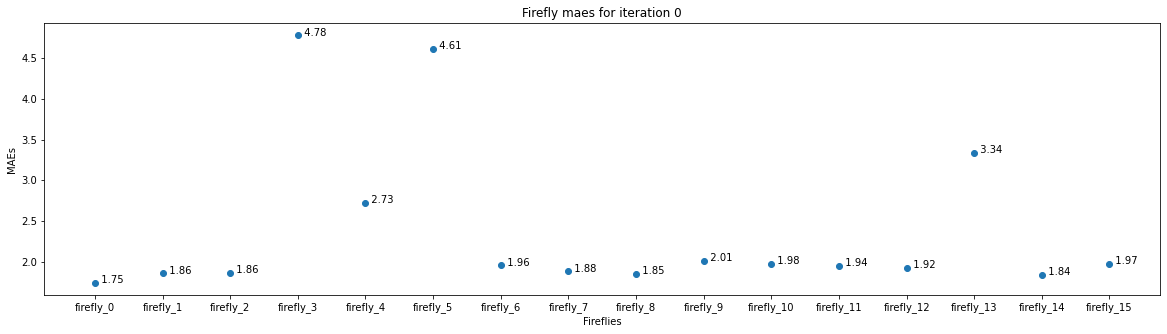


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.3283, 0.2899, 0.2888, 0.0438, 0.1346, 0.047, 0.2615, 0.2826, 0.2914, 0.2473, 0.2561, 0.2646, 0.2704, 0.0896, 0.2951, 0.2579]

firefly_ranked_indexes
[0, 14, 8, 1, 2, 7, 12, 11, 6, 15, 10, 9, 4, 13, 5, 3]

firefly ranked intensities
[0.328, 0.295, 0.291, 0.29, 0.289, 0.283, 0.27, 0.265, 0.261, 0.258, 0.256, 0.247, 0.135, 0.09, 0.047, 0.044]

Moving the fireflies
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 14 MAE = 1.840780442659743 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 8 MAE = 1.8523493855125235 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 1 MAE = 1.8574224029567745 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 2 MAE = 1.860704092174566 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 7 MAE = 1.8810887902009288 | B is better than A? False
Firefly_A

feature_fraction has changed from 0.7143540617621137 to 0.7135289643770995 taking a step of size 0.5
lambda_l1 has changed from 6 to 6.0 taking a step of size 0.5
lambda_l2 has changed from 12 to 11.983963543772127 taking a step of size 0.5
Decided to keep using meter_id_ord as firefly 10 already uses it
Decided to stop using meter_id_binary as firefly 10 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 14 doesn't use it
Decided to start using day_of_week as firefly 14 uses it
Decided to stop using day_of_month as firefly 14 doesn't use it
Decided to keep using month_ord as firefly 10 already uses it
Decided to stop using month_cyclic as firefly 14 doesn't use it
Decided to keep using is_weekend as firefly 10 already uses it
Decided to keep using energy_cluster as firefly 10 already uses it
Decided to start using num_bedrooms as firefly 14 uses it
Decided to start using dwelling_type_ord as firefly 14 uses it
Decided to stop using dwelling_type_onehot as firef

learning_rate has changed from 0.01939988139736134 to 0.019394302636752174 taking a step of size 0.03125
num_leaves has changed from 1028 to 1027.2075410526252 taking a step of size 0.03125
max_depth has changed from 11 to 10.9974641313684 taking a step of size 0.03125
bagging_fraction has changed from 0.8986377568929171 to 0.8987282395298051 taking a step of size 0.03125
bagging_freq has changed from 11 to 10.9974641313684 taking a step of size 0.03125
feature_fraction has changed from 0.6357776829373951 to 0.635643563783353 taking a step of size 0.03125
lambda_l1 has changed from 7 to 7.0139472774737985 taking a step of size 0.03125
lambda_l2 has changed from 13 to 13.0025358686316 taking a step of size 0.03125
Decided to keep using meter_id_ord as firefly 4 already uses it
Decided to stop using meter_id_binary as firefly 4 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 4 doesn't already use it
Decided to stop using day_of_week as firefly 7 doesn't use it


Decided to stop using meter_id_binary as firefly 5 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 5 doesn't already use it
Decided to keep using day_of_week as firefly 5 already uses it
Decided to stop using day_of_month as firefly 5 doesn't already use it
Decided to keep using month_ord as firefly 5 already uses it
Decided to stop using month_cyclic as firefly 5 doesn't already use it
Decided to keep using is_weekend as firefly 5 already uses it
Decided to keep using energy_cluster as firefly 5 already uses it
Decided to stop using num_bedrooms as firefly 5 doesn't already use it
Decided to keep using dwelling_type_ord as firefly 5 already uses it
Decided to stop using dwelling_type_onehot as firefly 5 doesn't already use it
Firefly_A = 5 MAE = 4.613847044301183 | Firefly_B = 7 MAE = 1.8810887902009288 | B is better than A? True
Intensity difference between 5 and 7 is 0.06457818295679345
learning_rate has changed from 0.07738797503711117 to 0.07726207184754

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 1, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.034, 'num_leaves': 958, 'max_depth': 10, 'bagging_fraction': 0.87, 'bagging_freq': 18, 'feature_fraction': 0.93, 'lambda_l1': 7, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[1248]	valid_0's l1: 2.65134
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5640203253392446, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5640203253392446
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9787405756960086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9787405756960086
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
Early stopping, best iteration is:
[864]	valid_0's l1: 2.6628
MAE = 2.65

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6337587008865257, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6337587008865257
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.6649105376857526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6649105376857526
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.98545
Early stopping, best iteration is:
[4611]	valid_0's l1: 1.97814
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6337587008865257, colsample_bytree=1.

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.641
Early stopping, best iteration is:
[3501]	valid_0's l1: 2.64076
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5351946183399786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5351946183399786
[LightGBM] [Warning] lambda_l1 is set=18, reg_alpha=0.0 will be ignored. Current value: lambda_l1=18
[LightGBM] [Warning] bagging_fraction is set=0.9685854991773131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9685854991773131
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.65406
Early stopping, be

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7133751292882348, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7133751292882348
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.7926851331471757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7926851331471757
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99593
Early stopping, best iteration is:
[4870]	valid_0's l1: 1.99276
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7133751292882348, colsample_bytree=1.

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.01735
[6666]	valid_0's l1: 2.00237
[9999]	valid_0's l1: 1.99566
Did not meet early stopping. Best iteration is:
[9983]	valid_0's l1: 1.99562
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5954919457860836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5954919457860836
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6843424490947783, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6843424490947783
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7327445072153036, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7327445072153036
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.5496862298218343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5496862298218343
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.09246
[6666]	valid_0's l1: 2.06362
[9999]	valid_0's l1: 2.04995
Did not meet early stopping. Best iteration is:
[9900]	valid_0's l1: 2.04925
Fold 2
Training the LGBM
[LightGBM] 

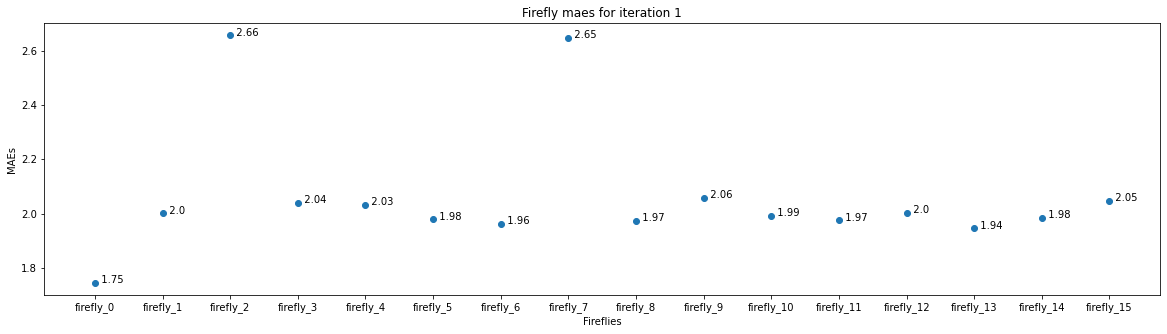


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.3283, 0.2499, 0.1416, 0.2403, 0.2423, 0.2556, 0.2601, 0.1425, 0.2569, 0.2363, 0.2526, 0.2566, 0.2497, 0.2644, 0.2539, 0.2385]

firefly_ranked_indexes
[0, 13, 6, 8, 11, 5, 14, 10, 1, 12, 4, 3, 15, 9, 7, 2]

firefly ranked intensities
[0.328, 0.264, 0.26, 0.257, 0.257, 0.256, 0.254, 0.253, 0.25, 0.25, 0.242, 0.24, 0.238, 0.236, 0.143, 0.142]

Moving the fireflies
Firefly_A = 0 MAE = 1.7452173623975273 | Firefly_B = 13 MAE = 1.9447359410333396 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975273 | Firefly_B = 6 MAE = 1.960702856788706 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975273 | Firefly_B = 8 MAE = 1.9729667729296465 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975273 | Firefly_B = 11 MAE = 1.9742900866122535 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975273 | Firefly_B = 5 MAE = 1.9779696109198077 | B is better than A? False
Firefly

Decided to keep using month_ord as firefly 4 already uses it
Decided to stop using month_cyclic as firefly 4 doesn't already use it
Decided to start using is_weekend as firefly 13 uses it
Decided to start using energy_cluster as firefly 13 uses it
Decided to stop using num_bedrooms as firefly 4 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 4 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 13 doesn't use it
Firefly_A = 4 MAE = 2.031425328367159 | Firefly_B = 6 MAE = 1.960702856788706 | B is better than A? True
Intensity difference between 4 and 6 is 0.004598892430255422
learning_rate has changed from 0.019803779973645654 to 0.01987312143436749 taking a step of size 0.25
num_leaves has changed from 1026 to 1025.710269776894 taking a step of size 0.25
max_depth has changed from 11 to 10.998850276892437 taking a step of size 0.25
bagging_fraction has changed from 0.8979338607645304 to 0.897667036248345 taking a step of size 0.25
bagg

Decided to stop using dwelling_type_onehot as firefly 6 doesn't use it
Firefly_A = 15 MAE = 2.0478057783393218 | Firefly_B = 8 MAE = 1.9729667729296465 | B is better than A? True
Intensity difference between 15 and 8 is 0.004763619626800976
learning_rate has changed from 0.034471567953311674 to 0.03449310322369315 taking a step of size 0.125
num_leaves has changed from 82 to 82.23699007643334 taking a step of size 0.125
max_depth has changed from 6 to 6.00178635736005 taking a step of size 0.125
bagging_fraction has changed from 0.558565686926016 to 0.5587393664995812 taking a step of size 0.125
bagging_freq has changed from 9 to 9.0023818098134 taking a step of size 0.125
feature_fraction has changed from 0.7377925271594215 to 0.7377124513573406 taking a step of size 0.125
lambda_l1 has changed from 12 to 11.99940454754665 taking a step of size 0.125
lambda_l2 has changed from 16 to 15.9988090950933 taking a step of size 0.125
Decided to keep using meter_id_ord as firefly 15 already u

Firefly_A = 2 MAE = 2.6573719375195792 | Firefly_B = 1 MAE = 2.0003240070879156 | B is better than A? True
Intensity difference between 2 and 1 is 0.02798848788645473
learning_rate has changed from 0.058517437608582086 to 0.05851476228893803 taking a step of size 0.00390625
num_leaves has changed from 1397 to 1396.951894786445 taking a step of size 0.00390625
max_depth has changed from 11 to 10.999890669969194 taking a step of size 0.00390625
bagging_fraction has changed from 0.9690596097517761 to 0.9690487840553339 taking a step of size 0.00390625
bagging_freq has changed from 16 to 16.000218660061613 taking a step of size 0.00390625
feature_fraction has changed from 0.5885286640256976 to 0.5885659639871472 taking a step of size 0.00390625
lambda_l1 has changed from 17 to 16.998906699691936 taking a step of size 0.00390625
lambda_l2 has changed from 15 to 14.998906699691936 taking a step of size 0.00390625
Decided to keep using meter_id_ord as firefly 2 already uses it
Decided to stop

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 2, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.034, 'num_leaves': 958, 'max_depth': 10, 'bagging_fraction': 0.87, 'bagging_freq': 18, 'feature_fraction': 0.93, 'lambda_l1': 7, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5885727354073359, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5885727354073359
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9690246043308403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9690246043308403
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.94936
[6666]	valid_0's l1: 1.94098
Early stopping, best iteration is:
[8382]	valid_0's l1: 1.93899
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5885

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99998
[6666]	valid_0's l1: 1.98737
[9999]	valid_0's l1: 1.98305
Did not meet early stopping. Best iteration is:
[9987]	valid_0's l1: 1.983
MAE = 1.976937186763158, TOE = 1:08:00, Intensity = 0.2558669890951983

Iteration 2, Firefly 5
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.07635016329659748, 'num_leaves': 1509, 'max_depth': 11, 'bagging_fraction': 0.6690806965971252, 'bagging_freq': 24, 'feature_fraction': 0.6395897203114664, 'lambda_l1': 9, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6395897203114664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6395897203114664
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be i

[3333]	valid_0's l1: 2.04559
[6666]	valid_0's l1: 2.0148
[9999]	valid_0's l1: 2.00125
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.00124
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5618276985213461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5618276985213461
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9597104934771188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9597104934771188
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.04271
[6666]	

Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7006620842664624, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7006620842664624
[LightGBM] [Warning] lambda_l1 is set=14, reg_alpha=0.0 will be ignored. Current value: lambda_l1=14
[LightGBM] [Warning] bagging_fraction is set=0.9076610309960829, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9076610309960829
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.10994
[6666]	valid_0's l1: 2.07262
[9999]	valid_0's l1: 2.05762
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.05761
MAE = 2.0536739724963233, TOE = 0:33:40,

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6029093037688906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6029093037688906
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6886032481741441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6886032481741441
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.05114
[6666]	valid_0's l1: 2.02581
[9999]	valid_0's l1: 2.01128
Did not meet early stopping. Best iteration is:
[9997]	valid_0's l1: 2.01128
Fold 2
Training the LGBM
[LightGBM] [W

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.0249
[6666]	valid_0's l1: 2.00488
[9999]	valid_0's l1: 1.99594
Did not meet early stopping. Best iteration is:
[9999]	valid_0's l1: 1.99594
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5708797871048039, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5708797871048039
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.9281980570624894, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9281980570624894
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=9, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9
[LightGBM] [Warning] bagging_freq is set=11, subsample_freq=0 will be ignored. Current value: bagging_freq=11
Training until validation scores don't 

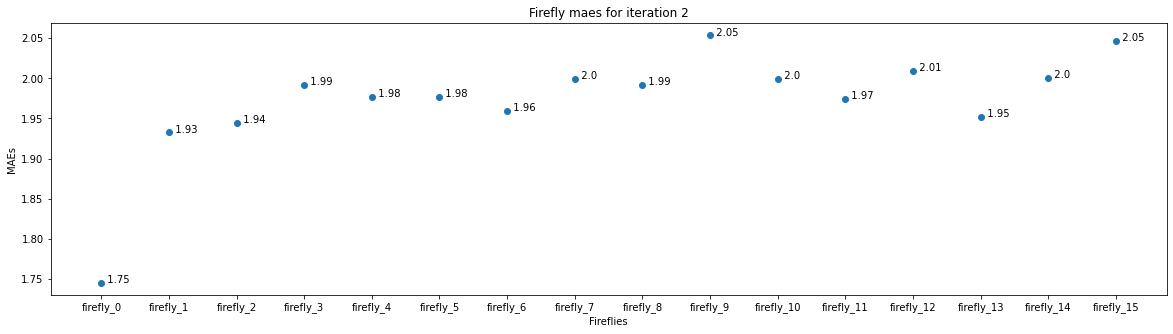


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.3283, 0.2678, 0.2646, 0.2522, 0.2559, 0.256, 0.2604, 0.2502, 0.2519, 0.2371, 0.2501, 0.2565, 0.2477, 0.2625, 0.2499, 0.2387]

firefly_ranked_indexes
[0, 1, 2, 13, 6, 11, 5, 4, 3, 8, 7, 10, 14, 12, 15, 9]

firefly ranked intensities
[0.328, 0.268, 0.265, 0.263, 0.26, 0.257, 0.256, 0.256, 0.252, 0.252, 0.25, 0.25, 0.25, 0.248, 0.239, 0.237]

Moving the fireflies
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 1 MAE = 1.9325308497664526 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 2 MAE = 1.9442209655836518 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 13 MAE = 1.9517531883281252 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 6 MAE = 1.959687675349147 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 11 MAE = 1.974490077426433 | B is better than A? False
Firefly_A

Decided to start using dwelling_type_ord as firefly 1 uses it
Decided to stop using dwelling_type_onehot as firefly 8 doesn't already use it
Firefly_A = 8 MAE = 1.9922873871601872 | Firefly_B = 2 MAE = 1.9442209655836518 | B is better than A? True
Intensity difference between 8 and 2 is 0.003053900954606309
learning_rate has changed from 0.06920233565023433 to 0.06919417291837675 taking a step of size 0.25
num_leaves has changed from 500 to 500.68483728907046 taking a step of size 0.25
max_depth has changed from 9 to 9.001526950477302 taking a step of size 0.25
bagging_fraction has changed from 0.8510516027721678 to 0.8511416722376873 taking a step of size 0.25
bagging_freq has changed from 13 to 13.002290425715955 taking a step of size 0.25
feature_fraction has changed from 0.6161161882314441 to 0.6160951594872259 taking a step of size 0.25
lambda_l1 has changed from 11 to 11.00458085143191 taking a step of size 0.25
lambda_l2 has changed from 14 to 14.000763475238651 taking a step of

max_depth has changed from 7 to 7.006498778861721 taking a step of size 0.5
bagging_fraction has changed from 0.9270924103514072 to 0.9269687160323608 taking a step of size 0.5
bagging_freq has changed from 11 to 11.015163817344014 taking a step of size 0.5
feature_fraction has changed from 0.5777023530513674 to 0.5784641343789023 taking a step of size 0.5
lambda_l1 has changed from 6 to 6.002166259620574 taking a step of size 0.5
lambda_l2 has changed from 9 to 8.991334961517705 taking a step of size 0.5
Decided to start using meter_id_ord as firefly 1 uses it
Decided to stop using meter_id_binary as firefly 1 doesn't use it
Decided to stop using day_of_year_cyclic as firefly 14 doesn't already use it
Decided to keep using day_of_week as firefly 14 already uses it
Decided to stop using day_of_month as firefly 14 doesn't already use it
Decided to start using month_ord as firefly 1 uses it
Decided to stop using month_cyclic as firefly 14 doesn't already use it
Decided to start using is_

learning_rate has changed from 0.01684682339431787 to 0.017225728674921007 taking a step of size 1
num_leaves has changed from 93 to 112.10742687818781 taking a step of size 1
max_depth has changed from 6 to 6.088358043367343 taking a step of size 1
bagging_fraction has changed from 0.9076610309960829 to 0.9068291172435802 taking a step of size 1
bagging_freq has changed from 18 to 18.0 taking a step of size 1
feature_fraction has changed from 0.7006620842664624 to 0.7057280466425023 taking a step of size 1
lambda_l1 has changed from 14 to 13.845373424107152 taking a step of size 1
lambda_l2 has changed from 16 to 15.757015380739809 taking a step of size 1
Decided to start using meter_id_ord as firefly 0 uses it
Decided to stop using meter_id_binary as firefly 0 doesn't use it
Decided to stop using day_of_year_cyclic as firefly 0 doesn't use it
Decided to start using day_of_week as firefly 0 uses it
Decided to stop using day_of_month as firefly 0 doesn't use it
Decided to start using m

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 3, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.034, 'num_leaves': 958, 'max_depth': 10, 'bagging_fraction': 0.87, 'bagging_freq': 18, 'feature_fraction': 0.93, 'lambda_l1': 7, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.94638
Early stopping, best iteration is:
[5631]	valid_0's l1: 1.94191
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5939757663097627, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5939757663097627
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.967457480798476, subsample=1.0 will be ignored. Current value: bagging_fraction=0.967457480798476
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.95535
Early stopping, 

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.645106362881414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.645106362881414
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.6730897409471106, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6730897409471106
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.96788
Early stopping, best iteration is:
[5340]	valid_0's l1: 1.95848
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.645106362881414, colsample_bytree=1.0 w

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.03352
[6666]	valid_0's l1: 2.00629
[9999]	valid_0's l1: 1.99406
Did not meet early stopping. Best iteration is:
[9975]	valid_0's l1: 1.99403
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5697419319271466, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5697419319271466
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9577568112606263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9577568112606263
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don

MAE = 2.0545187270658762, TOE = 0:33:53, Intensity = 0.23690803553017067

Iteration 3, Firefly 10
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.04004464240682286, 'num_leaves': 341, 'max_depth': 9, 'bagging_fraction': 0.796114957283481, 'bagging_freq': 5, 'feature_fraction': 0.722247020771764, 'lambda_l1': 6, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.722247020771764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.722247020771764
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.796114957283481, subsample=1.0 will be ignored. Current value: bagging_fraction=0.796114957283481
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-

[3333]	valid_0's l1: 2.03977
[6666]	valid_0's l1: 2.01352
[9999]	valid_0's l1: 2.00067
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 2.00066
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6102243090701729, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6102243090701729
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6929600916615051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6929600916615051
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.03148
[6666]	v

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.0091
[6666]	valid_0's l1: 1.9978
Early stopping, best iteration is:
[8755]	valid_0's l1: 1.99289
MAE = 1.9845811352199936, TOE = 0:33:24, Intensity = 0.2538997553755513

Iteration 3, Firefly 15
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.0345735607688291, 'num_leaves': 107, 'max_depth': 6, 'bagging_fraction': 0.5675621840592726, 'bagging_freq': 9, 'feature_fraction': 0.7424617250936192, 'lambda_l1': 12, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7424617250936192, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7424617250936192
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: la

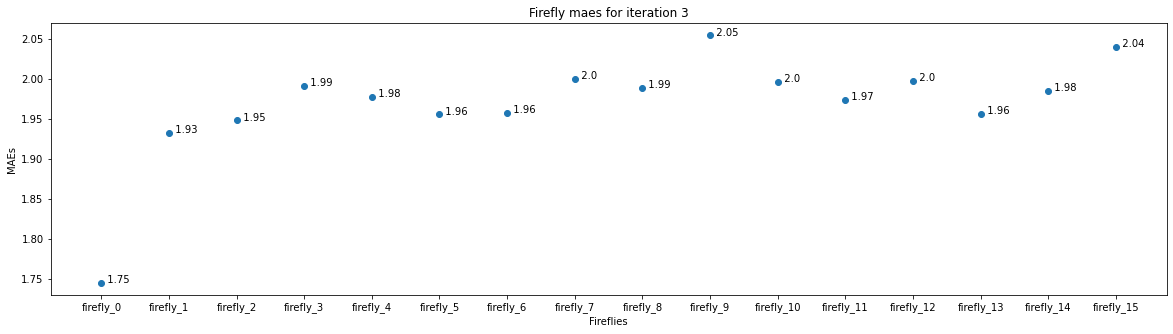


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.3283, 0.2677, 0.2635, 0.2521, 0.2557, 0.2615, 0.2608, 0.2499, 0.2528, 0.2369, 0.2508, 0.2567, 0.2505, 0.2614, 0.2539, 0.2402]

firefly_ranked_indexes
[0, 1, 2, 5, 13, 6, 11, 4, 14, 8, 3, 10, 12, 7, 15, 9]

firefly ranked intensities
[0.328, 0.268, 0.263, 0.261, 0.261, 0.261, 0.257, 0.256, 0.254, 0.253, 0.252, 0.251, 0.25, 0.25, 0.24, 0.237]

Moving the fireflies
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 1 MAE = 1.93283994388789 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 2 MAE = 1.9481501511362143 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 5 MAE = 1.9556347964248293 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 13 MAE = 1.9559688269252506 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 6 MAE = 1.9579792658436543 | B is better than A? False
Firefly_

Decided to keep using day_of_week as firefly 14 already uses it
Decided to stop using day_of_month as firefly 14 doesn't already use it
Decided to keep using month_ord as firefly 14 already uses it
Decided to stop using month_cyclic as firefly 1 doesn't use it
Decided to keep using is_weekend as firefly 14 already uses it
Decided to start using energy_cluster as firefly 1 uses it
Decided to stop using num_bedrooms as firefly 1 doesn't use it
Decided to stop using dwelling_type_ord as firefly 1 doesn't use it
Decided to stop using dwelling_type_onehot as firefly 14 doesn't already use it
Firefly_A = 14 MAE = 1.9845811352199936 | Firefly_B = 2 MAE = 1.9481501511362143 | B is better than A? True
Intensity difference between 14 and 2 is 0.0023136315910222485
learning_rate has changed from 0.08983582110355773 to 0.08981747811790747 taking a step of size 0.25
num_leaves has changed from 145 to 145.72011783270568 taking a step of size 0.25
max_depth has changed from 7 to 7.002313631591022 tak

Decided to stop using month_cyclic as firefly 3 doesn't already use it
Decided to keep using is_weekend as firefly 3 already uses it
Decided to keep using energy_cluster as firefly 3 already uses it
Decided to stop using num_bedrooms as firefly 3 doesn't already use it
Decided to keep using dwelling_type_ord as firefly 3 already uses it
Decided to stop using dwelling_type_onehot as firefly 3 doesn't already use it
Firefly_A = 3 MAE = 1.991673438507135 | Firefly_B = 4 MAE = 1.9774458578814522 | B is better than A? True
Intensity difference between 3 and 4 is 0.0008788026181958744
learning_rate has changed from 0.02948568787031713 to 0.029485624252759145 taking a step of size 0.0078125
num_leaves has changed from 464 to 464.00385162710006 taking a step of size 0.0078125
max_depth has changed from 9 to 9.00001373129091 taking a step of size 0.0078125
bagging_fraction has changed from 0.6553720373038352 to 0.6553736965300333 taking a step of size 0.0078125
bagging_freq has changed from 15 

Firefly_A = 12 MAE = 1.9980660648808473 | Firefly_B = 14 MAE = 1.9845811352199936 | B is better than A? True
Intensity difference between 12 and 14 is 0.0008244697332708273
learning_rate has changed from 0.01704789904216141 to 0.017048137055801174 taking a step of size 0.00390625
num_leaves has changed from 1945 to 1944.9941514178297 taking a step of size 0.00390625
max_depth has changed from 11 to 10.999987117660417 taking a step of size 0.00390625
bagging_fraction has changed from 0.6968881921135661 to 0.6968889330290076 taking a step of size 0.00390625
bagging_freq has changed from 5 to 5.000019323509374 taking a step of size 0.00390625
feature_fraction has changed from 0.6169365819502983 to 0.6169364585957852 taking a step of size 0.00390625
lambda_l1 has changed from 8 to 7.999993558830209 taking a step of size 0.00390625
lambda_l2 has changed from 18 to 17.99997101473594 taking a step of size 0.00390625
Decided to keep using meter_id_ord as firefly 12 already uses it
Decided to s

Decided to stop using dwelling_type_ord as firefly 9 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 9 doesn't already use it
Firefly_A = 9 MAE = 2.0545187270658762 | Firefly_B = 13 MAE = 1.9559688269252506 | B is better than A? True
Intensity difference between 9 and 13 is 0.0059077334931194395
learning_rate has changed from 0.017945811416486736 to 0.017953796339426786 taking a step of size 0.0625
num_leaves has changed from 143 to 143.33821774248108 taking a step of size 0.0625
max_depth has changed from 6 to 6.0018461667166 taking a step of size 0.0625
bagging_fraction has changed from 0.9056484933648065 to 0.9056611383568167 taking a step of size 0.0625
bagging_freq has changed from 18 to 18.00036923334332 taking a step of size 0.0625
feature_fraction has changed from 0.712042871527749 to 0.7120731390525451 taking a step of size 0.0625
lambda_l1 has changed from 14 to 14.00036923334332 taking a step of size 0.0625
lambda_l2 has changed from 16 to 15.998

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 4, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.034, 'num_leaves': 958, 'max_depth': 10, 'bagging_fraction': 0.87, 'bagging_freq': 18, 'feature_fraction': 0.93, 'lambda_l1': 7, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93058
Early stopping, best iteration is:
[6366]	valid_0's l1: 1.92534
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5994018638714562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5994018638714562
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9658836471860793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9658836471860793
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93501
Early stopping

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6499062685536156, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6499062685536156
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.6764476690934611, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6764476690934611
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.96891
Early stopping, best iteration is:
[5342]	valid_0's l1: 1.9581
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6499062685536156, colsample_bytree=1.0

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99362
[6666]	valid_0's l1: 1.9746
[9999]	valid_0's l1: 1.96579
Did not meet early stopping. Best iteration is:
[9978]	valid_0's l1: 1.96573
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5774291354794429, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5774291354794429
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9557856401485542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9557856401485542
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don'

MAE = 2.030562716540587, TOE = 0:33:31, Intensity = 0.24253095923273896

Iteration 4, Firefly 10
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.03994905563202957, 'num_leaves': 355, 'max_depth': 9, 'bagging_fraction': 0.7977442972158892, 'bagging_freq': 5, 'feature_fraction': 0.7264523548564196, 'lambda_l1': 6, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7264523548564196, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7264523548564196
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.7977442972158892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7977442972158892
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be i

Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6169365727320706, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6169365727320706
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.6968890886294428, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6968890886294428
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.03056
[6666]	valid_0's l1: 2.00438
[9999]	valid_0's l1: 1.99166
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.99165
Fold 3
Training the LGBM
[LightGBM] [Warning

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.0099
[6666]	valid_0's l1: 1.99786
Early stopping, best iteration is:
[9304]	valid_0's l1: 1.9925
MAE = 1.986551820216198, TOE = 0:36:01, Intensity = 0.25339626157956474

Iteration 4, Firefly 15
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.03463165117568494, 'num_leaves': 131, 'max_depth': 6, 'bagging_fraction': 0.575736756638878, 'bagging_freq': 9, 'feature_fraction': 0.7468298110390161, 'lambda_l1': 12, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7468298110390161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7468298110390161
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] baggi

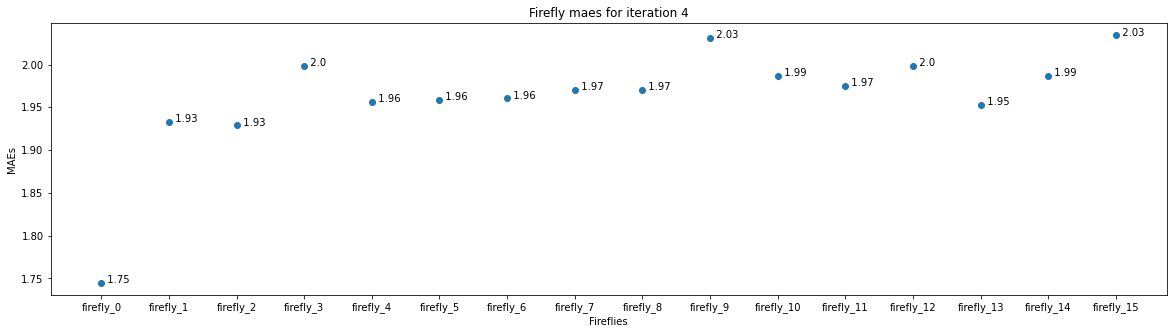


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.3283, 0.2676, 0.2688, 0.2504, 0.2614, 0.2607, 0.2602, 0.2577, 0.2575, 0.2425, 0.2533, 0.2565, 0.2505, 0.2622, 0.2534, 0.2417]

firefly_ranked_indexes
[0, 2, 1, 13, 4, 5, 6, 7, 8, 11, 14, 10, 12, 3, 9, 15]

firefly ranked intensities
[0.328, 0.269, 0.268, 0.262, 0.261, 0.261, 0.26, 0.258, 0.257, 0.256, 0.253, 0.253, 0.251, 0.25, 0.243, 0.242]

Moving the fireflies
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 2 MAE = 1.9288381927277531 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 1 MAE = 1.9330781772759844 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 13 MAE = 1.9527806015187525 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 4 MAE = 1.9558258836300555 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 5 MAE = 1.958444159497055 | B is better than A? False
Firefl

Decided to keep using day_of_week as firefly 11 already uses it
Decided to stop using day_of_month as firefly 11 doesn't already use it
Decided to keep using month_ord as firefly 11 already uses it
Decided to stop using month_cyclic as firefly 11 doesn't already use it
Decided to keep using is_weekend as firefly 11 already uses it
Decided to keep using energy_cluster as firefly 11 already uses it
Decided to stop using num_bedrooms as firefly 11 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 11 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 11 doesn't already use it
Firefly_A = 11 MAE = 1.9745840719516146 | Firefly_B = 8 MAE = 1.9707881907461973 | B is better than A? True
Intensity difference between 11 and 8 is 0.00023699408832381086
learning_rate has changed from 0.08936249367692654 to 0.08936247434071073 taking a step of size 0.00390625
num_leaves has changed from 186 to 186.00030087140118 taking a step of size 0.00390625
max_d

Decided to keep using month_ord as firefly 12 already uses it
Decided to stop using month_cyclic as firefly 12 doesn't already use it
Decided to keep using is_weekend as firefly 12 already uses it
Decided to keep using energy_cluster as firefly 12 already uses it
Decided to stop using num_bedrooms as firefly 12 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 12 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 12 doesn't already use it
Firefly_A = 12 MAE = 1.9978150973808075 | Firefly_B = 7 MAE = 1.969957754724167 | B is better than A? True
Intensity difference between 12 and 7 is 0.0017101340546508761
learning_rate has changed from 0.017484155664788528 to 0.017484167852008816 taking a step of size 0.0078125
num_leaves has changed from 1925 to 1924.9805605855506 taking a step of size 0.0078125
max_depth has changed from 11 to 10.999973279155396 taking a step of size 0.0078125
bagging_fraction has changed from 0.700981910486907 to 0.7

Decided to keep using is_weekend as firefly 15 already uses it
Decided to keep using energy_cluster as firefly 15 already uses it
Decided to stop using num_bedrooms as firefly 15 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 15 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 15 doesn't already use it
Firefly_A = 15 MAE = 2.0339635122660207 | Firefly_B = 6 MAE = 1.9603840402762094 | B is better than A? True
Intensity difference between 15 and 6 is 0.004429981989342205
learning_rate has changed from 0.034697058884567415 to 0.03470003717390529 taking a step of size 0.015625
num_leaves has changed from 154 to 154.043538416739 taking a step of size 0.015625
max_depth has changed from 6 to 6.000276873874334 taking a step of size 0.015625
bagging_fraction has changed from 0.5838580667649342 to 0.5838644850941463 taking a step of size 0.015625
bagging_freq has changed from 9 to 8.999861563062833 taking a step of size 0.015625
feature_fra

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 5, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.034, 'num_leaves': 958, 'max_depth': 10, 'bagging_fraction': 0.87, 'bagging_freq': 18, 'feature_fraction': 0.93, 'lambda_l1': 7, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.92723
[6666]	valid_0's l1: 1.92305
Early stopping, best iteration is:
[7632]	valid_0's l1: 1.92194
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6041186425410642, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6041186425410642
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9645156360196896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9645156360196896
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
[3333]	valid_0

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6545105380235821, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6545105380235821
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.679952386607197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.679952386607197
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.97007
Early stopping, best iteration is:
[5339]	valid_0's l1: 1.95933
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6545105380235821, colsample_bytree=1.0 

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99419
[6666]	valid_0's l1: 1.97381
[9999]	valid_0's l1: 1.96556
Did not meet early stopping. Best iteration is:
[9981]	valid_0's l1: 1.9655
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5836624874866069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5836624874866069
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9542843238825365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9542843238825365
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don'

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7300466539948701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7300466539948701
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.7994517687059282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994517687059282
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=12, reg_lambda=0.0 will be ignored. Current value: lambda_l2=12
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99616
[6666]	valid_0's l1: 1.98693
Early stopping, best iteration is:
[7640]	valid_0's l1: 1.98589
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.73004665

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99591
[6666]	valid_0's l1: 1.97722
[9999]	valid_0's l1: 1.96676
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.96675
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6231136913550663, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6231136913550663
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.7009860739583162, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7009860739583162
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don'

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7504115181964112, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7504115181964112
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagging_fraction is set=0.5838806705049155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5838806705049155
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=16, reg_lambda=0.0 will be ignored. Current value: lambda_l2=16
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.06134
[6666]	valid_0's l1: 2.04102
[9999]	valid_0's l1: 2.03094
Did not meet early stopping. Best iteration is:
[9900]	valid_0's l1: 2.03071
Fold 2
Training the LGBM
[LightGBM] 

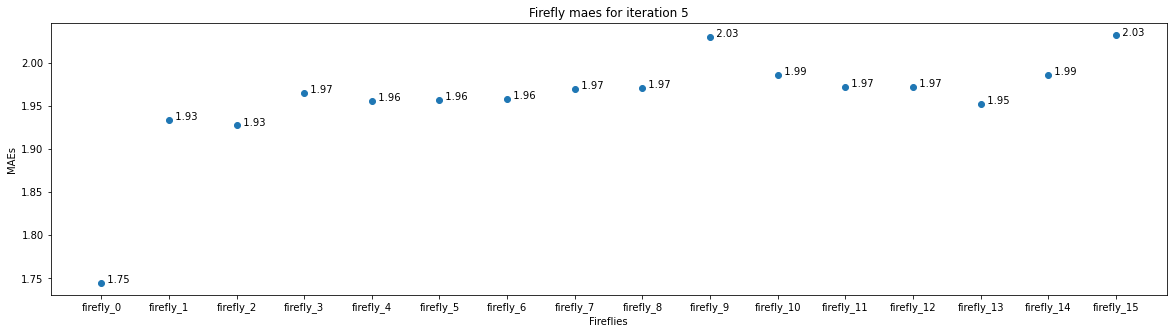


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.3283, 0.2672, 0.2691, 0.2588, 0.2614, 0.261, 0.2608, 0.2577, 0.2573, 0.2426, 0.2536, 0.257, 0.257, 0.2622, 0.2535, 0.2421]

firefly_ranked_indexes
[0, 2, 1, 13, 4, 5, 6, 3, 7, 8, 11, 12, 10, 14, 9, 15]

firefly ranked intensities
[0.328, 0.269, 0.267, 0.262, 0.261, 0.261, 0.261, 0.259, 0.258, 0.257, 0.257, 0.257, 0.254, 0.253, 0.243, 0.242]

Moving the fireflies
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 2 MAE = 1.927653455373432 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 1 MAE = 1.9343847971036046 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 13 MAE = 1.9530054740758818 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 4 MAE = 1.9560760910098816 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 5 MAE = 1.9573296347959177 | B is better than A? False
Firefly

lambda_l1 has changed from 17 to 17.0 taking a step of size 0.0078125
lambda_l2 has changed from 15 to 14.999991605979776 taking a step of size 0.0078125
Decided to keep using meter_id_ord as firefly 7 already uses it
Decided to stop using meter_id_binary as firefly 7 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 7 doesn't already use it
Decided to keep using day_of_week as firefly 7 already uses it
Decided to stop using day_of_month as firefly 7 doesn't already use it
Decided to keep using month_ord as firefly 7 already uses it
Decided to stop using month_cyclic as firefly 7 doesn't already use it
Decided to keep using is_weekend as firefly 7 already uses it
Decided to keep using energy_cluster as firefly 7 already uses it
Decided to stop using num_bedrooms as firefly 7 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 7 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 7 doesn't already use it
Firefly_A =

bagging_freq has changed from 5 to 5.007949012247382 taking a step of size 0.25
feature_fraction has changed from 0.6283027766053717 to 0.6284868501211417 taking a step of size 0.25
lambda_l1 has changed from 8 to 7.999388537519432 taking a step of size 0.25
lambda_l2 has changed from 18 to 17.99205098775262 taking a step of size 0.25
Decided to keep using meter_id_ord as firefly 12 already uses it
Decided to stop using meter_id_binary as firefly 12 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 12 doesn't already use it
Decided to keep using day_of_week as firefly 12 already uses it
Decided to stop using day_of_month as firefly 1 doesn't use it
Decided to keep using month_ord as firefly 12 already uses it
Decided to stop using month_cyclic as firefly 12 doesn't already use it
Decided to keep using is_weekend as firefly 12 already uses it
Decided to start using energy_cluster as firefly 1 uses it
Decided to stop using num_bedrooms as firefly 12 doesn't alrea

Decided to stop using dwelling_type_ord as firefly 9 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 2 doesn't use it
Firefly_A = 9 MAE = 2.030271113473083 | Firefly_B = 1 MAE = 1.9343847971036046 | B is better than A? True
Intensity difference between 9 and 1 is 0.005882700419166109
learning_rate has changed from 0.018914829652211557 to 0.018937167716528133 taking a step of size 0.25
num_leaves has changed from 186 to 187.13389050579426 taking a step of size 0.25
max_depth has changed from 6 to 6.005882700419166 taking a step of size 0.25
bagging_fraction has changed from 0.9044433884596548 to 0.9043927420676686 taking a step of size 0.25
bagging_freq has changed from 18 to 18.0 taking a step of size 0.25
feature_fraction has changed from 0.7205870618992976 to 0.7208940709674367 taking a step of size 0.25
lambda_l1 has changed from 14 to 13.98970527426646 taking a step of size 0.25
lambda_l2 has changed from 16 to 15.983822573847293 taking a step of size 0

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 6, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.034, 'num_leaves': 958, 'max_depth': 10, 'bagging_fraction': 0.87, 'bagging_freq': 18, 'feature_fraction': 0.93, 'lambda_l1': 7, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.92992
[6666]	valid_0's l1: 1.92486
Early stopping, best iteration is:
[7122]	valid_0's l1: 1.92436
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6087236185176859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6087236185176859
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9631800510795764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9631800510795764
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
[3333]	valid_0

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6589882891944222, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6589882891944222
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.6833565846599309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6833565846599309
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.96808
Early stopping, best iteration is:
[5339]	valid_0's l1: 1.95706
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6589882891944222, colsample_bytree=1.

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99391
[6666]	valid_0's l1: 1.97597
[9999]	valid_0's l1: 1.96752
Did not meet early stopping. Best iteration is:
[9970]	valid_0's l1: 1.96744
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5897520589497147, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5897520589497147
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9528165721245568, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9528165721245568
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don

MAE = 2.02950560210438, TOE = 0:34:55, Intensity = 0.2427836806338889

Iteration 6, Firefly 10
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.03979462657384651, 'num_leaves': 382, 'max_depth': 9, 'bagging_fraction': 0.8011059250655679, 'bagging_freq': 5, 'feature_fraction': 0.7335442179477101, 'lambda_l1': 6, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7335442179477101, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7335442179477101
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.8011059250655679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8011059250655679
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ign

[LightGBM] [Warning] feature_fraction is set=0.6285212458223883, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6285212458223883
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.7043888979133357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7043888979133357
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99593
[6666]	valid_0's l1: 1.97696
[9999]	valid_0's l1: 1.96678
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.96677
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.01197
[6666]	valid_0's l1: 1.99903
Early stopping, best iteration is:
[9537]	valid_0's l1: 1.99355
MAE = 1.9874698759941767, TOE = 0:37:36, Intensity = 0.253162217103228

Iteration 6, Firefly 15
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.03476559034702538, 'num_leaves': 177, 'max_depth': 6, 'bagging_fraction': 0.591713846490243, 'bagging_freq': 9, 'feature_fraction': 0.7538865199646528, 'lambda_l1': 12, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7538865199646528, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7538865199646528
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current value: lambda_l1=12
[LightGBM] [Warning] bagg

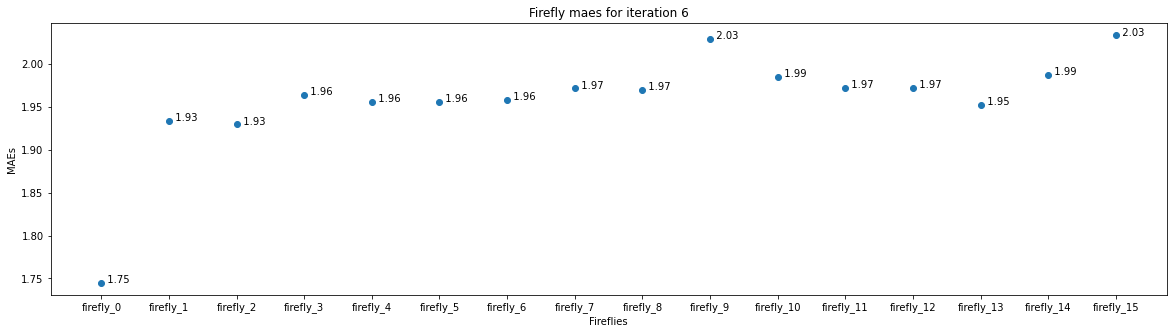


Sorting the fireflies in order of best intensity
firefly_intensities original order
[0.3283, 0.2675, 0.2685, 0.2591, 0.2613, 0.2614, 0.2607, 0.2572, 0.2577, 0.2428, 0.2536, 0.257, 0.257, 0.2623, 0.2532, 0.2418]

firefly_ranked_indexes
[0, 2, 1, 13, 5, 4, 6, 3, 8, 7, 12, 11, 10, 14, 9, 15]

firefly ranked intensities
[0.328, 0.269, 0.267, 0.262, 0.261, 0.261, 0.261, 0.259, 0.258, 0.257, 0.257, 0.257, 0.254, 0.253, 0.243, 0.242]

Moving the fireflies
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 2 MAE = 1.9297209368529924 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 1 MAE = 1.933619629155712 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 13 MAE = 1.9527272011393226 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 5 MAE = 1.9560553263781875 | B is better than A? False
Firefly_A = 0 MAE = 1.7452173623975176 | Firefly_B = 4 MAE = 1.9561674307553532 | B is better than A? False
Firefl

lambda_l2 has changed from 14 to 13.999972944650334 taking a step of size 0.03125
Decided to keep using meter_id_ord as firefly 8 already uses it
Decided to stop using meter_id_binary as firefly 8 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 8 doesn't already use it
Decided to keep using day_of_week as firefly 8 already uses it
Decided to stop using day_of_month as firefly 8 doesn't already use it
Decided to keep using month_ord as firefly 8 already uses it
Decided to stop using month_cyclic as firefly 8 doesn't already use it
Decided to keep using is_weekend as firefly 8 already uses it
Decided to keep using energy_cluster as firefly 8 already uses it
Decided to stop using num_bedrooms as firefly 8 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 8 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 8 doesn't already use it
Firefly_A = 8 MAE = 1.9698857170795383 | Firefly_B = 6 MAE = 1.9584937498067778 | B

learning_rate has changed from 0.01818100324593679 to 0.018184573952561775 taking a step of size 0.0625
num_leaves has changed from 1889 to 1888.9730632247602 taking a step of size 0.0625
max_depth has changed from 11 to 11.0 taking a step of size 0.0625
bagging_fraction has changed from 0.7076956310298811 to 0.7076940588106445 taking a step of size 0.0625
bagging_freq has changed from 5 to 5.001227335082869 taking a step of size 0.0625
feature_fraction has changed from 0.6338273158406126 to 0.633828941153524 taking a step of size 0.0625
lambda_l1 has changed from 8 to 8.000064596583309 taking a step of size 0.0625
lambda_l2 has changed from 18 to 17.999160244416984 taking a step of size 0.0625
Decided to keep using meter_id_ord as firefly 12 already uses it
Decided to stop using meter_id_binary as firefly 12 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 12 doesn't already use it
Decided to keep using day_of_week as firefly 12 already uses it
Decided to sto

lambda_l1 has changed from 6 to 6.000057341639666 taking a step of size 0.03125
lambda_l2 has changed from 12 to 12.000057341639666 taking a step of size 0.03125
Decided to keep using meter_id_ord as firefly 10 already uses it
Decided to stop using meter_id_binary as firefly 10 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 10 doesn't already use it
Decided to keep using day_of_week as firefly 10 already uses it
Decided to stop using day_of_month as firefly 10 doesn't already use it
Decided to keep using month_ord as firefly 10 already uses it
Decided to stop using month_cyclic as firefly 10 doesn't already use it
Decided to keep using is_weekend as firefly 10 already uses it
Decided to keep using energy_cluster as firefly 10 already uses it
Decided to stop using num_bedrooms as firefly 10 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 10 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 10 doesn't alread

Decided to stop using meter_id_binary as firefly 9 doesn't already use it
Decided to stop using day_of_year_cyclic as firefly 9 doesn't already use it
Decided to keep using day_of_week as firefly 9 already uses it
Decided to stop using day_of_month as firefly 9 doesn't already use it
Decided to keep using month_ord as firefly 9 already uses it
Decided to stop using month_cyclic as firefly 9 doesn't already use it
Decided to keep using is_weekend as firefly 9 already uses it
Decided to keep using energy_cluster as firefly 9 already uses it
Decided to stop using num_bedrooms as firefly 9 doesn't already use it
Decided to stop using dwelling_type_ord as firefly 9 doesn't already use it
Decided to stop using dwelling_type_onehot as firefly 9 doesn't already use it
Firefly_A = 9 MAE = 2.02950560210438 | Firefly_B = 14 MAE = 1.9874698759941767 | B is better than A? True
Intensity difference between 9 and 14 is 0.002477292671925445
learning_rate has changed from 0.019438648952977554 to 0.0194

  0%|          | 0/16 [00:00<?, ?it/s]

Iteration 7, Firefly 0
Feature groups
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'dwelling_type_onehot']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.034, 'num_leaves': 958, 'max_depth': 10, 'bagging_fraction': 0.87, 'bagging_freq': 18, 'feature_fraction': 0.93, 'lambda_l1': 7, 'lambda_l2': 5}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93038
Early stopping, best iteration is:
[6370]	valid_0's l1: 1.92504
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6133080635574073, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6133080635574073
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9618504207438454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9618504207438454
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=16, subsample_freq=0 will be ignored. Current value: bagging_freq=16
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.93809
Early stopping

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.6633737593370881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6633737593370881
[LightGBM] [Warning] lambda_l1 is set=9, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9
[LightGBM] [Warning] bagging_fraction is set=0.6866505786808719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6866505786808719
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=24, subsample_freq=0 will be ignored. Current value: bagging_freq=24
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.96991
[6666]	valid_0's l1: 1.95572
Early stopping, best iteration is:
[7901]	valid_0's l1: 1.95298
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.66337375

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99449
[6666]	valid_0's l1: 1.97527
[9999]	valid_0's l1: 1.96659
Did not meet early stopping. Best iteration is:
[9978]	valid_0's l1: 1.96652
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.5957874785390418, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5957874785390418
[LightGBM] [Warning] lambda_l1 is set=17, reg_alpha=0.0 will be ignored. Current value: lambda_l1=17
[LightGBM] [Warning] bagging_fraction is set=0.9513530251712811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9513530251712811
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=15, reg_lambda=0.0 will be ignored. Current value: lambda_l2=15
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
Training until validation scores don

MAE = 2.0292628252263234, TOE = 0:34:01, Intensity = 0.24284177640064808

Iteration 7, Firefly 10
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.039721239825252254, 'num_leaves': 394, 'max_depth': 9, 'bagging_fraction': 0.8026973214652543, 'bagging_freq': 5, 'feature_fraction': 0.7369863266881193, 'lambda_l1': 6, 'lambda_l2': 12}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7369863266881193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7369863266881193
[LightGBM] [Warning] lambda_l1 is set=6, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6
[LightGBM] [Warning] bagging_fraction is set=0.8026973214652543, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8026973214652543
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be

[LightGBM] [Warning] feature_fraction is set=0.6338352115212208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6338352115212208
[LightGBM] [Warning] lambda_l1 is set=8, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8
[LightGBM] [Warning] bagging_fraction is set=0.7076997060596516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7076997060596516
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=18, reg_lambda=0.0 will be ignored. Current value: lambda_l2=18
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.99524
[6666]	valid_0's l1: 1.97643
[9999]	valid_0's l1: 1.96635
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.96634
Fold 3
Training the LGBM
[LightGBM] [Warning] feature_fraction

Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 2.01409
[6666]	valid_0's l1: 2.00105
[9999]	valid_0's l1: 1.9948
Did not meet early stopping. Best iteration is:
[9878]	valid_0's l1: 1.99471
MAE = 1.9882312353512415, TOE = 0:34:18, Intensity = 0.2529683658904056

Iteration 7, Firefly 15
Feature groups
['meter_id_ord', 'day_of_week', 'month_ord', 'is_weekend', 'energy_cluster']
Hyper parameters
{'boosting_type': 'gbdt', 'metric': 'mae', 'num_threads': -1, 'num_iterations': 10000, 'seed': 1337, 'learning_rate': 0.03483499882342988, 'num_leaves': 199, 'max_depth': 6, 'bagging_fraction': 0.599328282271897, 'bagging_freq': 9, 'feature_fraction': 0.7573100854631307, 'lambda_l1': 12, 'lambda_l2': 16}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.7573100854631307, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7573100854631307
[LightGBM] [Warning] lambda_l1 is set=12, reg_alpha=0.0 will be ignored. Current val

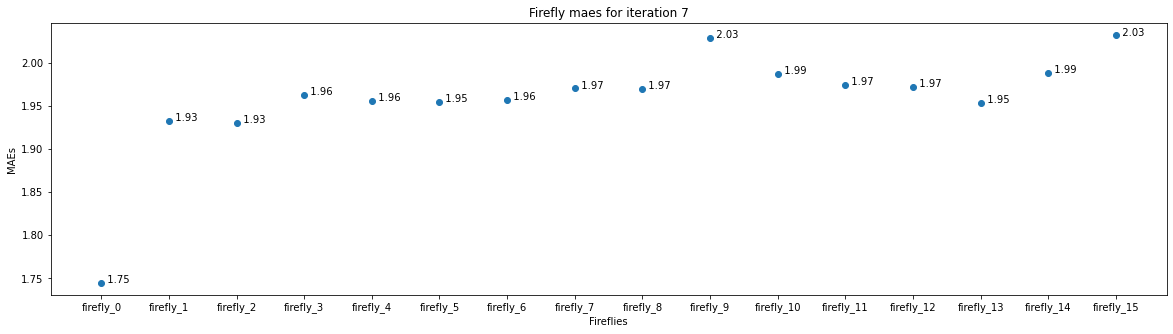

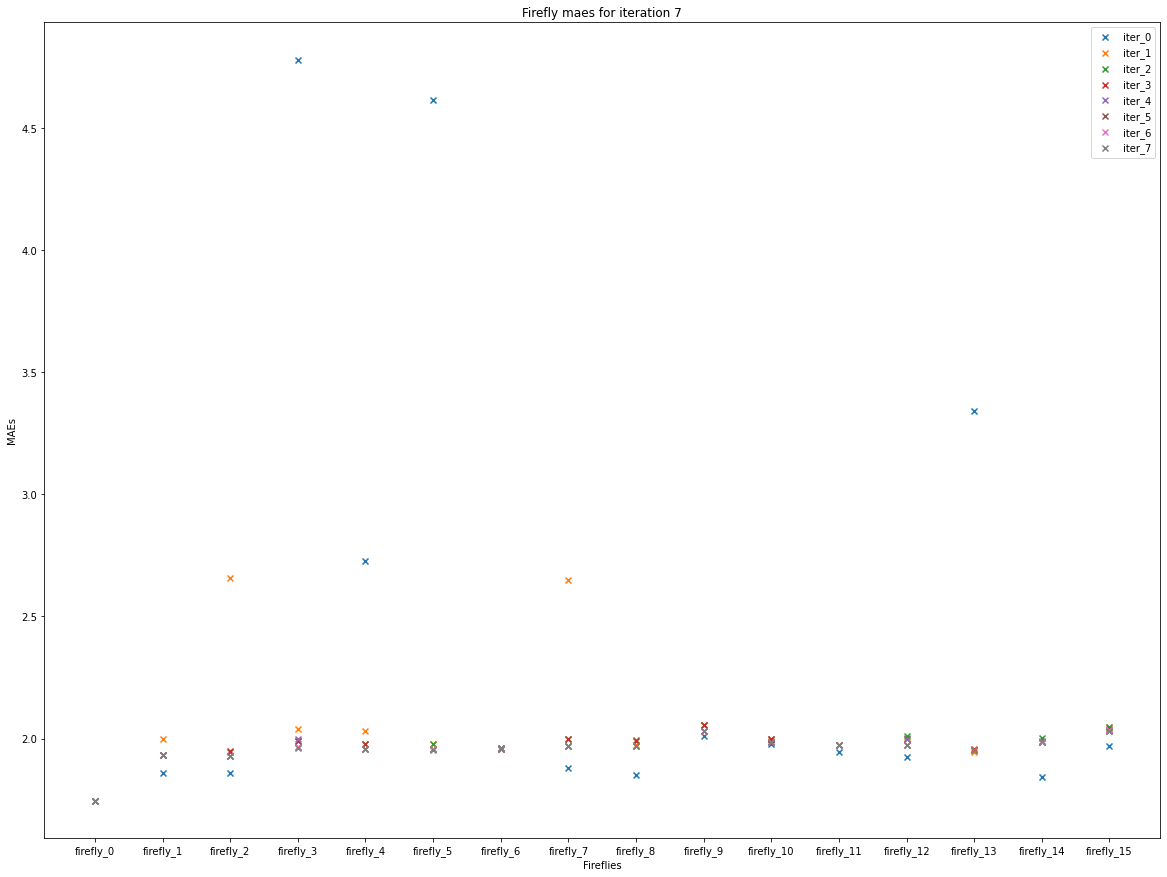

Firefly ran 8 iterations with a population of 16 in 3 days, 0:27:47



In [16]:
num_folds = 3

number_of_iterations = 8
source_intensity = 1

fireflies = population

all_results = [] # will hold array of all the tuples of results + hyper params

#for the number of iterations
print(f"{color.BOLD}Firefly Algorithm hyper parameter optimization{color.END}\n")
start_time = time.time()
for i in tqdm(range(number_of_iterations)):
    
    iteration_results = [] #results of this iteration
    firefly_intensities = [] #corresponding intensities of the fireflies light
    
    #evaluate each firefly
    best_mae = 9999
    best_index = 0
    
    print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}Training the fireflies{color.END}")
    for f in tqdm(range(len(fireflies))):
        
        print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Iteration {i}, Firefly {f}{color.END}")
            
        #getting this models columns
        X_col_groups = fireflies[f][2]
        X_cols = fireflies[f][0]
        this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
        #getting this models hyper parameters
        this_params = fireflies[f][1]
        
        #inspecting
        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Feature groups{color.END}")
        print(X_col_groups)
        print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper parameters{color.END}")
        print(this_params)
        
        #bug in lgbm which occassionally refuses models based on the hypers and the feature fraction value; fixing this by randomising feature fraction if it fails
        fail_counter=1
        while True:
            #try to run this model
            try:
                #training this model and storing its results (excluding the lgbm model itself as was running out of memory)
                this_run = run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params)
                iteration_results.append(((this_run[0],this_run[1]), # MAE and TOE (not this_run[2] (lgbm_models) to stop running out of memory)
                                          (X_cols,this_params,X_col_groups))) # models description so we can train and use the best lgbm models without having to store all in memory
                firefly_intensities.append(1/this_run[1]**2) #calculating the intensity of this firefly via inverse square law and storing it 
                print(f"MAE = {this_run[1]}, TOE = {str(datetime.timedelta(seconds=round(this_run[0])))}, Intensity = {str(1/this_run[1]**2)}\n")
                
                if this_run[1]<best_mae:
                    best_mae = this_run[1]
                    best_index = f
                break
            #if it fails randomise value of feature fraction as it seems the bug that exists in lgbm library that is unpatched is depending on the feature fraction value https://github.com/microsoft/LightGBM/issues/3679
            except:
                print(f"Firefly {f} failed {fail_counter} times")
                random_new_frac=random.randrange(0,100)/100
                print(f"Changing feature fraction from {this_params['feature_fraction']} to {random_new_frac}")
                this_params["feature_fraction"]=random_new_frac
                fail_counter+=1 
        
    #adding this populations results to all_results
    all_results = all_results + iteration_results
    print(f"{color.BOLD}Best results for iteration {i} is {best_mae} from firefly {best_index}{color.END}")

    #visualizing the maes so we can see how they change for each firefly
    plot_firefly_maes = []
    plot_firefly_names = []
    for result_i in range(len(iteration_results)):
        plot_firefly_maes.append(iteration_results[result_i][0][1])
        plot_firefly_names.append("firefly_"+str(result_i))
        
    fig, ax = plt.subplots(figsize=(20,5))
    ax.scatter(plot_firefly_names, plot_firefly_maes)

    for point_index, txt in enumerate(plot_firefly_maes):
        ax.annotate(str("  ")+str(round(txt,2)), (plot_firefly_names[point_index], plot_firefly_maes[point_index]))

    plt.title(f"Firefly maes for iteration {i}")
    plt.xlabel("Fireflies")
    plt.ylabel("MAEs")
    ax.set_xticks(np.arange(len(fireflies)))
    plt.show()
    fig.savefig(f"..\\Results\\Warm Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}__iter{i}_firefly_MAEs.png")
    plt.close()
    plt.close(fig)
    del fig, ax
    gc.collect()

    
    #if this isn't the last iteration...
    if i<number_of_iterations-1:

        #sorting the fireflies in descending order by their intensities (so best firefly at the start)
        print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nSorting the fireflies in order of best intensity{color.END}")
        print("firefly_intensities original order")
        rounded_firefly_intensities = []
        for intensity in firefly_intensities:
            rounded_firefly_intensities.append(round(intensity,4))
        print(rounded_firefly_intensities)
        firefly_ranked_indexes = sorted(range(len(firefly_intensities)), key=lambda k: firefly_intensities[k], reverse=True)
        print("\nfirefly_ranked_indexes")
        print(firefly_ranked_indexes)
        print("\nfirefly ranked intensities")
        rounded_firefly_intensities = []
        for n in firefly_ranked_indexes:
            rounded_firefly_intensities.append(round(firefly_intensities[n],3))
        print(rounded_firefly_intensities)

        #normalizing the intensities
        sum_of_intensities = sum(firefly_intensities)
        firefly_intensities = [float(i)/sum_of_intensities for i in firefly_intensities]

        print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nMoving the fireflies{color.END}")

        #move the fireflies
        new_fireflies = fireflies.copy()
        for a in firefly_ranked_indexes:
            firefly_A = fireflies[a]
            step_size_coef = 1 # decrease this every time we find a better firefly
            for b in firefly_ranked_indexes:
                #if this is the same firefly then skip this iteration
                if a==b:
                    continue
                firefly_B = fireflies[b]
                print(f"{color.BOLD}{color.PURPLE}Firefly_A = {a} MAE = {iteration_results[a][0][1]} | Firefly_B = {b} MAE = {iteration_results[b][0][1]} | B is better than A? {iteration_results[a][0][1] > iteration_results[b][0][1]}{color.END}")


                #move firefly A towards firefly B if it's error is better (smaller)
                if(iteration_results[a][0][1] > iteration_results[b][0][1]):
                    intensity_difference = abs(firefly_intensities[b]-firefly_intensities[a])
                    print(f"{color.YELLOW}Intensity difference between {a} and {b} is {intensity_difference}{color.END}")

                    #iteratively moving the hyper parameters
                    new_a_params = params.copy()
                    for key in tuned_hyper_names:
                        #getting the current param value
                        a_param = new_fireflies[a][1][key] # considering changes 
                        b_param = fireflies[b][1][key] # only original value
                        #updating the value based on the intensity
                        temp_new_param = (1-intensity_difference)*a_param + intensity_difference*b_param
                        new_a_params[key] = (1-step_size_coef)*a_param+step_size_coef*temp_new_param
                        
                        print(f"{key} has changed from {a_param} to {new_a_params[key]} taking a step of size {step_size_coef}")

                        #if this key needs to be a whole number, round it
                        if(key in whole_number_hyper_names):
                            new_a_params[key] = int(max(1,round(new_a_params[key])))
                        #clipping fractional keys between 0 and 1
                        if(key in fractional_hyper_names):
                            new_a_params[key] = float(max(0, min(new_a_params[key],1)))

                    
                    
                    #iteratively moving the columns
                    new_a_cols = []
                    new_a_col_groups = []
                    for key in possible_columns.keys():

                        #generate a random number and accept it if it it is within the difference then take the column from firefly b
                        if(random.random()<step_size_coef):
                            if key in fireflies[b][0]:
                                new_a_col_groups+=[key]
                                new_a_cols+=possible_columns[key]
                                print(f"Decided to start using {key} as firefly {b} uses it")
                            else:
                                print(f"Decided to stop using {key} as firefly {b} doesn't use it")

                        #else keep this column as it is currently in firefly a (inc. if it has been added by a prior firefly)
                        else:
                            if key in new_fireflies[a][0]:
                                new_a_col_groups+=[key]
                                new_a_cols+=possible_columns[key]
                                print(f"Decided to keep using {key} as firefly {a} already uses it")
                            else:
                                print(f"Decided to stop using {key} as firefly {a} doesn't already use it")

                    if(len(new_a_col_groups)<=0):
                        new_key=random.choice(list(possible_columns.keys()))
                        new_a_col_groups=[new_key]
                        new_a_cols+=possible_columns[new_key]
                        print(f"No columns clipping length to 1 so randomly choosing to use {new_key}")
                                
                    step_size_coef/=2# decreasing the step size for the next firefly we find
                    #updating this firefly
                    new_fireflies[a] = (new_a_cols, new_a_params, new_a_col_groups)

#                     break #as we only want to move towards the firefly that is better than us

#         #adding some randomness to this firefly
#         print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}\nAdding Noise to the fireflies{color.END}")
#         for a in range(len(fireflies)):
#             #random noise to hyper parameter with a 1/n chance mutating them by +/- up to 10%
#             print(f"{color.BOLD}{color.PURPLE}Mutating Firefly_A = {a}{color.END}")
#             noisy_a_params = new_fireflies[a][1].copy()
#             for key in tuned_hyper_names:
#                 random_chance = random.randrange(len(tuned_hyper_names))==1
#                 if random_chance:
#                     noisy_a_params[key]*=(random.randrange(90,110)/100)
#                     print(f"randomly added noise to {key} changing it from {new_fireflies[a][1][key]} to {noisy_a_params[key]}")
#                    #if this key needs to be a whole number, round it
#                     if(key in whole_number_hyper_names):
#                         noisy_a_params[key] = int(max(1,round(noisy_a_params[key])))
#                     #clipping fractional keys between 0 and 1
#                     if(key in fractional_hyper_names):
#                         noisy_a_params[key] = float(max(0, min(noisy_a_params[key],1)))
                
#             #random bitflipping of columns (1/n chance)
#             noisy_cols = []
#             noisy_cols_groups = []
#             for key in possible_columns.keys():
#                 random_chance = random.randrange(len(possible_columns.keys()))==1
#                 if random_chance:
#                     if key not in new_fireflies[a][0]:
#                         noisy_cols_groups+=[key]
#                         noisy_cols+=possible_columns[key]
#                         print(f"Decided to start using {key} as firefly {a} doesn't already use it and we are randomly walking")
#                     else:
#                         print(f"Decided to stop using {key} as firefly {a} already uses it and we are randomly walking")
#                 else:
#                     if key in new_fireflies[a][0]:
#                         new_a_col_groups+=[key]
#                         new_a_cols+=possible_columns[key]
# #                         print(f"Decided to keep using {key} as firefly {a} already uses it and we are not randomly changing it")
# #                     else:
# #                         print(f"Decided to keep using {key} as firefly {a} doesn't already use it and we are not randomly changing it")
#             if(len(noisy_cols_groups)<=0):
#                     new_key=random.choice(list(possible_columns.keys()))
#                     noisy_cols_groups=[new_key]
#                     noisy_cols+=possible_columns[new_key]
#                     print(f"No columns clipping length to 1 so randomly choosing to use {new_key}")

#             new_fireflies[a] = (noisy_cols, noisy_a_params, noisy_cols_groups)

        #replacing fireflies with the new ones
        fireflies = new_fireflies.copy()
    print("\n\n\n")
    
#visualizing the maes so we can see how they change for each firefly over the iterations
all_firefly_maes = []
plot_firefly_names = []

for all_result_i in range(number_of_iterations):
    iter_firefly_maes = []
    for iter_result_i in range(len(fireflies)):
        iter_firefly_maes.append(all_results[iter_result_i+(all_result_i*len(fireflies))][0][1])
        if all_result_i == 0:
            plot_firefly_names.append("firefly_"+str(iter_result_i))
            
            
    all_firefly_maes.append(iter_firefly_maes)
    

fig, ax = plt.subplots(figsize=(20,15))

plot_iter=0
for this_firefly_maes in all_firefly_maes:
    ax.scatter(plot_firefly_names, this_firefly_maes, label=f"iter_{plot_iter}",marker="x")
    plot_iter+=1
    


plt.legend()
plt.title(f"Firefly maes for iteration {i}")
plt.xlabel("Fireflies")
plt.ylabel("MAEs")
ax.set_xticks(np.arange(len(fireflies)))
plt.show()
fig.savefig(f"..\\Results\\Warm Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}__all_iters_firefly_MAEs.png")
plt.close()
plt.close(fig)
del fig, ax
gc.collect()

            
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Firefly ran {number_of_iterations} iterations with a population of {population_size} in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n") 

## Visualising information from the firefly algorithm results
### Box plots of the MAE for the different columns

  0%|          | 0/12 [00:00<?, ?it/s]

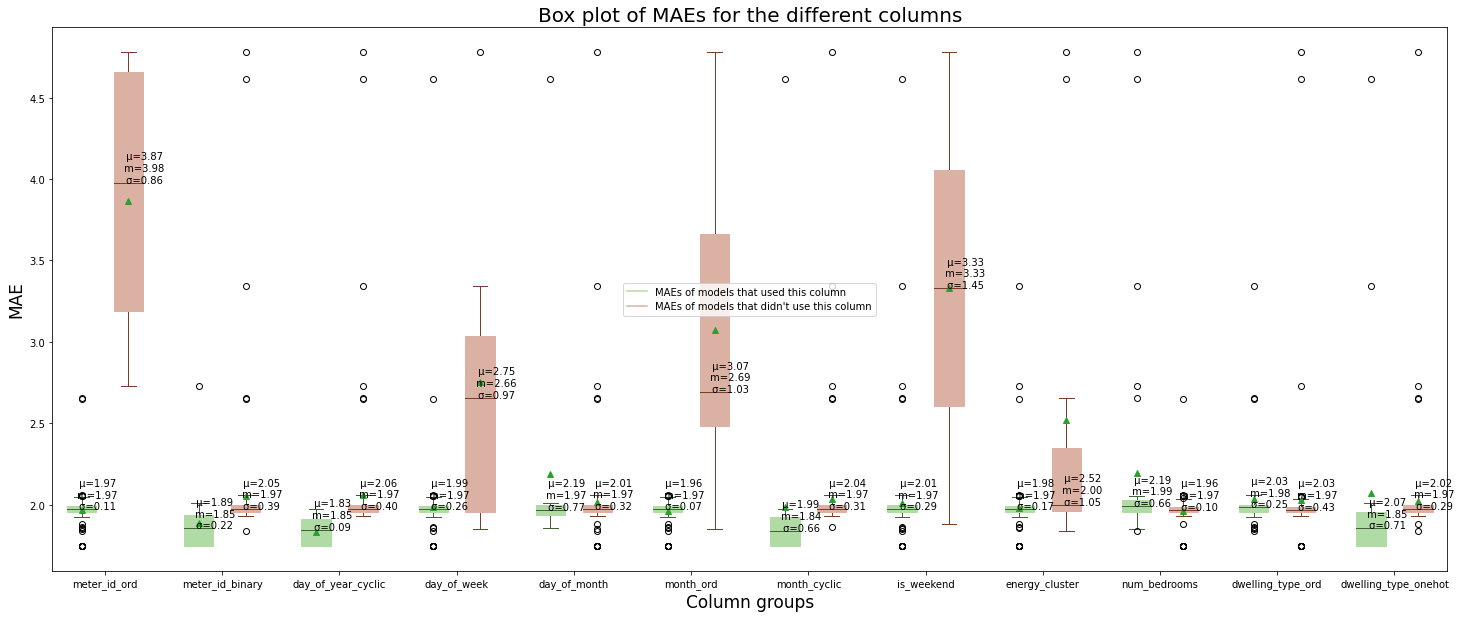

15

In [18]:
columns_maes = {} #dictionary of each columns maes
columnless_mae = {}
#iterating through each column and randomly decide whether or not to pick it
for key in tqdm(possible_columns.keys()):
    column = possible_columns[key][0] # only want to check against one column for the 'in'
    
    # if this column doesn't yet exist in the dict, create it
    if key not in columns_maes:
        columns_maes[key]=[]
    # if this column doesn't yet exist in the dict, create it
    if key not in columnless_mae:
        columnless_mae[key]=[]

    #iterating through every single models results
    for i in range(len(all_results)):
        
        #if this column was used by the model
        if column in all_results[i][1][0]:
            # adding this models mae to the dict entry for this column
            columns_maes[key].append(all_results[i][0][1])
            
        #else this column wasn't used by the model
        else:
            # adding this models mae to the dict entry for this column
            columnless_mae[key].append(all_results[i][0][1])

# print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}MAEs for each model which contains columns of each type{color.END}")
# pprint(columns_maes)

# function for setting the box colour
def set_box_color(bp, color_line, color_fill):
    plt.setp(bp['whiskers'], color=color_line)
    plt.setp(bp['caps'], color=color_line)
    plt.setp(bp['medians'], color=color_line)
    plt.setp(bp['fliers'], color=color_fill)
    plt.setp(bp['boxes'], color=color_fill)
    plt.setp(bp['means'], color=color_line)

    
### plotting a boxplot of these ###
# getting the 2 dicts we will plot
labels, data_columns = columns_maes.keys(), columns_maes.values()
data_columnless = columnless_mae.values()

#plotting these 2 dicts next to each other
fig = plt.figure(figsize=(25,10))
bp_dict_columns = plt.boxplot(data_columns,showmeans=True,positions=np.array(range(len(labels)))*2.0-0.4,patch_artist=True) # getting dictionary returned from boxplot
bp_dict_columnless = plt.boxplot(data_columnless,showmeans=True,positions=np.array(range(len(labels)))*2.0+0.4,patch_artist=True) # getting dictionary returned from boxplot

#colouring them
set_box_color(bp_dict_columns, '#416338','#b0dba4')
set_box_color(bp_dict_columnless, '#783d2b','#dbb1a4')

#annotating the plot
plt.title("Box plot of MAEs for the different columns", fontsize=20)
plt.xlabel("Column groups", fontsize=17)
plt.ylabel("MAE", fontsize=17)

#creating the legend
plt.plot([], c='#b0dba4',label="MAEs of models that used this column")
plt.plot([], c='#dbb1a4',label="MAEs of models that didn't use this column")
plt.legend()


## adding overlayed values to the boxplot

# stats for with columns
column_means = []
column_medians = []
column_std = []
for key in columns_maes.keys():
    column_means.append(np.mean(columns_maes[key]))
    column_medians.append(np.median(columns_maes[key]))
    column_std.append(np.std(columns_maes[key]))
for i, line in enumerate(bp_dict_columns['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(column_means[i], column_medians[i], column_std[i])
    plt.text(x, y, text, horizontalalignment='center')
    
# stats for without columns
columnless_means = []
columnless_medians = []
columnless_std = []
for key in columnless_mae.keys():
    columnless_means.append(np.mean(columnless_mae[key]))
    columnless_medians.append(np.median(columnless_mae[key]))
    columnless_std.append(np.std(columnless_mae[key]))
for i, line in enumerate(bp_dict_columnless['medians']):
    x, y = line.get_xydata()[1]
    text = ' μ={:.2f}\n m={:.2f}\n σ={:.2f}'.format(columnless_means[i], columnless_medians[i], columnless_std[i])
    plt.text(x, y, text, horizontalalignment='center')


plt.xticks(range(0, len(labels)*2,2), labels)

plt.show()

fig.savefig(f"..\\Results\\Warm Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_Box_MAEs.png")

plt.close(fig)
del fig
gc.collect()

## Box and swarm plot to better inspect the distribution

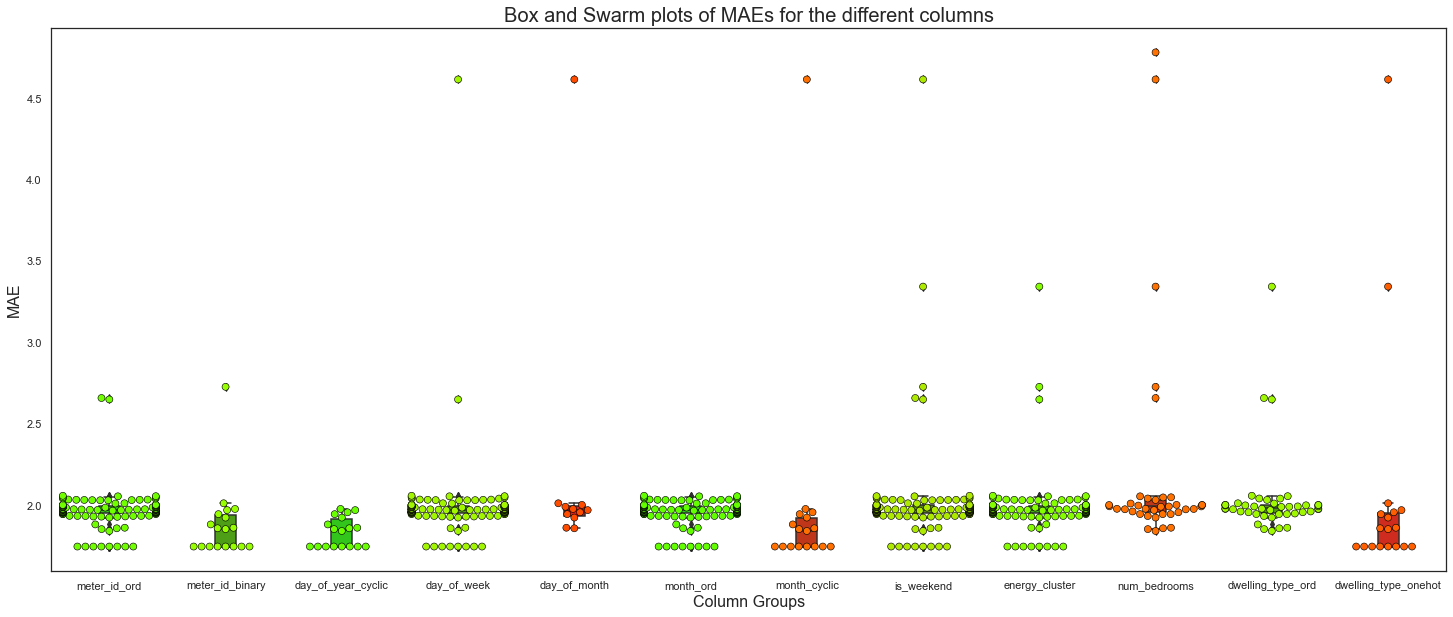

10969

In [19]:
colourBlindFriendly = False # make graph colourBlindFriendly (pink to blue instead of red to green)

#normalizing the std
max_std = max(column_std)
column_std = [float(i)/max_std for i in column_std]

#gradient of green to red based on each columns stats
box_grad_palette = {}
for i in range(len(column_std)):
    box_grad_palette[i] = [column_std[i], 1-column_std[i],1 if colourBlindFriendly else 0] #based on std

fig=plt.figure(figsize=(25,10))
sns.set(context='notebook', style='white')
sns.utils.axlabel(xlabel="Column Groups", ylabel="MAE", fontsize=16)
sns.boxplot(data=list(data_columns), width=.18, palette=box_grad_palette)

#slightly paler gradient to make it stand out from the box
swarm_grad_palette = box_grad_palette.copy()
for i in range(len(swarm_grad_palette)):
    #fading it to white
    #adding to red to make it paler
    swarm_grad_palette[i][0] = swarm_grad_palette[i][0]+0.3 if swarm_grad_palette[i][0]+0.3<1 else 1
    #adding to green to make it paler
    swarm_grad_palette[i][1] = swarm_grad_palette[i][1]+0.3 if swarm_grad_palette[i][1]+0.3<1 else 1
    #adding to blue to make it paler
    if colourBlindFriendly:
        swarm_grad_palette[i][2] = swarm_grad_palette[i][2]+0.3 if swarm_grad_palette[i][2]+0.3<1 else 1


sns.swarmplot(data=list(data_columns), size=7, edgecolor="black", linewidth=.6, palette=swarm_grad_palette)

plt.xticks(plt.xticks()[0], labels)

plt.title("Box and Swarm plots of MAEs for the different columns", fontsize=20)

plt.show()
fig.savefig(f"..\\Results\\Warm Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_BoxSwarm_MAEs_GRAD_STD.png")
plt.close(fig)
del fig
gc.collect()

### Main Effects Plots

  0%|          | 0/8 [00:00<?, ?it/s]

learning_rate       MAE
38          0.034  1.778812

[array([0.034])]


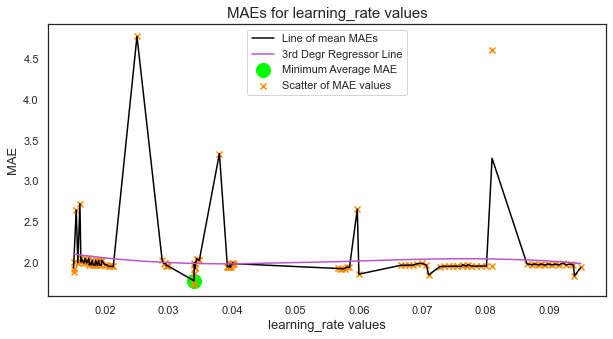

num_leaves       MAE
71       958.0  1.757685

[array([0.034]), array([958.])]


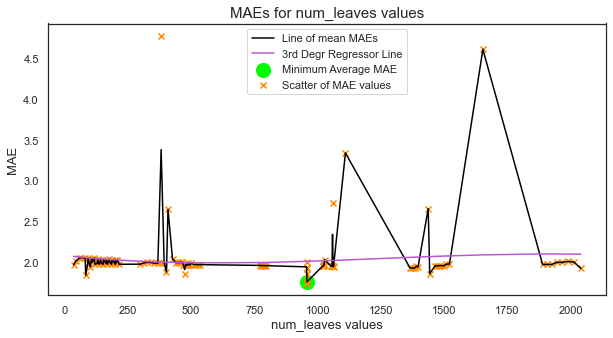

max_depth       MAE
3       10.0  1.878639

[array([0.034]), array([958.]), array([10.])]


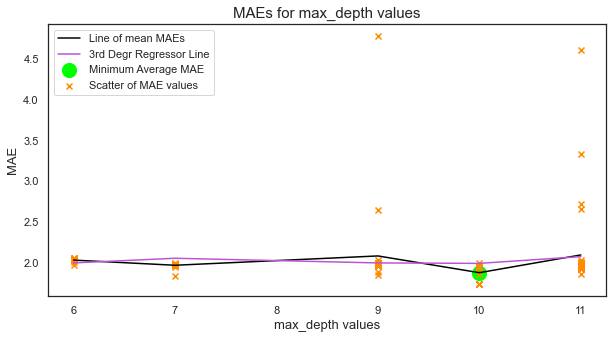

bagging_fraction       MAE
67              0.87  1.757685

[array([0.034]), array([958.]), array([10.]), array([0.87])]


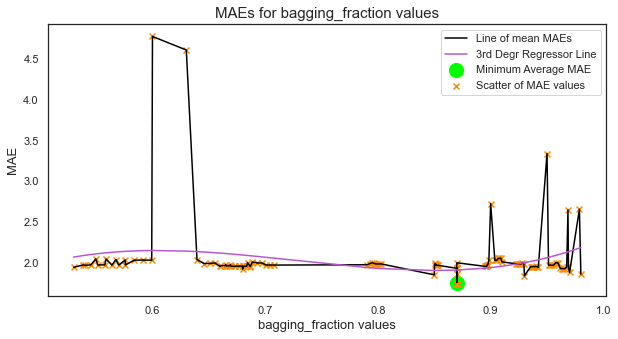

bagging_freq       MAE
7          18.0  1.904777

[array([0.034]), array([958.]), array([10.]), array([0.87]), array([18.])]


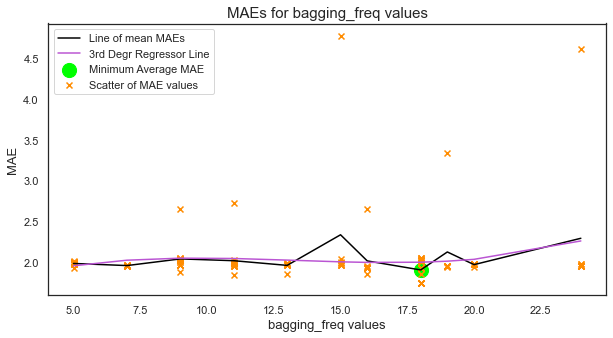

feature_fraction       MAE
2              0.56  1.850742

[array([0.034]), array([958.]), array([10.]), array([0.87]), array([18.]), array([0.56])]


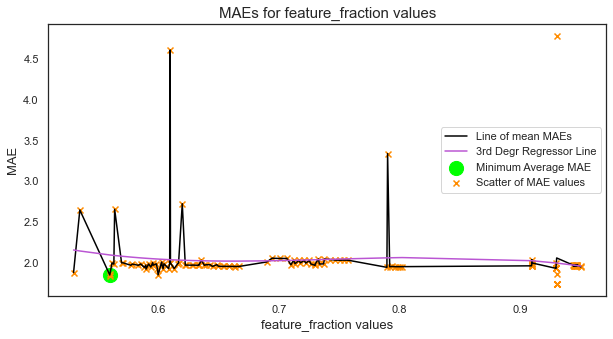

lambda_l1       MAE
1        7.0  1.914783

[array([0.034]), array([958.]), array([10.]), array([0.87]), array([18.]), array([0.56]), array([7.])]


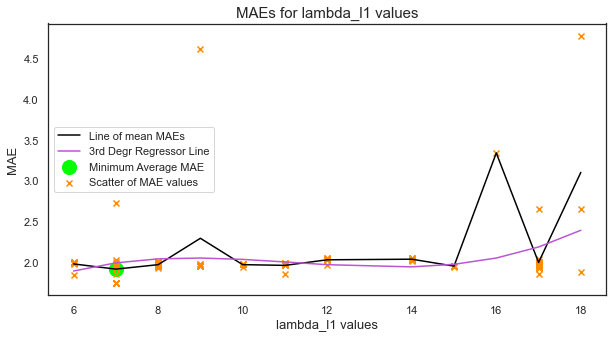

lambda_l2       MAE
5       14.0  1.961029

[array([0.034]), array([958.]), array([10.]), array([0.87]), array([18.]), array([0.56]), array([7.]), array([14.])]


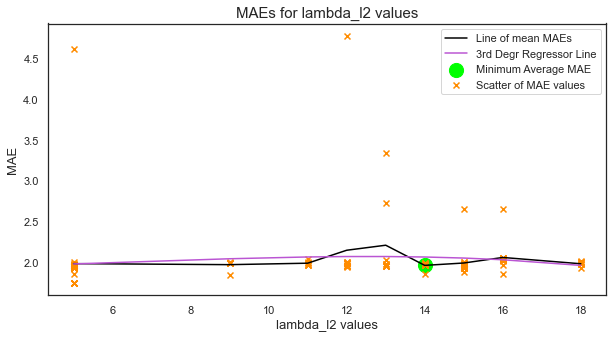

In [20]:
#array of the hyperparameters we tuned
arr_hypers = ["learning_rate","num_leaves","max_depth","bagging_fraction","bagging_freq","feature_fraction","lambda_l1","lambda_l2"]
arr_best_hypers = []
#iterate through each of these hypers
for hyper in tqdm(arr_hypers):

    df_max_depth = pd.DataFrame(columns = [hyper,"MAE"])

    #iterating through each column and randomly decide whether or not to pick it
    #iterating through every single models results
    for i in range(len(all_results)):
        # adding this models mae to the dict entry for this column
        df_max_depth.loc[i] = [all_results[i][1][1][hyper],all_results[i][0][1]]

    #sort in ascending order by the params values
    df_all = df_max_depth.sort_values(by=[hyper])
    # display(df_all)

    #grouping together by value and calculating mean
    grouped_df = df_all.groupby(hyper)
    mean_df = grouped_df.mean().reset_index()
    #display(mean_df)
    
    # the minimum point
    df_min = mean_df[mean_df['MAE']==mean_df['MAE'].min()]
    arr_best_hypers.append(df_min[hyper].values)
    display(df_min)

    #plotting the stats for this param 
    fig = plt.figure(figsize=(10,5))
    print(arr_best_hypers)
    
    plt.scatter(df_min[hyper], df_min.MAE, label="Minimum Average MAE", color="lime", marker="o",s=200)
    plt.plot(mean_df[hyper], mean_df.MAE, label="Line of mean MAEs", color="black") # line of means
    plt.scatter(df_all[hyper], df_all.MAE, label="Scatter of MAE values", color="darkorange", marker="x") # scatter of values
    plt.plot(np.unique(df_all[hyper]), 
             np.poly1d(np.polyfit(df_all[hyper], df_all.MAE, 3))
             (np.unique(df_all[hyper])), label="3rd Degr Regressor Line", color="mediumorchid") # line of best fit from a simple regressor

    plt.title(f"MAEs for {hyper} values", fontsize=15)
    plt.xlabel(f"{hyper} values", fontsize=13)
    plt.ylabel("MAE", fontsize=13)
    
    plt.legend()

    plt.show()
    fig.savefig(f"..\\Results\\Warm Firefly Algorithm\\Plots\\f{population_size}_i{number_of_iterations}_scatter_{hyper}.png")
    plt.close(fig)
    del fig
    gc.collect()

### inspecting stats on all models TOE and MAE

In [21]:
#inspecting the min/max/mean of time of execution of the models we tested in firefly algorithm
all_toes = []
all_maes = [] 

for i in range(len(all_results)):
    #getting the results for this model
    all_toes.append(all_results[i][0][0])
    all_maes.append(all_results[i][0][1])
    
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min time of execution = {color.END}{str(datetime.timedelta(seconds=round(min(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max time of execution = {color.END}{str(datetime.timedelta(seconds=round(max(all_toes))))}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean time of execution = {color.END}{str(datetime.timedelta(seconds=round(np.mean(all_toes))))}")
print()
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}min MAE = {color.END}{min(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}max MAE= {color.END}{max(all_maes)}")
print(f"{color.BOLD}{color.GREEN}{color.UNDERLINE}mean MAE = {color.END}{np.mean(all_maes)}")


min time of execution = 0:00:34
max time of execution = 2:09:32
mean time of execution = 0:33:58

min MAE = 1.7452173623975176
max MAE= 4.7800872470200435
mean MAE = 2.0289567426460735


## Inspecting the results of the hyper parameter optimization

In [22]:
best_index = 0
best_mae = 999999

for i in range(len(all_results)):
    #getting the results for this model
    LGBM_TOE = all_results[i][0][0]
    LGBM_MAE = all_results[i][0][1]
    #displaying the results
    print(f"{color.BOLD}{color.RED}{color.UNDERLINE}iteration {int(i/population_size)} individual {i%population_size} {color.END}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:{color.END} {str(datetime.timedelta(seconds=round(LGBM_TOE)))}")
    print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {LGBM_MAE}")
    print("")
    
    #keeping track of the best performing model
    if(LGBM_MAE<best_mae):
        best_mae=LGBM_MAE
        best_index = i
print("best model is at iteration",int(best_index/population_size),"individual",best_index%population_size,"with a MAE of",best_mae)

iteration 0 individual 0 
Time of execution for skf-cv: 1:02:29
Mean absolute error between OOF preds and meter_reading on training set: 1.7452173623975176

iteration 0 individual 1 
Time of execution for skf-cv: 0:41:55
Mean absolute error between OOF preds and meter_reading on training set: 1.8574224029567745

iteration 0 individual 2 
Time of execution for skf-cv: 1:15:41
Mean absolute error between OOF preds and meter_reading on training set: 1.860704092174566

iteration 0 individual 3 
Time of execution for skf-cv: 0:00:34
Mean absolute error between OOF preds and meter_reading on training set: 4.7800872470200435

iteration 0 individual 4 
Time of execution for skf-cv: 1:05:02
Mean absolute error between OOF preds and meter_reading on training set: 2.7260851289410333

iteration 0 individual 5 
Time of execution for skf-cv: 0:02:50
Mean absolute error between OOF preds and meter_reading on training set: 4.613847044301183

iteration 0 individual 6 
Time of execution for skf-cv: 1:00

Time of execution for skf-cv: 0:39:14
Mean absolute error between OOF preds and meter_reading on training set: 1.969957754724167

iteration 4 individual 8 
Time of execution for skf-cv: 0:27:06
Mean absolute error between OOF preds and meter_reading on training set: 1.9707881907461973

iteration 4 individual 9 
Time of execution for skf-cv: 0:33:31
Mean absolute error between OOF preds and meter_reading on training set: 2.030562716540587

iteration 4 individual 10 
Time of execution for skf-cv: 0:34:53
Mean absolute error between OOF preds and meter_reading on training set: 1.986760693330943

iteration 4 individual 11 
Time of execution for skf-cv: 0:05:42
Mean absolute error between OOF preds and meter_reading on training set: 1.9745840719516146

iteration 4 individual 12 
Time of execution for skf-cv: 0:56:21
Mean absolute error between OOF preds and meter_reading on training set: 1.9978150973808075

iteration 4 individual 13 
Time of execution for skf-cv: 0:31:42
Mean absolute error

## Training a model based on the best models 
* Done this as no longer storing the models in memory as was running out
* So instead just storing the configuration
* Then this is used to retrain a model with that configuration
    * Should fix the problem of running out of memory whilst running the FA

In [23]:
#no longer need all results only the best one
best_results = all_results[best_index]
del all_results
gc.collect()

20

In [24]:
best_X_cols = best_results[1][0]
best_X_cats = list(set(best_X_cols).intersection(all_cat)) #getting the categorical values for this X
best_params = best_results[1][1]
best_run = run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, best_X_cols, best_X_cats, best_params)

Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.93
[LightGBM] [Warning] lambda_l1 is set=7, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7
[LightGBM] [Warning] bagging_fraction is set=0.87, subsample=1.0 will be ignored. Current value: bagging_fraction=0.87
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] lambda_l2 is set=5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5
[LightGBM] [Warning] bagging_freq is set=18, subsample_freq=0 will be ignored. Current value: bagging_freq=18
Training until validation scores don't improve for 250 rounds
[3333]	valid_0's l1: 1.79384
[6666]	valid_0's l1: 1.76425
[9999]	valid_0's l1: 1.74753
Did not meet early stopping. Best iteration is:
[10000]	valid_0's l1: 1.74752
Fold 2
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.93, colsample_bytree=

## Making predictions on best model

In [25]:
#making predictions based on the best performing model and displaying it's information
BEST_LGBM_MODELS = best_run[2] #getting the lgbm_models from the best index
BEST_LGBM_FORECASTS = df_preds.copy()
start_time = time.time() 

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(BEST_LGBM_MODELS)):
    pred_forecasts = BEST_LGBM_MODELS[i].predict(BEST_LGBM_FORECASTS[best_results[1][0]], num_iteration=BEST_LGBM_MODELS[i].best_iteration_) #predicting the unkown df_preds
    BEST_LGBM_FORECASTS[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
BEST_LGBM_FORECASTS["meter_reading"] = BEST_LGBM_FORECASTS.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0
execution_time = time.time() - start_time

## Inspecting information on best model

In [26]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}best model came from iteration {int(best_index/population_size)} individual {best_index%population_size}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for skf-cv:  {color.END}{str(datetime.timedelta(seconds=round(best_results[0][0])))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Time of execution for predictions: {color.END}{str(datetime.timedelta(seconds=round(execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Total time of execution: {color.END}{str(datetime.timedelta(seconds=round(best_results[0][0]+execution_time)))}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {best_results[0][1]}\n")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}preds set with the next years forecasts for each meter{color.END}")
display(BEST_LGBM_FORECASTS[["meter_id","date","meter_reading"]])
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(best_results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(best_results[1][1])

best model came from iteration 0 individual 0
Evaluation and results
Time of execution for skf-cv:  1:02:29

Time of execution for predictions: 1:22:08

Total time of execution: 2:24:36

Mean absolute error between OOF preds and meter_reading on training set: 1.7452173623975176

preds set with the next years forecasts for each meter


meter_id       date  meter_reading
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-01       6.272316
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-02       6.248647
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-03       5.902878
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-04       5.674856
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7 2018-01-05       5.827339
...                                             ...        ...            ...
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-27      20.822624
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-28      18.667341
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-29      17.444106
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-30      16.442387
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd 2018-12-31      16.306637

[1185520 rows x 3 columns]

Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'month_ord',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.87,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.93,
 'lambda_l1': 7,
 'lambda_l2': 5,
 'learning_rate': 0.034,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}


## Saving the description of the best model

In [27]:
BEST_LGBM_FORECASTS.to_pickle(f"..\\Results\\Warm Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_daily_forecasts.pkl")

In [28]:
import pickle

desc_disc = {
    "time_of_execution_skf-cv":str(datetime.timedelta(seconds=round(best_results[0][0]))),
    "time_of_execution_preds":str(datetime.timedelta(seconds=round(execution_time))),
    "time_of_execution_total":str(datetime.timedelta(seconds=round(best_results[0][0]+execution_time))),
    "MAE":best_results[0][1],
    "features":best_results[1][0],
    "params":best_results[1][1]
}

with open(f"..\\Results\\Warm Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Warm Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

{'MAE': 1.7452173623975176,
 'features': ['meter_id_ord',
              'meter_id_0',
              'meter_id_1',
              'meter_id_2',
              'meter_id_3',
              'meter_id_4',
              'meter_id_5',
              'meter_id_6',
              'meter_id_7',
              'meter_id_8',
              'meter_id_9',
              'meter_id_10',
              'meter_id_11',
              'meter_id_12',
              'day_of_year_sin',
              'day_of_year_cos',
              'day_of_week',
              'month_ord',
              'month_sin',
              'month_cos',
              'is_weekend',
              'energy_cluster',
              'detached',
              'flat',
              'semi_detached',
              'terraced'],
 'params': {'bagging_fraction': 0.87,
            'bagging_freq': 18,
            'boosting_type': 'gbdt',
            'feature_fraction': 0.93,
            'lambda_l1': 7,
            'lambda_l2': 5,
            'learning_rate': 0.0

# Converting into monthly forecasts

In [29]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

meter_id         Jan         Feb  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c  140.076202  121.386040   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82  708.822999  647.489192   
2     0x0019979ee12c59accd24d1c83291528ced1bb734  268.749525  216.001941   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a  178.079327  147.515469   
4     0x005958406351bb29580475df698b5f1070096397  370.115539  339.639398   
...                                          ...         ...         ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f  190.844483  157.842626   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  682.212575  625.338724   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  520.974368  429.663186   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  417.534496  374.876722   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  273.297944  235.244634   

             Mar         Apr         May         Jun         Jul         Aug  \
0     115.584001  110.417893  117.472436  118.866503  120.631991  123.039800   
1     607.768041  506.191614  471.714354  418.376209  400.899415  425.185674   
2     221.566506  211.555764  204.385542  195.723127  190.929670  202.216226   
3     144.811871  125.925252  135.157143  131.397722  126.932926  132.037112   
4     363.687345  304.136435  286.177533  275.564229  263.765584  273.848206   
...          ...         ...         ...         ...         ...         ...   
3243  160.176891  141.666167  140.397222  134.712810  134.281379  136.143137   
3244  722.168153  680.442572  590.392360  461.616934  458.917164  469.906785   
3245  415.340161  376.216333  347.595125  268.581470  276.432751  276.324798   
3246  340.471390  368.929872  219.482992  199.859985  192.320429  201.283192   
3247  244.613434  220.774982  221.803794  208.592516  217.719441  221.240783   

             Sep         Oct         Nov         Dec  
0     122.294225  125.392678  101.400632  112.749588  
1     490.196963  546.967092  609.272266  645.815762  
2     201.247863  206.033785  209.574383  232.753497  
3     131.982618  147.036376  147.002375  158.611314  
4     282.312514  328.247717  351.269744  385.790969  
...          ...         ...         ...         ...  
3243  134.157014  149.893899  157.188488  170.010028  
3244  519.583966  577.237958  573.983443  620.560574  
3245  293.014059  340.690851  425.303035  519.421946  
3246  225.413744  270.974364  311.046248  390.204275  
3247  226.521541  238.035367  239.470420  242.410454  

[3248 rows x 13 columns]

## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [30]:
df_monthly_forecasts.to_csv(f"..\\Results\\Warm Firefly Algorithm\\f{population_size}_i{number_of_iterations}_best_model_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [31]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

meter_id     2018-01     2018-02  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c  140.076202  121.386040   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82  708.822999  647.489192   
2     0x0019979ee12c59accd24d1c83291528ced1bb734  268.749525  216.001941   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a  178.079327  147.515469   
4     0x005958406351bb29580475df698b5f1070096397  370.115539  339.639398   
...                                          ...         ...         ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f  190.844483  157.842626   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  682.212575  625.338724   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  520.974368  429.663186   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  417.534496  374.876722   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  273.297944  235.244634   

         2018-03     2018-04     2018-05     2018-06     2018-07     2018-08  \
0     115.584001  110.417893  117.472436  118.866503  120.631991  123.039800   
1     607.768041  506.191614  471.714354  418.376209  400.899415  425.185674   
2     221.566506  211.555764  204.385542  195.723127  190.929670  202.216226   
3     144.811871  125.925252  135.157143  131.397722  126.932926  132.037112   
4     363.687345  304.136435  286.177533  275.564229  263.765584  273.848206   
...          ...         ...         ...         ...         ...         ...   
3243  160.176891  141.666167  140.397222  134.712810  134.281379  136.143137   
3244  722.168153  680.442572  590.392360  461.616934  458.917164  469.906785   
3245  415.340161  376.216333  347.595125  268.581470  276.432751  276.324798   
3246  340.471390  368.929872  219.482992  199.859985  192.320429  201.283192   
3247  244.613434  220.774982  221.803794  208.592516  217.719441  221.240783   

         2018-09     2018-10     2018-11     2018-12  
0     122.294225  125.392678  101.400632  112.749588  
1     490.196963  546.967092  609.272266  645.815762  
2     201.247863  206.033785  209.574383  232.753497  
3     131.982618  147.036376  147.002375  158.611314  
4     282.312514  328.247717  351.269744  385.790969  
...          ...         ...         ...         ...  
3243  134.157014  149.893899  157.188488  170.010028  
3244  519.583966  577.237958  573.983443  620.560574  
3245  293.014059  340.690851  425.303035  519.421946  
3246  225.413744  270.974364  311.046248  390.204275  
3247  226.521541  238.035367  239.470420  242.410454  

[3248 rows x 13 columns]

## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [32]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = BEST_LGBM_FORECASTS.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

meter_id  2018-01-01 00:00:00  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c             4.945189   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82            19.623844   
2     0x0019979ee12c59accd24d1c83291528ced1bb734             8.997209   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a             6.399480   
4     0x005958406351bb29580475df698b5f1070096397            12.375379   
...                                          ...                  ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f             6.402080   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb            22.970346   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5            19.551406   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02            13.051071   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4             8.506305   

      2018-01-02 00:00:00  2018-01-03 00:00:00  2018-01-04 00:00:00  \
0                4.671512             4.202454             4.539602   
1               21.837937            22.354535            21.008771   
2                9.666831             9.254574             9.194762   
3                6.284248             5.639768             5.922533   
4               12.571615            11.675592            11.453176   
...                   ...                  ...                  ...   
3243             6.420091             6.106932             6.310180   
3244            23.678414            22.933031            22.371048   
3245            18.768429            17.462476            16.651114   
3246            13.454416            13.655114            13.155370   
3247             8.717043             8.483861             8.558756   

      2018-01-05 00:00:00  2018-01-06 00:00:00  2018-01-07 00:00:00  \
0                4.819104             5.089369             5.016525   
1               22.279389            23.766824            23.848451   
2                9.060959             9.357708             8.587203   
3                5.984615             6.441480             6.351635   
4               11.203785            12.025199            12.118260   
...                   ...                  ...                  ...   
3243             6.683443             6.495480             6.603492   
3244            21.327872            21.716549            21.557777   
3245            16.455308            16.637636            17.501346   
3246            13.164218            13.342574            13.525373   
3247             9.037985             8.645444             8.401925   

      2018-01-08 00:00:00  2018-01-09 00:00:00  ...  2018-12-22 00:00:00  \
0                4.539180             4.521331  ...             3.801700   
1               22.987407            23.378299  ...            23.890691   
2                8.564831             8.513424  ...             7.802671   
3                5.596270             5.593457  ...             5.245611   
4               10.446923            11.207761  ...            13.399066   
...                   ...                  ...  ...                  ...   
3243             6.562441             6.786928  ...             5.439414   
3244            21.051980            21.743865  ...            18.757392   
3245            17.461901            15.833297  ...            15.356468   
3246            13.555292            12.970917  ...            12.524586   
3247             9.074445             9.070867  ...             7.687474   

      2018-12-23 00:00:00  2018-12-24 00:00:00  2018-12-25 00:00:00  \
0                3.445925             3.367698             3.147101   
1               22.807691            20.327068            18.709093   
2                7.763239             7.766354             7.700855   
3                4.729854             3.995926             4.515604   
4               12.423272            10.480623             9.916612   
...                   ...                  ...                  ...   
3243             5.346363             5.220013 

## loading training data and aggregating into months

In [33]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

training data


  0%|          | 0/12 [00:00<?, ?it/s]

meter_id  2017-01-01  2017-01-02  \
0     0xa62b9f23553ff183f61e2bf943aab3d5983d02d7       0.000       0.000   
1     0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da       0.000       0.000   
2     0x4a1ed36825360a058cec2bdd409fc2459e1ce54f       0.000       0.000   
3     0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407       0.000       0.000   
4     0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f       0.000       0.000   
...                                          ...         ...         ...   
3243  0x7dd7a7b8ee1bec7c44b24f738c752482f6161065       2.317       2.301   
3244  0xfdaf9f857621ec06f2cf801f42a020a322835090      14.437      16.274   
3245  0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18       7.824       7.517   
3246  0x47218b46abb2fcaade487a211911406dc6e13730      23.965      28.689   
3247  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd      11.302      14.178   

      2017-01-03  2017-01-04  2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
0          0.000       0.000       0.000       0.000       0.000       0.000   
1          0.000       0.000       0.000       0.000       0.000       0.000   
2          0.000       0.000       0.000       0.000       0.000       0.000   
3          0.000       0.000       0.000       0.000       0.000       0.000   
4          0.000       0.000       0.000       0.000       0.000       0.000   
...          ...         ...         ...         ...         ...         ...   
3243       2.352       2.516       2.229       2.354       2.397       2.397   
3244       7.031      17.018      17.603      15.005       8.987       8.490   
3245       5.398       6.788       7.360       6.898       7.321       8.042   
3246      27.664      29.229      29.548      27.909      26.923      21.277   
3247      15.499      11.853      17.431      14.506      12.812      10.472   

      2017-01-09  ...  2017-12-22  2017-12-23  2017-12-24  2017-12-25  \
0          0.000  ...       4.030       5.397      5.1075       4.818   
1          0.000  ...      13.101      14.327     14.6315      14.936   
2          0.000  ...      10.201       7.320      7.3520       7.384   
3          0.000  ...      14.833      12.477     11.7255      10.974   
4          0.000  ...      39.440      35.538     21.9445       8.351   
...          ...  ...         ...         ...         ...         ...   
3243       2.269  ...       9.390       9.231      9.2235       9.216   
3244      10.136  ...       4.141       2.828      3.8230       4.818   
3245       8.207  ...       6.767       5.919      5.9980       6.077   
3246      23.452  ...      20.747      19.979     20.1925      20.406   
3247      10.879  ...      14.036      15.990     15.5505      15.111   

      2017-12-26  2017-12-27  2017-12-28  2017-12-29  2017-12-30  2017-12-31  
0          3.931      4.2170       4.503      4.8160       5.129       5.395  
1         16.174     20.3960      24.618     19.8925      15.167      11.751  
2         14.425     16.0650      17.705     13.3355       8.966       4.633  
3         19.646     21.8195      23.993     19.9170      15.841      14.452  
4          9.957     17.9140      25.871     36.0725      46.274      16.901  
...          ...         ...         ...         ...         ...         ...  
3243       9.336      9.6840      10.032      9.8945       9.757       9.480  
3244       3.357      8.1315      12.906      8.0140       3.122       3.401  
3245       7.761      6.6080       5.455      5.5670       5.679       8.148  
3246      23.668     27.7900      31.912     29.1125      26.313      24.201  
3247      16.506     18.7585      21.011     19.2040      17.397      15.237  

[3248 rows x 366 columns]

meter_id   2017-01  2017-02   2017-03  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c    0.0000    0.000    0.0000   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82    0.0000    0.000    0.0000   
2     0x0019979ee12c59accd24d1c83291528ced1bb734    0.0000    0.000    0.0000   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a    0.0000    0.000    0.0000   
4     0x005958406351bb29580475df698b5f1070096397    0.0000    0.000    0.0000   
...                                          ...       ...      ...       ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f   72.7050   63.245   68.4335   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  371.4390  269.691  179.3430   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  209.8065  169.858  184.0130   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  845.6630  608.449  588.7765   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  428.7345  670.505  462.1050   

       2017-04   2017-05  2017-06   2017-07   2017-08   2017-09     2017-10  \
0       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
1       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
2       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
3       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
4       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
...        ...       ...      ...       ...       ...       ...         ...   
3243   66.6265   69.0480  100.430  177.1735  177.4100  216.7245  279.164500   
3244  141.6590  138.4835  122.910  164.2285  100.9610  118.0520  123.135500   
3245  166.7280  134.1760  169.489  157.5775  165.9640  177.0105  185.701833   
3246  503.3050  291.1320  177.605  183.5345  182.0350  244.2255  371.458333   
3247  354.8660  287.9950  200.321  227.0855  231.7585  246.3005  344.210167   

         2017-11    2017-12  
0       0.000000  128.39450  
1       0.000000  553.18400  
2       0.000000  368.90957  
3       0.000000  534.84650  
4       0.000000  946.06400  
...          ...        ...  
3243  351.481000  312.08800  
3244  187.140000  186.88400  
3245  192.288667  200.61950  
3246  695.878667  858.83950  
3247  516.290333  734.61800  

[3248 rows x 13 columns]

## Plotting the predictions against the training data

  0%|          | 0/3248 [00:00<?, ?it/s]

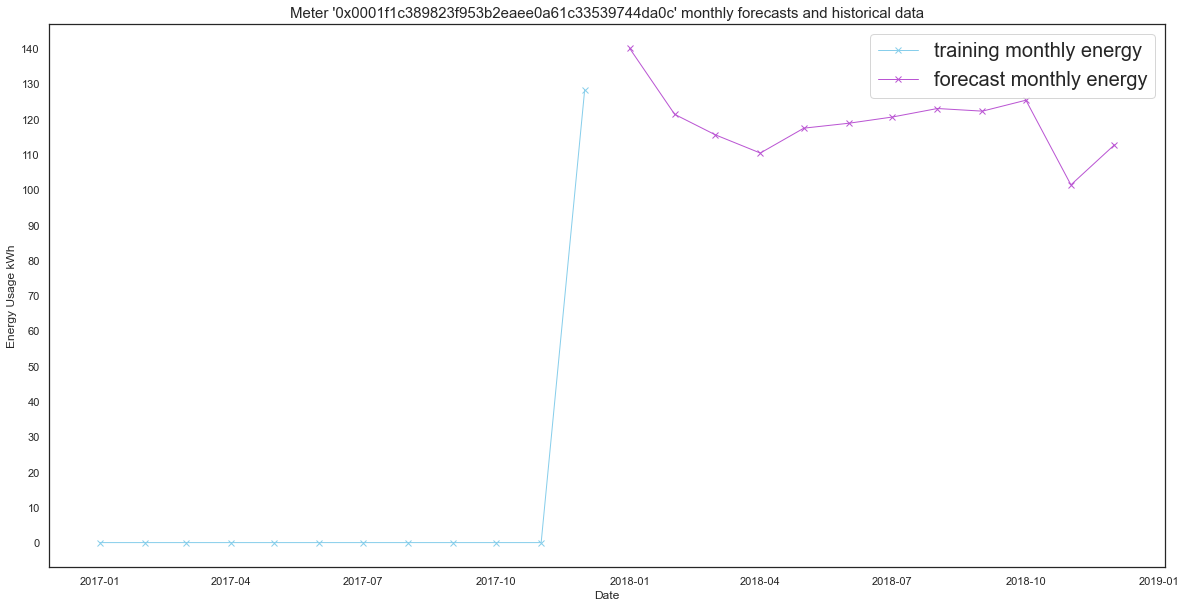

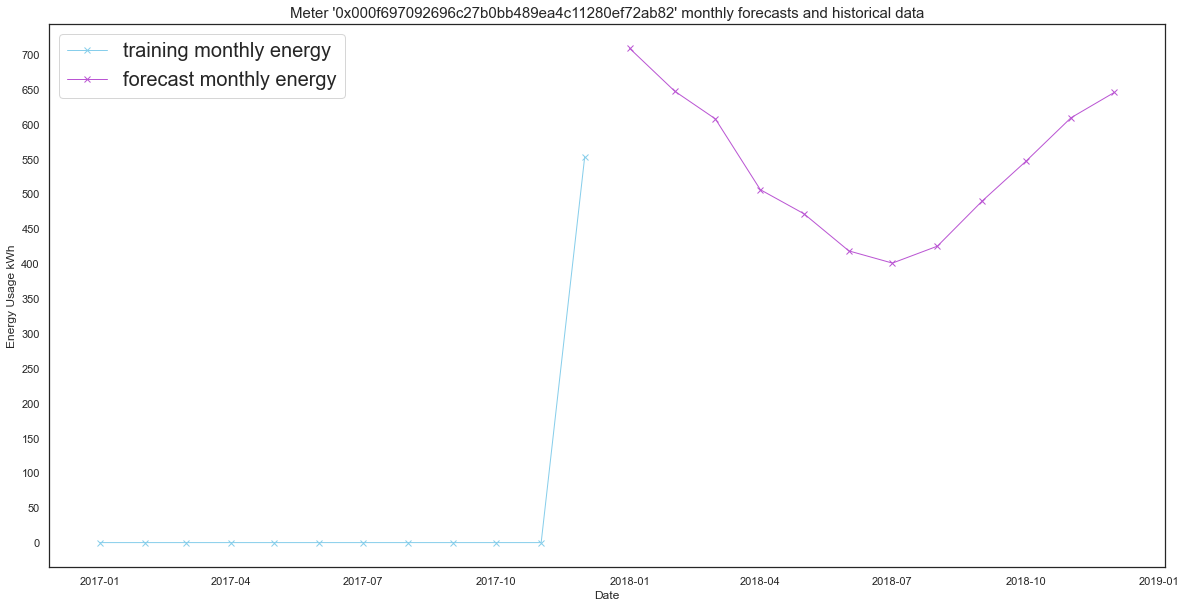

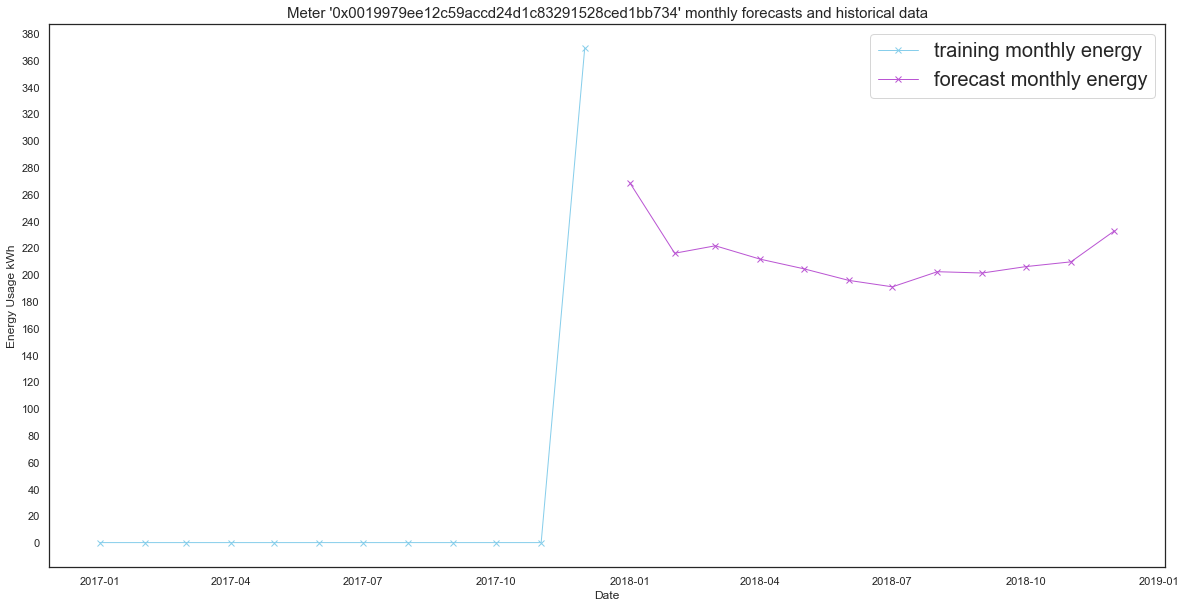

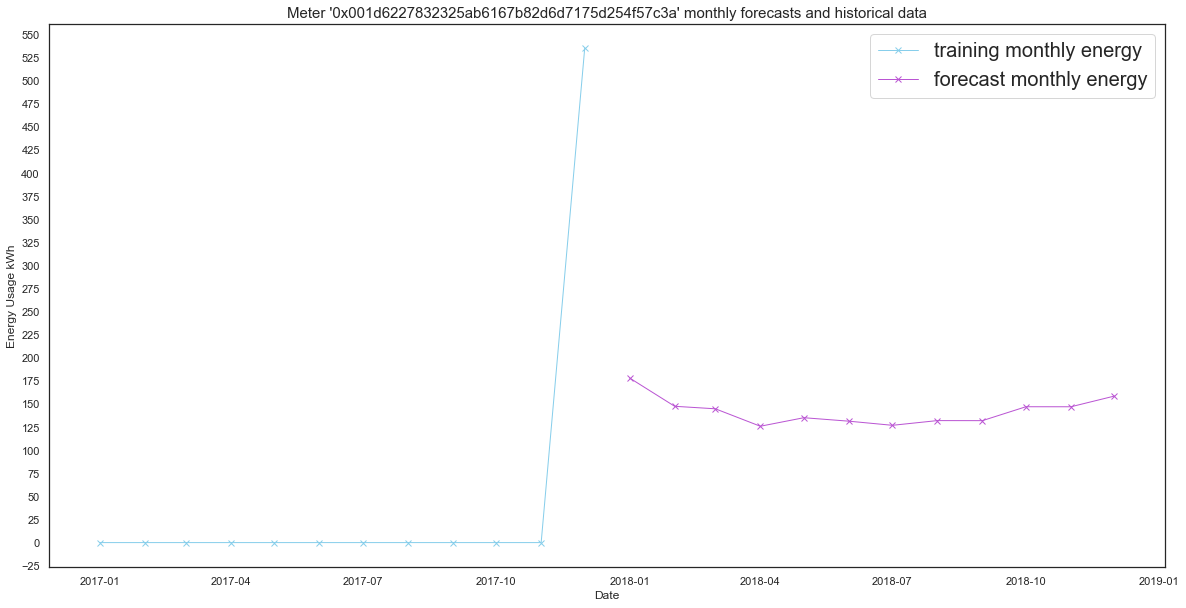

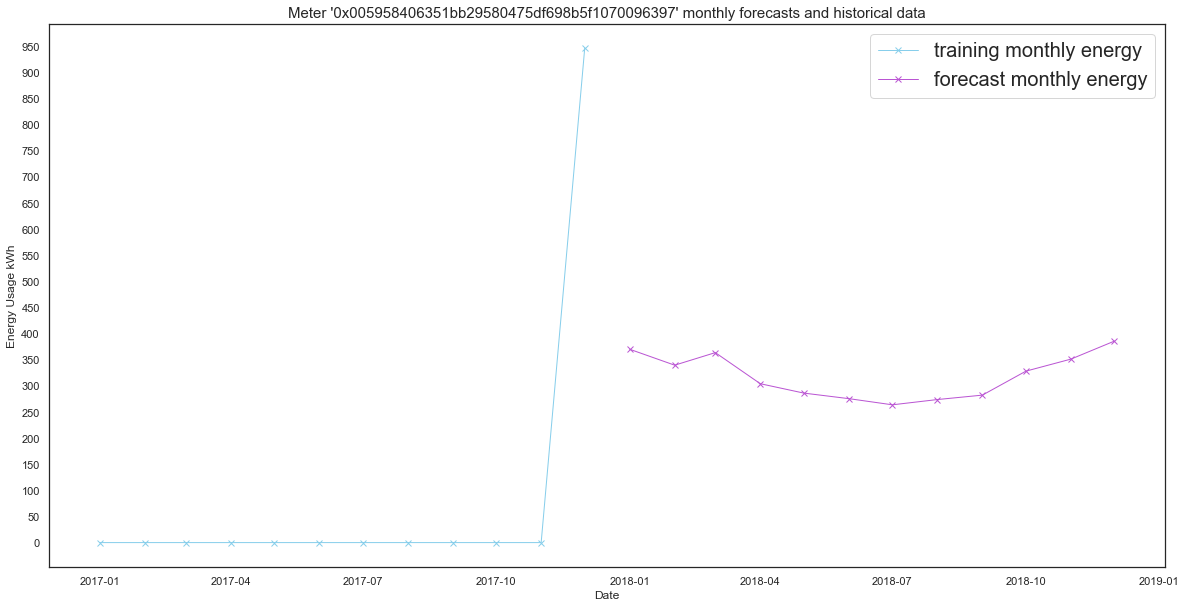

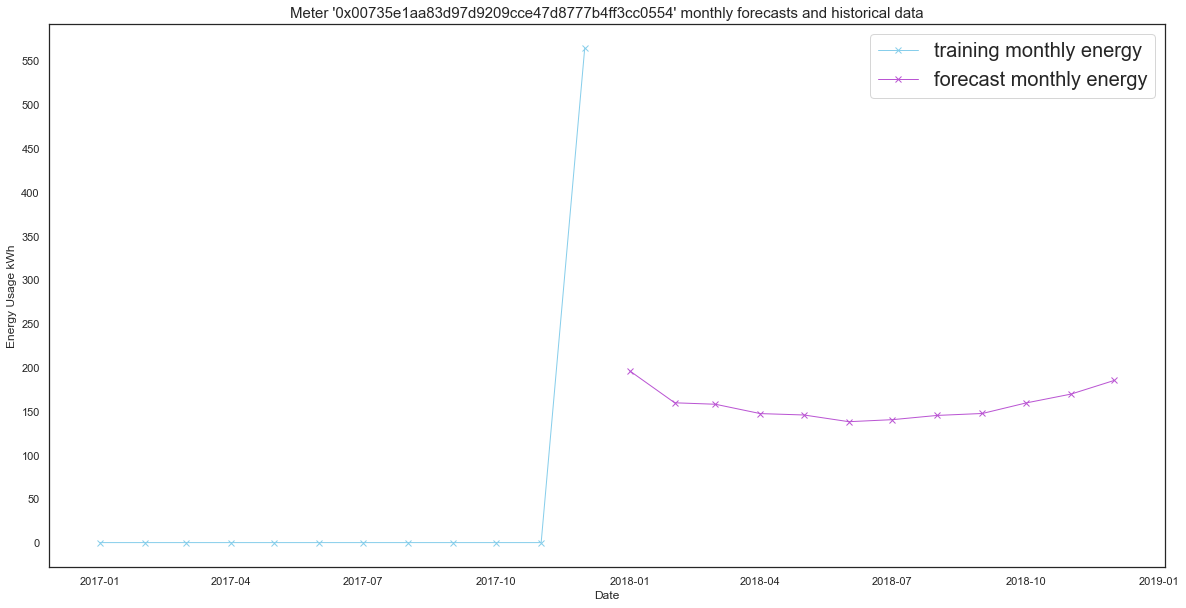

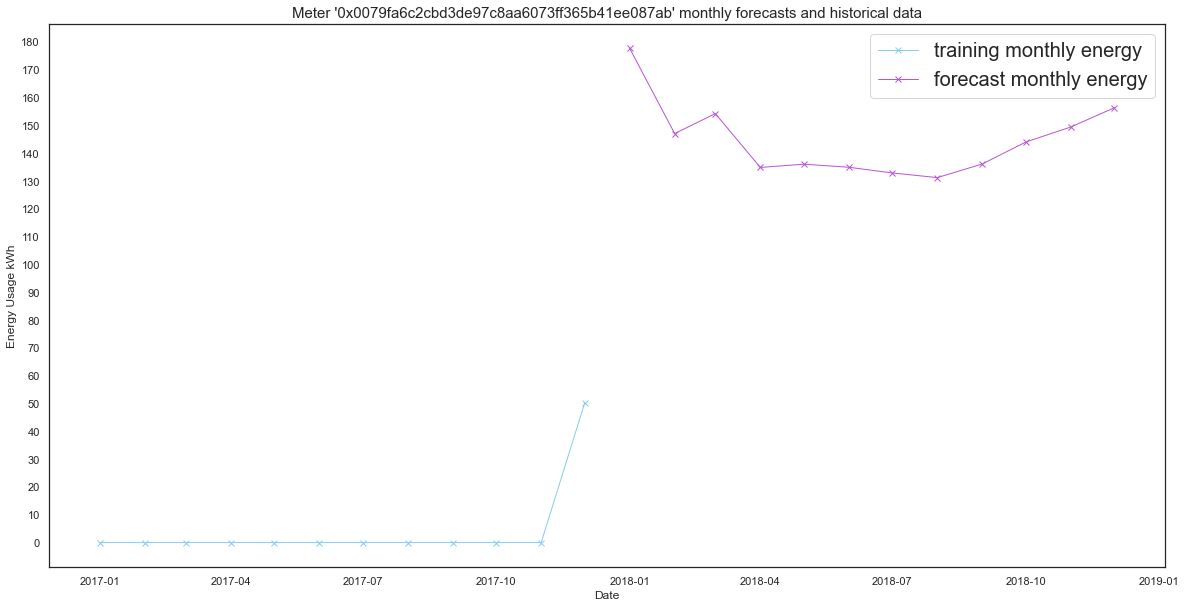

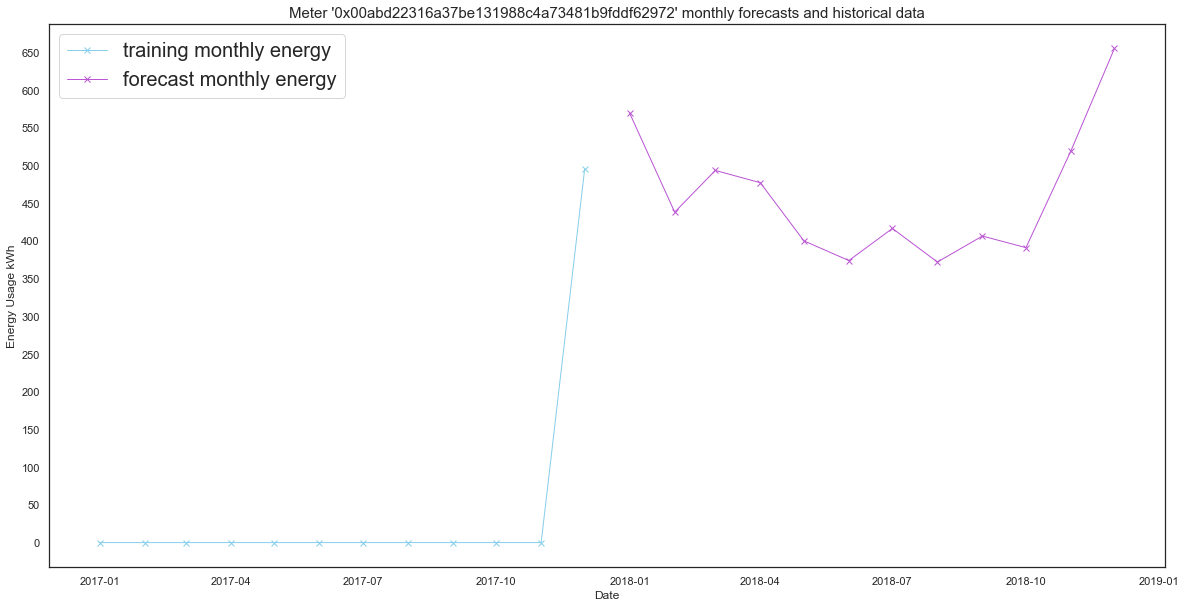

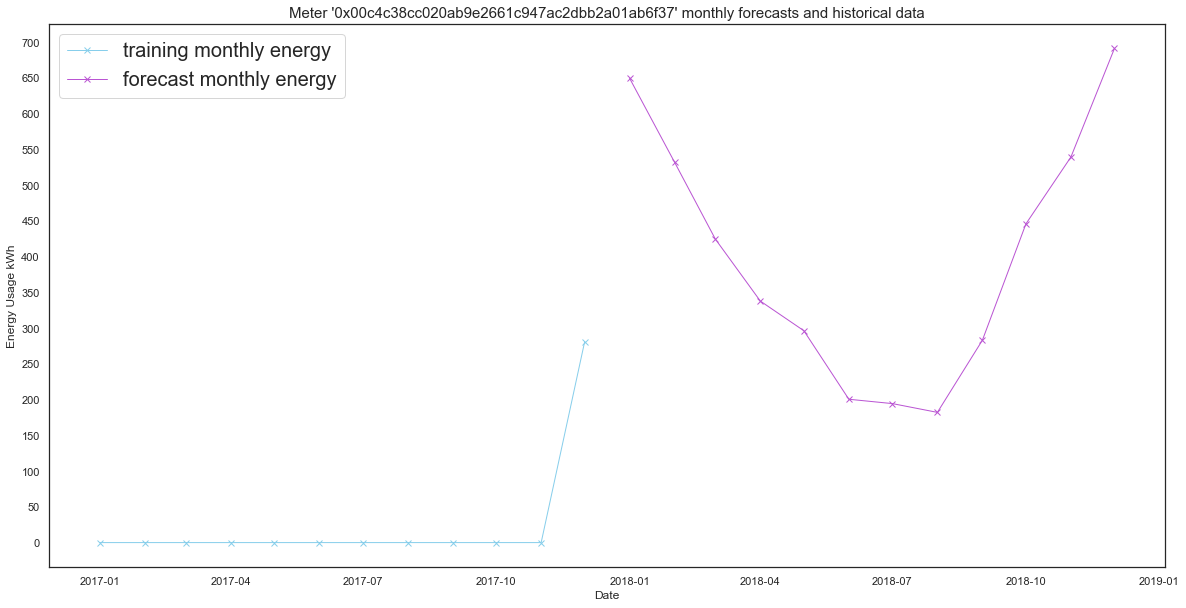

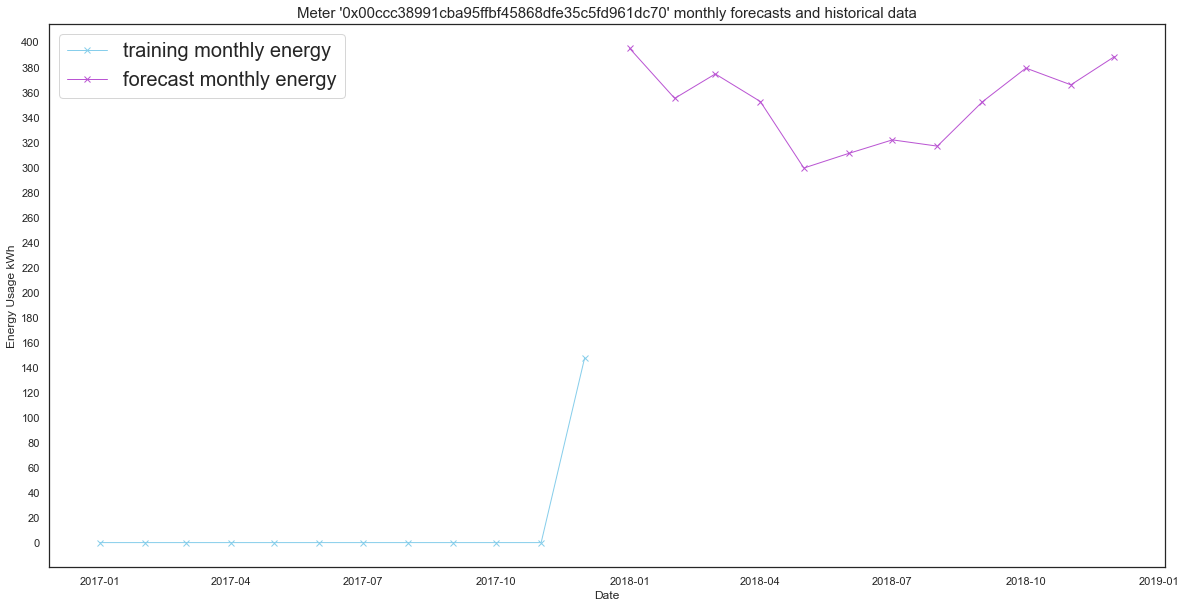

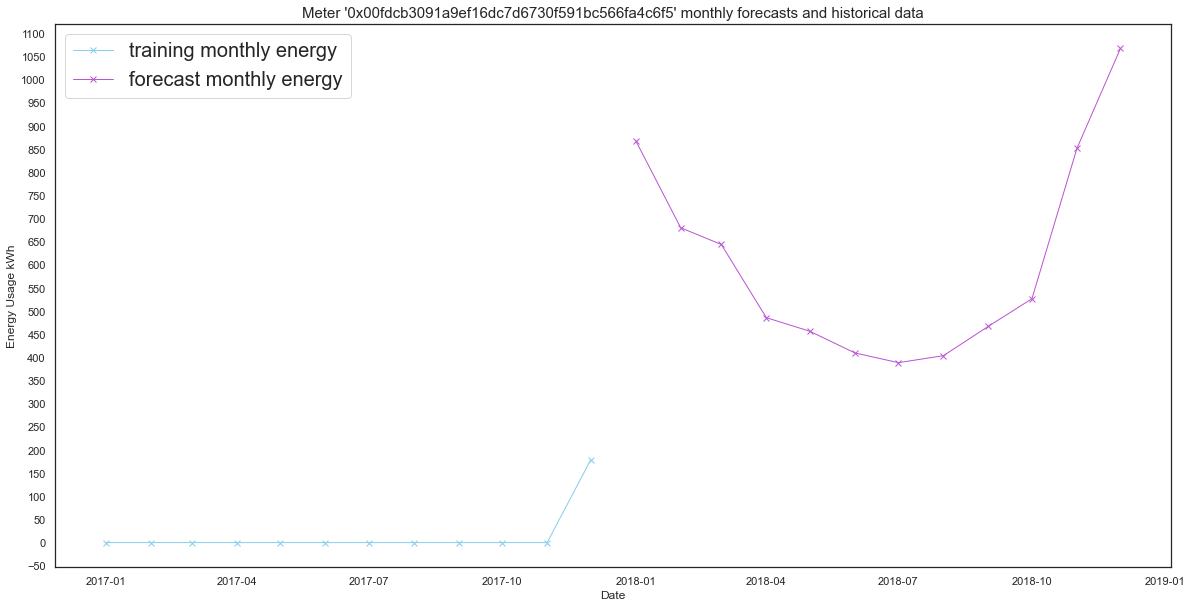

In [34]:
num_plots = 10
for pid in tqdm(range(0,3248)):
    if pid>num_plots:
        break
        
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,10))
    
    #plotting the monthly predictions
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    plt.show()
    fig.savefig(f"..\\Results\\Warm Firefly Algorithm\\Plots\\forecasts\\f{population_size}_i{number_of_iterations}_forecasts_{pid}_{meter_id}.png")

    fig.clf()
    fig.clear()
    plt.close()
    del fig, this_train_month, this_preds_month
    gc.collect()

# Training a model based on the main effects
* Running on the hyper params determined by main effects (setting that gave the lowest mean result)

In [35]:
# treating columns like main effects: accepting those whose mean error with the column is better than that without the column
main_columm_types = []
i=0
for key in possible_columns.keys():
    print(key,column_means[i]<columnless_means[i])
    main_columm_types.append(key)
    i+=1 
print(main_columm_types)

meter_id_ord True
meter_id_binary True
day_of_year_cyclic True
day_of_week True
day_of_month False
month_ord True
month_cyclic True
is_weekend True
energy_cluster True
num_bedrooms False
dwelling_type_ord False
dwelling_type_onehot False
['meter_id_ord', 'meter_id_binary', 'day_of_year_cyclic', 'day_of_week', 'day_of_month', 'month_ord', 'month_cyclic', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'dwelling_type_onehot']


In [36]:
#inspecting the stored best values for each hyper as determined by the main effects plot
#(value which resulted in the lowest average MAE on the val set)
print(arr_hypers)
print(arr_best_hypers) 

['learning_rate', 'num_leaves', 'max_depth', 'bagging_fraction', 'bagging_freq', 'feature_fraction', 'lambda_l1', 'lambda_l2']
[array([0.034]), array([958.]), array([10.]), array([0.87]), array([18.]), array([0.56]), array([7.]), array([14.])]


In [37]:
start_time = time.time()
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Running with main effects determined configuration{color.END}")

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the features{color.END}")
X_cols =[]

for key in main_columm_types:
    X_cols+=(possible_columns[key])
this_X_cats = list(set(X_cols).intersection(all_cat)) #getting the categorical values for this X
print(X_cols)

print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Using the main effects hyper parameters{color.END}")
this_params = params.copy()
this_params["learning_rate"] = arr_best_hypers[0][0]
this_params["max_depth"] = int(arr_best_hypers[2][0])
this_params["num_leaves"] = int(arr_best_hypers[1][0])
this_params["bagging_fraction"] = arr_best_hypers[3][0]
this_params["bagging_freq"] = int(arr_best_hypers[4][0])
this_params["feature_fraction"] = arr_best_hypers[5][0]
this_params["lambda_l1"] = int(arr_best_hypers[6][0])
this_params["lambda_l2"] = int(arr_best_hypers[7][0])
pprint(this_params)

#train the model with this hyper param config and store it's results
results=((run_lgbm_skf_cv(False, False, SEED, num_folds, df_train.copy(), y_col, X_cols, this_X_cats, this_params),(X_cols,this_params)))
print("\n\n\n")
time_of_execution = time.time()-start_time
print(f"{color.BOLD}Trained the model in {str(datetime.timedelta(seconds=round(time_of_execution)))}{color.END}\n")

Running with main effects determined configuration
Using the features
['meter_id_ord', 'meter_id_0', 'meter_id_1', 'meter_id_2', 'meter_id_3', 'meter_id_4', 'meter_id_5', 'meter_id_6', 'meter_id_7', 'meter_id_8', 'meter_id_9', 'meter_id_10', 'meter_id_11', 'meter_id_12', 'day_of_year_sin', 'day_of_year_cos', 'day_of_week', 'day_of_month', 'month_ord', 'month_sin', 'month_cos', 'is_weekend', 'energy_cluster', 'num_bedrooms', 'dwelling_type_ord', 'detached', 'flat', 'semi_detached', 'terraced']
Using the main effects hyper parameters
{'bagging_fraction': 0.87,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.56,
 'lambda_l1': 7,
 'lambda_l2': 14,
 'learning_rate': 0.034,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}
Fold 1
Training the LGBM
[LightGBM] [Warning] feature_fraction is set=0.56, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56
[LightGBM] [Warning] lambda_l1 is

# Forecasting from the main effects model

In [38]:
#making predictions based on the best performing model and displaying it's information
main_effects_models = results[0][2] #getting the lgbm_models from the best index
main_effects_forecasts = df_preds.copy()

#calculating the average preds by summing the weighted preds for each folds model
for i in range(len(main_effects_models)):
    pred_forecasts = main_effects_models[i].predict(main_effects_forecasts[results[1][0]], num_iteration=main_effects_models[i].best_iteration_) #predicting the unkown df_preds
    main_effects_forecasts[y_col] += pred_forecasts / num_folds #weighting the predictions for BEST_LGBM_FORECASTS for this fold and adding to df_preds y column 
main_effects_forecasts["meter_reading"] = main_effects_forecasts.meter_reading.clip(lower=0) #clip meter_reading so no predictions lower than 0

display(main_effects_forecasts)

meter_id meter_id_ord meter_id_0  \
0        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
1        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
2        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
3        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
4        0xa62b9f23553ff183f61e2bf943aab3d5983d02d7         2073          0   
...                                             ...          ...        ...   
1185515  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   
1185516  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   
1185517  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   
1185518  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   
1185519  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd         2605          0   

        meter_id_1 meter_id_2 meter_id_3 meter_id_4 meter_id_5 meter_id_6  \
0                0          0          0          0          0          0   
1                0          0          0          0          0          0   
2                0          0          0          0          0          0   
3                0          0          0          0          0          0   
4                0          0          0          0          0          0   
...            ...        ...        ...        ...        ...        ...   
1185515          1          1          0          0          1          0   
1185516          1          1          0          0          1          0   
1185517          1          1          0          0          1          0   
1185518          1          1          0          0          1          0   
1185519          1          1          0          0          1          0   

        meter_id_7  ... is_weekend energy_cluster num_bedrooms  \
0                0  ...          0              0          2.0   
1                0  ...          0              0          2.0   
2                0  ...          0              0          2.0   
3                0  ...          0              0          2.0   
4                0  ...          0              0          2.0   
...            ...  ...        ...            ...          ...   
1185515          1  ...          0              2          3.0   
1185516          1  ...          0              2          3.0   
1185517          1  ...          1              2          3.0   
1185518          1  ...          1              2          3.0   
1185519          1  ...          0              2          3.0   

          dwelling_type dwelling_type_ord detached  flat  semi_detached  \
0        terraced_house                 4      0.0   0.0            0.0   
1        terraced_house                 4      0.0   0.0            0.0   
2        terraced_house                 4      0.0   0.0            0.0   
3        terraced_house                 4      0.0   0.0            0.0   
4        terraced_house                 4      0.0   0.0            0.0   
...                 ...               ...      ...   ...            ...   
1185515  detached_house                 1      1.0   0.0            0.0   
1185516  detached_house                 1      1.0   0.0            0.0   
1185517  detached_house                 1      1.0   0.0            0.0   
1185518  detached_house                 1      1.0   0.0            0.0   
1185519  detached_house                 1      1.0   0.0            0.0   

        terraced meter_reading  
0            1.0      4.829670  
1            1.0      5.333272  
2            1.0      4.876222  
3            1.0      4.782166  
4            1.0      5.150095  
...          ...           ...  
1185515      0.0     18.012605  
1185516      0.0     19.009572  
1185517      0.0     18.678446  
1185518      0.0     18.684841  
1185519      0.0     16.306390  

[1185520 rows x 33 columns]

# Comparing the val error of the main effects vs the best from Firefly algorithm tuning
## Firefly Algorithm summary

In [39]:
best_index

0

In [40]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}FA best model came from iteration {int(best_index/population_size)} individual {best_index%population_size}{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {best_results[0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(best_results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(best_results[1][1])

FA best model came from iteration 0 individual 0
Evaluation and results
Mean absolute error between OOF preds and meter_reading on training set: 1.7452173623975176

Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'month_ord',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.87,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.93,
 'lambda_l1': 7,
 'lambda_l2': 5,
 'learning_rate': 0.034,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}


## Main effects based model summary

In [41]:
#printing the forecasts and other evaluation info
print(f"{color.BOLD}{color.RED}{color.UNDERLINE}Main effects model based on results of FA{color.END}")
#displaying the results
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Evaluation and results{color.END}")
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}Mean absolute error between OOF preds and meter_reading on training set:{color.END} {results[0][1]}\n")
#displaying the hyperparameters
print(f"{color.BOLD}{color.BLUE}{color.UNDERLINE}Hyper-parameters{color.END}")
print(f"\n{color.BOLD}{color.CYAN}{color.UNDERLINE}X_cols:{color.END}\n")
pprint(results[1][0])
print(f"{color.BOLD}{color.CYAN}{color.UNDERLINE}model params:  {color.END}")
pprint(results[1][1])

Main effects model based on results of FA
Evaluation and results
Mean absolute error between OOF preds and meter_reading on training set: 1.9052974927597957

Hyper-parameters

X_cols:

['meter_id_ord',
 'meter_id_0',
 'meter_id_1',
 'meter_id_2',
 'meter_id_3',
 'meter_id_4',
 'meter_id_5',
 'meter_id_6',
 'meter_id_7',
 'meter_id_8',
 'meter_id_9',
 'meter_id_10',
 'meter_id_11',
 'meter_id_12',
 'day_of_year_sin',
 'day_of_year_cos',
 'day_of_week',
 'day_of_month',
 'month_ord',
 'month_sin',
 'month_cos',
 'is_weekend',
 'energy_cluster',
 'num_bedrooms',
 'dwelling_type_ord',
 'detached',
 'flat',
 'semi_detached',
 'terraced']
model params:  
{'bagging_fraction': 0.87,
 'bagging_freq': 18,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.56,
 'lambda_l1': 7,
 'lambda_l2': 14,
 'learning_rate': 0.034,
 'max_depth': 10,
 'metric': 'mae',
 'num_iterations': 10000,
 'num_leaves': 958,
 'num_threads': -1,
 'seed': 1337}


#### Conclusion:
the best model from the FA is way better than the main effects of the FA


# Save the main effects description

In [42]:
import pickle

a = {'hello': 'world'}
desc_disc = {
    "MAE":results[0][1],
    "features":results[1][0],
    "params":results[1][1]
}

with open(f"..\\Results\\Warm Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_desc.pkl", 'wb') as handle:
    pickle.dump(desc_disc, handle, protocol=pickle.HIGHEST_PROTOCOL)

pprint(desc_disc)
    
# verifying it saved correctly and can be loaded back
with open(f"..\\Results\\Warm Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_desc.pkl", 'rb') as handle:
    desc_disc_loaded = pickle.load(handle)
print(desc_disc == desc_disc_loaded)

{'MAE': 1.9052974927597957,
 'features': ['meter_id_ord',
              'meter_id_0',
              'meter_id_1',
              'meter_id_2',
              'meter_id_3',
              'meter_id_4',
              'meter_id_5',
              'meter_id_6',
              'meter_id_7',
              'meter_id_8',
              'meter_id_9',
              'meter_id_10',
              'meter_id_11',
              'meter_id_12',
              'day_of_year_sin',
              'day_of_year_cos',
              'day_of_week',
              'day_of_month',
              'month_ord',
              'month_sin',
              'month_cos',
              'is_weekend',
              'energy_cluster',
              'num_bedrooms',
              'dwelling_type_ord',
              'detached',
              'flat',
              'semi_detached',
              'terraced'],
 'params': {'bagging_fraction': 0.87,
            'bagging_freq': 18,
            'boosting_type': 'gbdt',
            'feature_fraction':

# Formatting the main effects forecasts and saving them

# Converting into monthly forecasts

In [43]:
#restructuring into the original multiple time series format
#aggregating up the total sum of the months predictions
df_monthly_forecasts = main_effects_forecasts.groupby(["meter_id", "month_ord"])["meter_reading"].sum().unstack()

#rename ordinal encoded month with its corresponding name
df_monthly_forecasts.rename(columns={1:"Jan", 2:"Feb",3:"Mar",4:"Apr",5:"May",6:"Jun",7:"Jul",8:"Aug",9:"Sep",10:"Oct",11:"Nov",12:"Dec"}, inplace=True)
#resetting the index 
df_monthly_forecasts.reset_index(inplace=True)
df_monthly_forecasts.index.name = None # removing index column
df_monthly_forecasts.columns.name = None # removing columns name

display(df_monthly_forecasts)

meter_id         Jan         Feb  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c  177.563536  138.115773   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82  672.449291  580.426241   
2     0x0019979ee12c59accd24d1c83291528ced1bb734  272.425986  234.091294   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a  182.328506  159.074039   
4     0x005958406351bb29580475df698b5f1070096397  402.724958  376.437117   
...                                          ...         ...         ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f  271.228008  178.274458   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  724.608849  654.268045   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  573.837158  467.011782   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  351.656536  352.330452   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  262.991758  222.800244   

             Mar         Apr         May         Jun         Jul         Aug  \
0     108.931862   88.120085   99.092915   95.930987   97.756678  109.226740   
1     557.810086  531.612892  493.503287  435.528501  425.071682  441.124229   
2     220.279512  204.923706  201.604872  202.704254  205.342485  216.304712   
3     148.018414  120.853154  123.943962  128.077559  123.631294  124.038177   
4     388.201204  331.031889  317.926731  333.285394  328.870069  335.571763   
...          ...         ...         ...         ...         ...         ...   
3243  170.579957  141.907237  130.179338  124.054038  126.891146  133.699430   
3244  693.844221  636.294058  590.032177  466.810249  464.684494  484.800663   
3245  417.010151  356.301803  329.282558  267.880053  279.366356  278.452301   
3246  333.588619  344.549399  233.940018  218.989400  216.982719  227.036310   
3247  240.207863  208.732335  222.082202  213.140967  222.334558  225.040913   

             Sep         Oct         Nov         Dec  
0     111.186704  125.933347  107.324295  145.413580  
1     502.113544  552.789891  608.806651  655.145544  
2     204.958814  197.133142  204.338120  236.645279  
3     126.825709  136.095258  137.500535  165.862531  
4     355.977758  365.815703  388.755053  399.545845  
...          ...         ...         ...         ...  
3243  135.089609  149.378552  151.325171  188.625757  
3244  522.960597  566.615470  585.177138  665.155300  
3245  300.039760  354.651951  454.647699  526.340011  
3246  240.789086  271.896452  294.625607  346.287174  
3247  232.919982  237.240644  235.792603  239.546265  

[3248 rows x 13 columns]

## Saving these monthly predictions to be submitted to competition
* Saving predictions ready to be submitted so I can get the MAE on the test set

In [44]:
df_monthly_forecasts.to_csv(f"..\\Results\\Warm Firefly Algorithm\\f{population_size}_i{number_of_iterations}_main_effects_monthly_forecasts.csv", index=False, header=True)

# Plotting these monthly forecasts
## Renaming months to dates for plotting

In [45]:
df_monthly_forecasts.rename(columns={"Jan":"2018-01", "Feb":"2018-02","Mar":"2018-03","Apr":"2018-04","May":"2018-05","Jun":"2018-06","Jul":"2018-07","Aug":"2018-08","Sep":"2018-09","Oct":"2018-10","Nov":"2018-11","Dec":"2018-12"}, inplace=True)
df_monthly_forecasts

meter_id     2018-01     2018-02  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c  177.563536  138.115773   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82  672.449291  580.426241   
2     0x0019979ee12c59accd24d1c83291528ced1bb734  272.425986  234.091294   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a  182.328506  159.074039   
4     0x005958406351bb29580475df698b5f1070096397  402.724958  376.437117   
...                                          ...         ...         ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f  271.228008  178.274458   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  724.608849  654.268045   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  573.837158  467.011782   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  351.656536  352.330452   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  262.991758  222.800244   

         2018-03     2018-04     2018-05     2018-06     2018-07     2018-08  \
0     108.931862   88.120085   99.092915   95.930987   97.756678  109.226740   
1     557.810086  531.612892  493.503287  435.528501  425.071682  441.124229   
2     220.279512  204.923706  201.604872  202.704254  205.342485  216.304712   
3     148.018414  120.853154  123.943962  128.077559  123.631294  124.038177   
4     388.201204  331.031889  317.926731  333.285394  328.870069  335.571763   
...          ...         ...         ...         ...         ...         ...   
3243  170.579957  141.907237  130.179338  124.054038  126.891146  133.699430   
3244  693.844221  636.294058  590.032177  466.810249  464.684494  484.800663   
3245  417.010151  356.301803  329.282558  267.880053  279.366356  278.452301   
3246  333.588619  344.549399  233.940018  218.989400  216.982719  227.036310   
3247  240.207863  208.732335  222.082202  213.140967  222.334558  225.040913   

         2018-09     2018-10     2018-11     2018-12  
0     111.186704  125.933347  107.324295  145.413580  
1     502.113544  552.789891  608.806651  655.145544  
2     204.958814  197.133142  204.338120  236.645279  
3     126.825709  136.095258  137.500535  165.862531  
4     355.977758  365.815703  388.755053  399.545845  
...          ...         ...         ...         ...  
3243  135.089609  149.378552  151.325171  188.625757  
3244  522.960597  566.615470  585.177138  665.155300  
3245  300.039760  354.651951  454.647699  526.340011  
3246  240.789086  271.896452  294.625607  346.287174  
3247  232.919982  237.240644  235.792603  239.546265  

[3248 rows x 13 columns]

## Restructuring forecasts into daily predictions to plot on top of monthly preds

In [46]:
#daily forecasts to plot on top of monthly
df_daily_forecasts = main_effects_forecasts.groupby(["meter_id","date"])["meter_reading"].sum().unstack()

#resetting the index 
df_daily_forecasts.reset_index(inplace=True)
df_daily_forecasts.index.name = None # removing index column
df_daily_forecasts.columns.name = None # removing columns name

df_daily_forecasts

meter_id  2018-01-01 00:00:00  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c             6.990325   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82            18.379104   
2     0x0019979ee12c59accd24d1c83291528ced1bb734             9.059371   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a             6.759213   
4     0x005958406351bb29580475df698b5f1070096397            13.770069   
...                                          ...                  ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f             9.606105   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb            24.357358   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5            19.432927   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02            11.198829   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4             7.566138   

      2018-01-02 00:00:00  2018-01-03 00:00:00  2018-01-04 00:00:00  \
0                6.298036             6.041464             5.838626   
1               20.579731            22.696158            20.240979   
2                9.406838             9.753116             8.457819   
3                6.370098             5.931832             5.690699   
4               12.667595            12.384830            12.099565   
...                   ...                  ...                  ...   
3243             9.176686             8.730570             9.028833   
3244            25.940445            24.167621            22.740975   
3245            21.078976            20.113145            17.264124   
3246            11.480787            11.417417            11.818761   
3247             8.793137             8.185367             7.680846   

      2018-01-05 00:00:00  2018-01-06 00:00:00  2018-01-07 00:00:00  \
0                5.886225             6.569901             5.996000   
1               19.911060            23.076431            23.840572   
2                8.468120             9.155557             9.136759   
3                5.861906             6.436199             6.375218   
4               12.431042            12.359306            12.543020   
...                   ...                  ...                  ...   
3243             9.318104            10.207827             9.095685   
3244            23.328885            22.830091            22.480977   
3245            18.010046            18.079147            18.867310   
3246            11.073220            12.509235            12.097183   
3247             8.425539             8.903326             8.256220   

      2018-01-08 00:00:00  2018-01-09 00:00:00  ...  2018-12-22 00:00:00  \
0                5.732899             5.711618  ...             4.558868   
1               21.967491            22.732172  ...            22.814204   
2                7.993565             8.382118  ...             7.687645   
3                5.580124             6.123908  ...             5.144985   
4               12.407667            12.542075  ...            13.991789   
...                   ...                  ...  ...                  ...   
3243             9.584620            10.094978  ...             6.236817   
3244            23.367659            23.717423  ...            20.383707   
3245            19.704207            17.483140  ...            15.411170   
3246            12.020422            10.631081  ...            11.594769   
3247             9.014678             8.815716  ...             7.889240   

      2018-12-23 00:00:00  2018-12-24 00:00:00  2018-12-25 00:00:00  \
0                4.283222             4.020270             4.070388   
1               22.776197            20.738804            18.858629   
2                7.762817             7.812951             7.697542   
3                4.870448             4.230641             4.541702   
4               13.363322            12.671707            11.795606   
...                   ...                  ...                  ...   
3243             6.487779             6.100936 

## loading training data and aggregating into months

In [47]:
#loading the training data
print("training data")
df_train_daily = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl").fillna(0)

#aggregating up into months
meter_id=df_monthly_forecasts["meter_id"]
df_train_monthly = pd.DataFrame(columns=["meter_id"])
df_train_monthly["meter_id"] = meter_id


#for each month in the range of dates
resample_size="M"
for new_sample in tqdm(pd.date_range(datetime.datetime(2017, 1, 1), datetime.datetime(2017, 12, 31), freq = resample_size),position=0):

    #get this columns name as a string
    columnName = str(new_sample.date())[:7]
    #get all columns that relate to this new sample
    columns = [i for i in df_train_daily.columns.values[1:] if i.startswith(columnName)]

    #sum these up into a value for the new sample size
    df_train_monthly[columnName] = df_train_daily[columns].sum(axis=1)

display(df_train_daily)
display(df_train_monthly)

training data


  0%|          | 0/12 [00:00<?, ?it/s]

meter_id  2017-01-01  2017-01-02  \
0     0xa62b9f23553ff183f61e2bf943aab3d5983d02d7       0.000       0.000   
1     0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da       0.000       0.000   
2     0x4a1ed36825360a058cec2bdd409fc2459e1ce54f       0.000       0.000   
3     0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407       0.000       0.000   
4     0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f       0.000       0.000   
...                                          ...         ...         ...   
3243  0x7dd7a7b8ee1bec7c44b24f738c752482f6161065       2.317       2.301   
3244  0xfdaf9f857621ec06f2cf801f42a020a322835090      14.437      16.274   
3245  0xd28f2f001e0cd4d6c121a3cb2e1427207e170e18       7.824       7.517   
3246  0x47218b46abb2fcaade487a211911406dc6e13730      23.965      28.689   
3247  0xcd19e6fe3d887bc5dcac7ca18d46199695463fdd      11.302      14.178   

      2017-01-03  2017-01-04  2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
0          0.000       0.000       0.000       0.000       0.000       0.000   
1          0.000       0.000       0.000       0.000       0.000       0.000   
2          0.000       0.000       0.000       0.000       0.000       0.000   
3          0.000       0.000       0.000       0.000       0.000       0.000   
4          0.000       0.000       0.000       0.000       0.000       0.000   
...          ...         ...         ...         ...         ...         ...   
3243       2.352       2.516       2.229       2.354       2.397       2.397   
3244       7.031      17.018      17.603      15.005       8.987       8.490   
3245       5.398       6.788       7.360       6.898       7.321       8.042   
3246      27.664      29.229      29.548      27.909      26.923      21.277   
3247      15.499      11.853      17.431      14.506      12.812      10.472   

      2017-01-09  ...  2017-12-22  2017-12-23  2017-12-24  2017-12-25  \
0          0.000  ...       4.030       5.397      5.1075       4.818   
1          0.000  ...      13.101      14.327     14.6315      14.936   
2          0.000  ...      10.201       7.320      7.3520       7.384   
3          0.000  ...      14.833      12.477     11.7255      10.974   
4          0.000  ...      39.440      35.538     21.9445       8.351   
...          ...  ...         ...         ...         ...         ...   
3243       2.269  ...       9.390       9.231      9.2235       9.216   
3244      10.136  ...       4.141       2.828      3.8230       4.818   
3245       8.207  ...       6.767       5.919      5.9980       6.077   
3246      23.452  ...      20.747      19.979     20.1925      20.406   
3247      10.879  ...      14.036      15.990     15.5505      15.111   

      2017-12-26  2017-12-27  2017-12-28  2017-12-29  2017-12-30  2017-12-31  
0          3.931      4.2170       4.503      4.8160       5.129       5.395  
1         16.174     20.3960      24.618     19.8925      15.167      11.751  
2         14.425     16.0650      17.705     13.3355       8.966       4.633  
3         19.646     21.8195      23.993     19.9170      15.841      14.452  
4          9.957     17.9140      25.871     36.0725      46.274      16.901  
...          ...         ...         ...         ...         ...         ...  
3243       9.336      9.6840      10.032      9.8945       9.757       9.480  
3244       3.357      8.1315      12.906      8.0140       3.122       3.401  
3245       7.761      6.6080       5.455      5.5670       5.679       8.148  
3246      23.668     27.7900      31.912     29.1125      26.313      24.201  
3247      16.506     18.7585      21.011     19.2040      17.397      15.237  

[3248 rows x 366 columns]

meter_id   2017-01  2017-02   2017-03  \
0     0x0001f1c389823f953b2eaee0a61c33539744da0c    0.0000    0.000    0.0000   
1     0x000f697092696c27b0bb489ea4c11280ef72ab82    0.0000    0.000    0.0000   
2     0x0019979ee12c59accd24d1c83291528ced1bb734    0.0000    0.000    0.0000   
3     0x001d6227832325ab6167b82d6d7175d254f57c3a    0.0000    0.000    0.0000   
4     0x005958406351bb29580475df698b5f1070096397    0.0000    0.000    0.0000   
...                                          ...       ...      ...       ...   
3243  0xffb4c5014834a46d09d0092e748c1ef5acd8733f   72.7050   63.245   68.4335   
3244  0xffbdc1d9209f45668fb0be65b6d50cb999890ccb  371.4390  269.691  179.3430   
3245  0xffcbcdc7c3ce3451252b84c2aaf6f40d652d16d5  209.8065  169.858  184.0130   
3246  0xffe91f021d145e1560fcad8c3af5ac0ef9d76a02  845.6630  608.449  588.7765   
3247  0xfff895258c21f1a58fc06538173d02b621021ad4  428.7345  670.505  462.1050   

       2017-04   2017-05  2017-06   2017-07   2017-08   2017-09     2017-10  \
0       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
1       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
2       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
3       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
4       0.0000    0.0000    0.000    0.0000    0.0000    0.0000    0.000000   
...        ...       ...      ...       ...       ...       ...         ...   
3243   66.6265   69.0480  100.430  177.1735  177.4100  216.7245  279.164500   
3244  141.6590  138.4835  122.910  164.2285  100.9610  118.0520  123.135500   
3245  166.7280  134.1760  169.489  157.5775  165.9640  177.0105  185.701833   
3246  503.3050  291.1320  177.605  183.5345  182.0350  244.2255  371.458333   
3247  354.8660  287.9950  200.321  227.0855  231.7585  246.3005  344.210167   

         2017-11    2017-12  
0       0.000000  128.39450  
1       0.000000  553.18400  
2       0.000000  368.90957  
3       0.000000  534.84650  
4       0.000000  946.06400  
...          ...        ...  
3243  351.481000  312.08800  
3244  187.140000  186.88400  
3245  192.288667  200.61950  
3246  695.878667  858.83950  
3247  516.290333  734.61800  

[3248 rows x 13 columns]

## Plotting the predictions against the training data

  0%|          | 0/3248 [00:00<?, ?it/s]

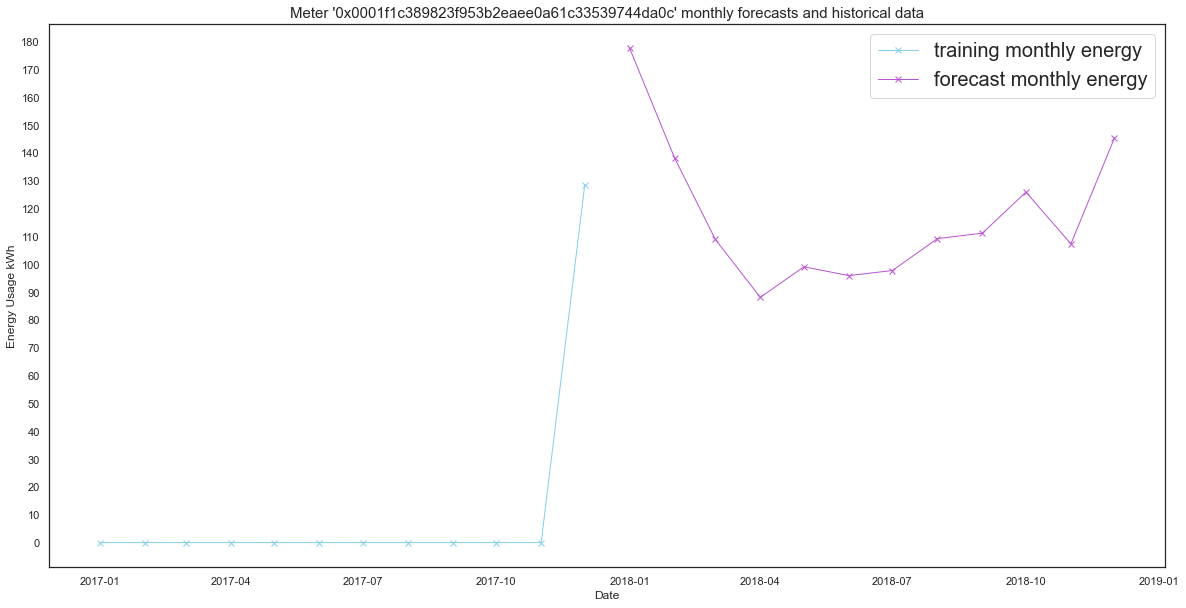

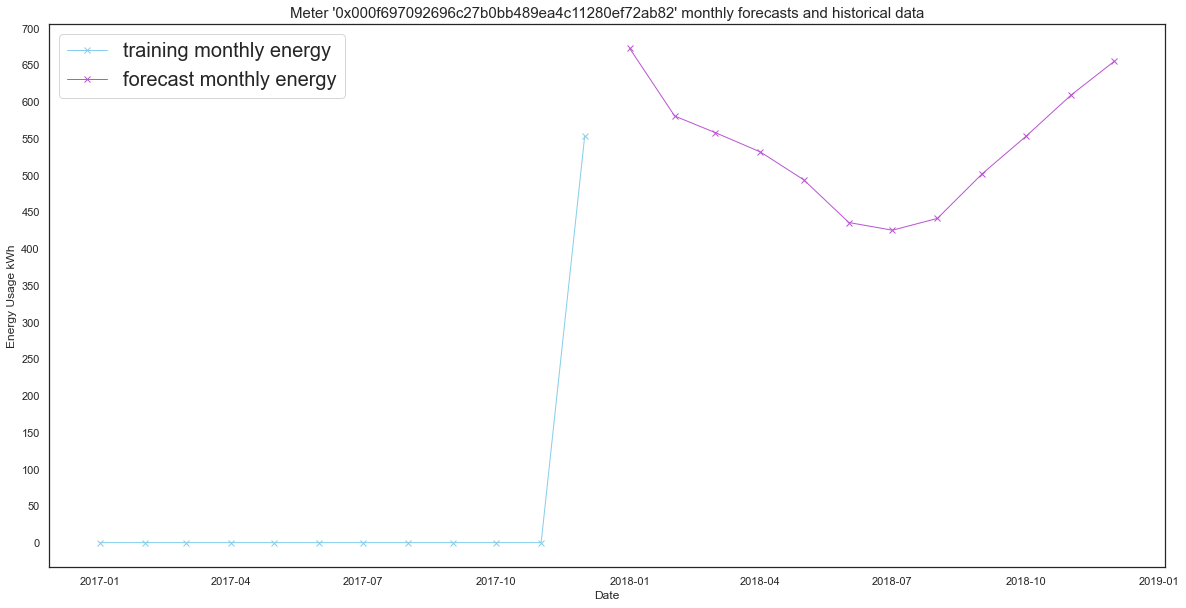

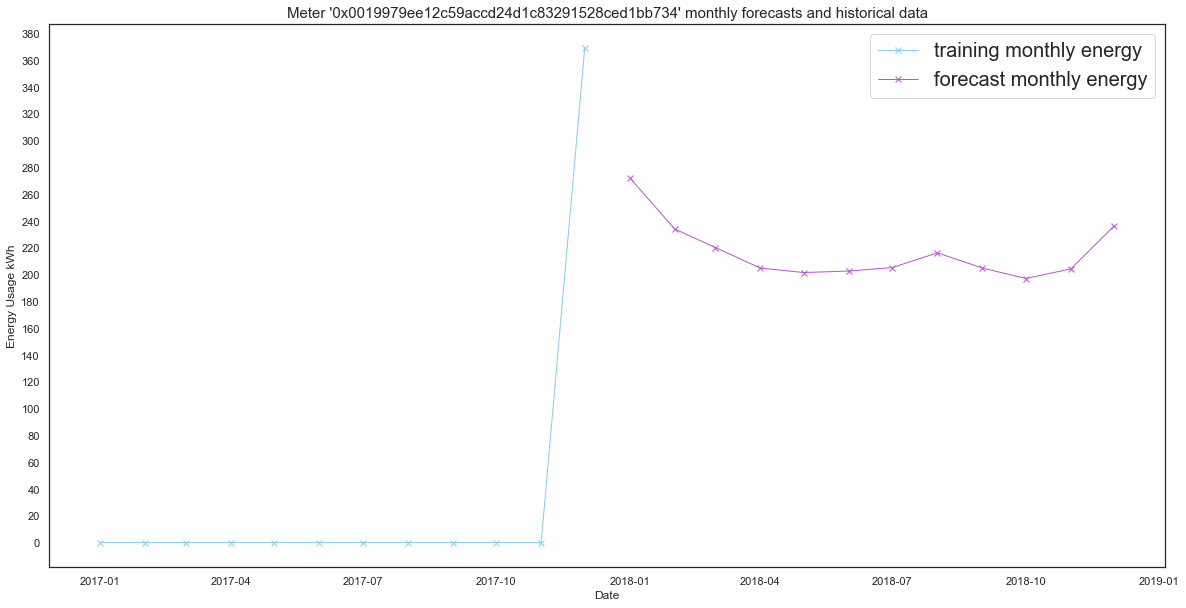

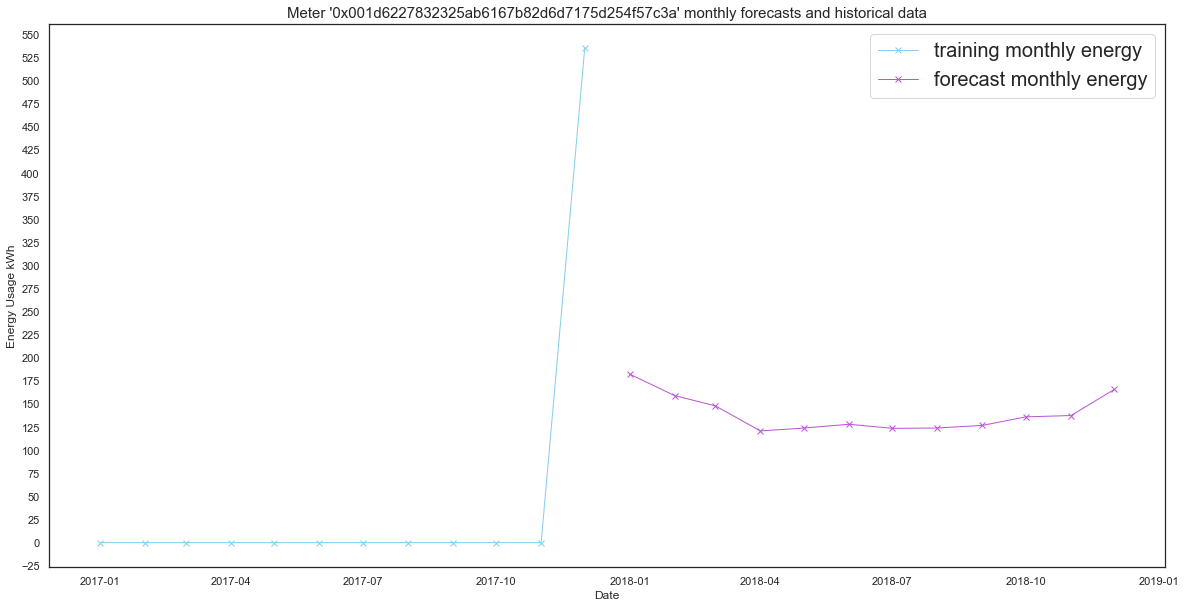

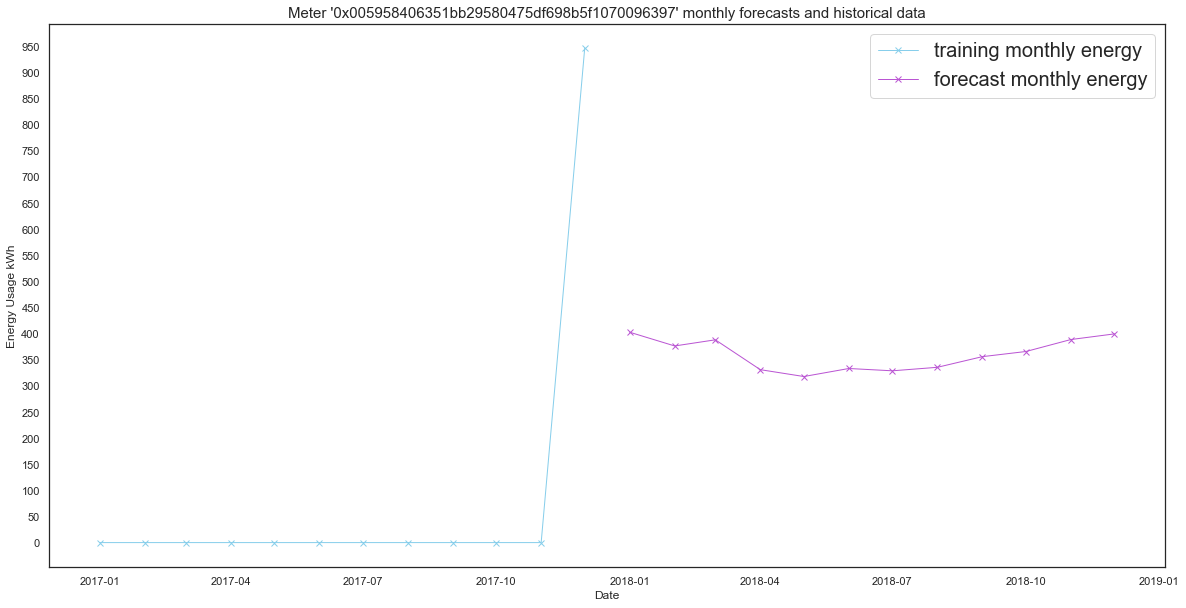

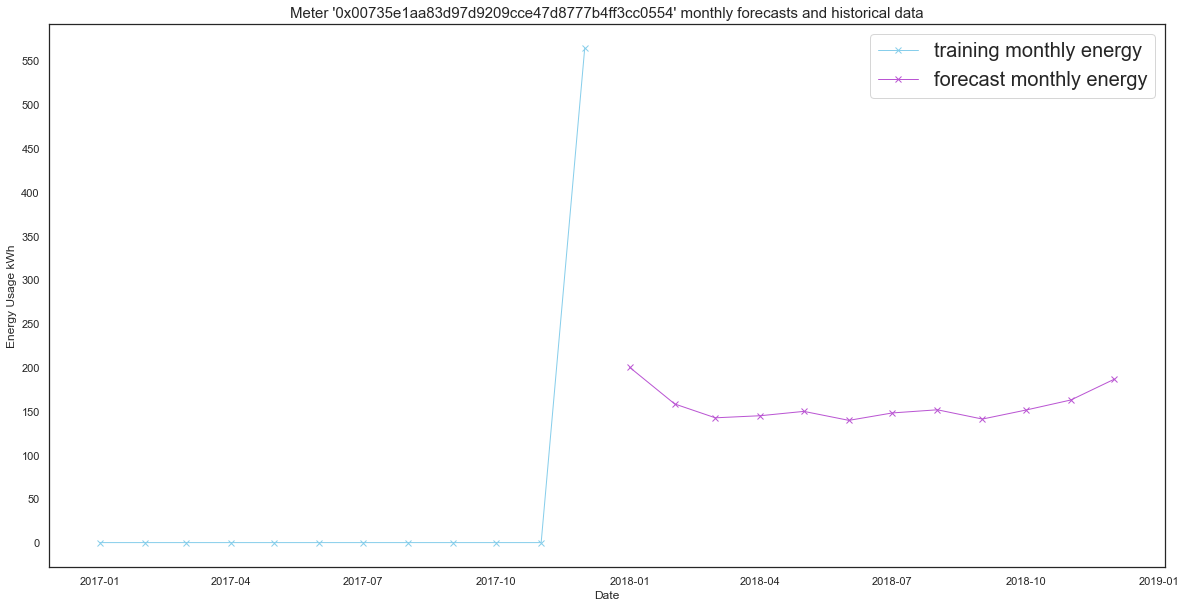

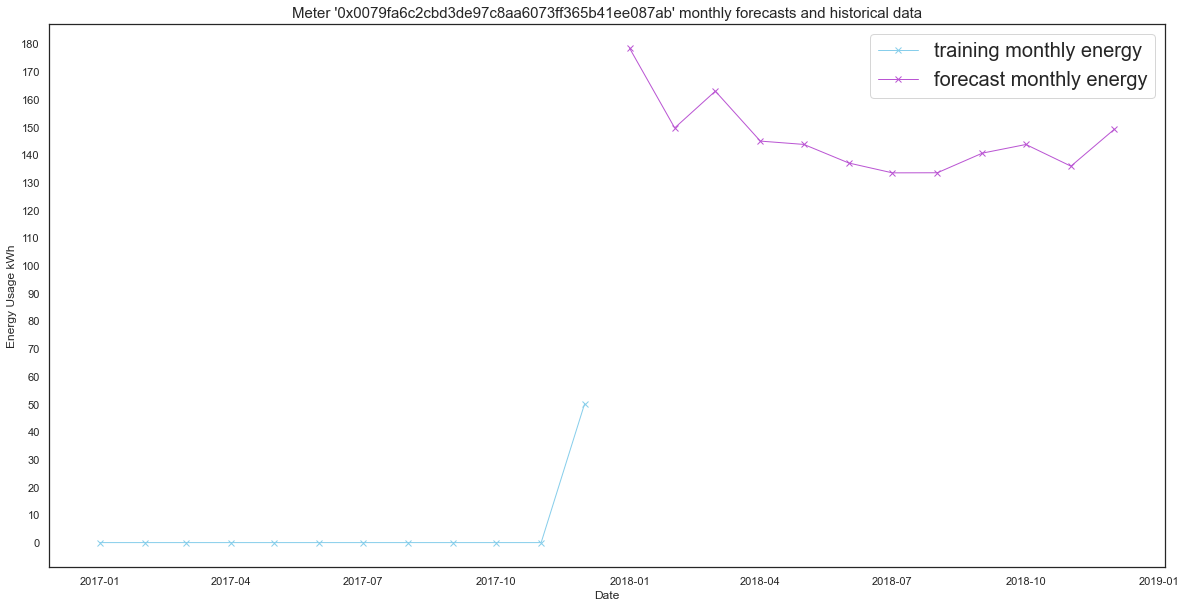

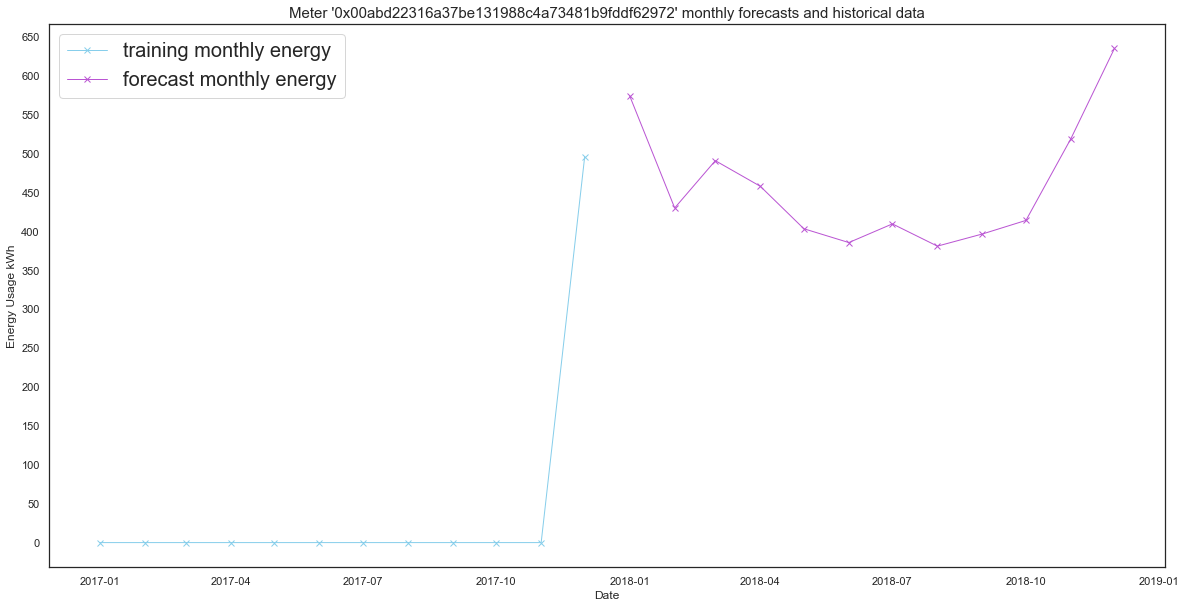

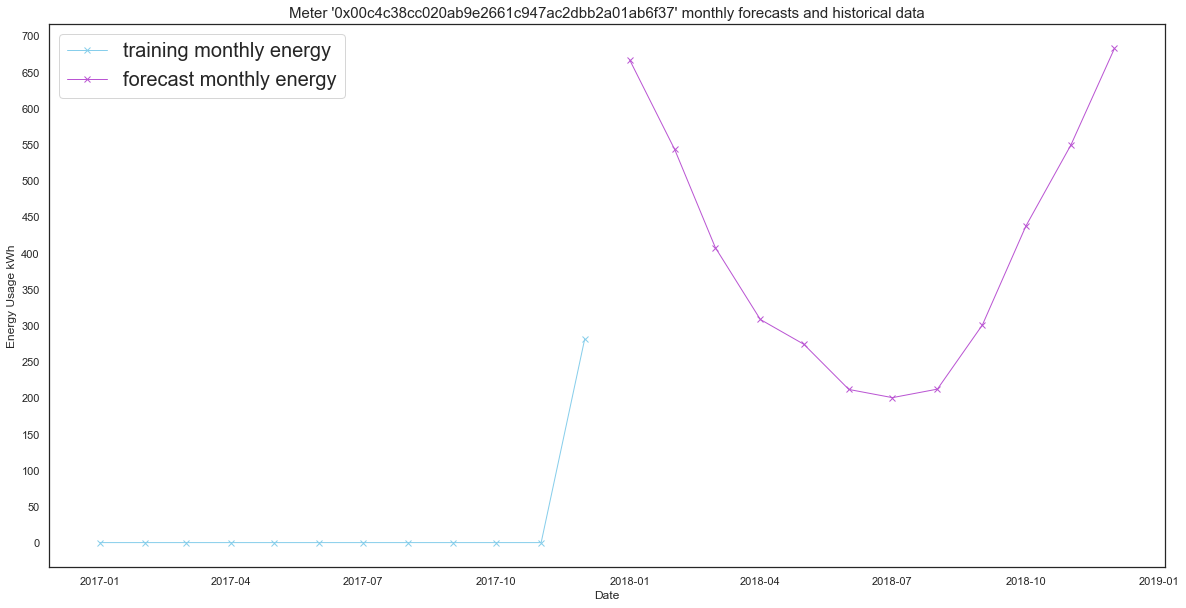

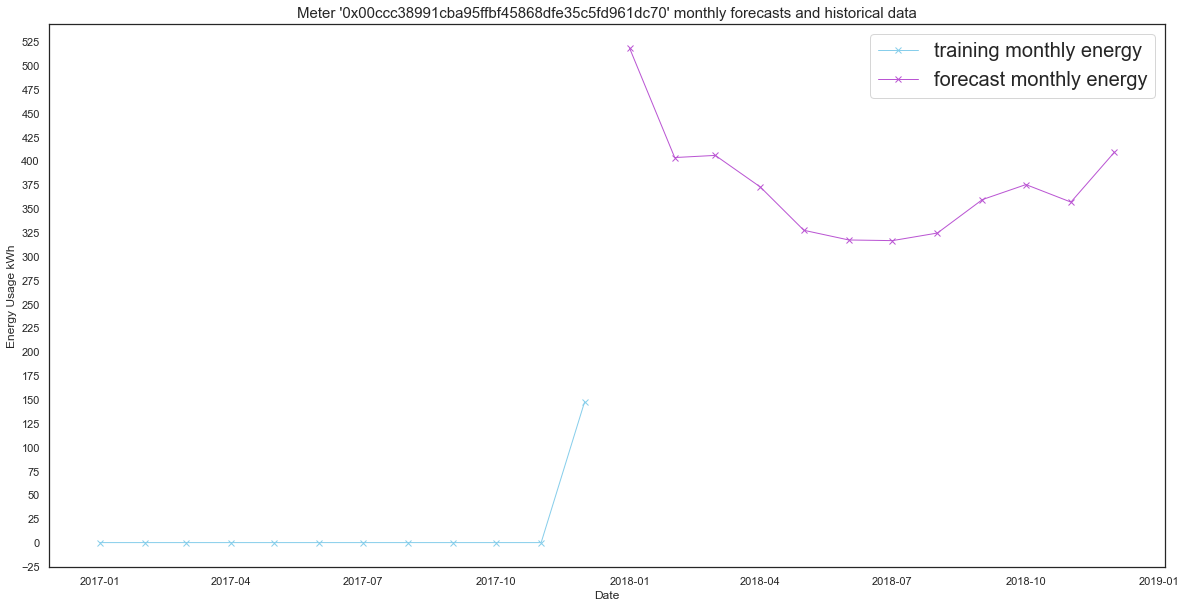

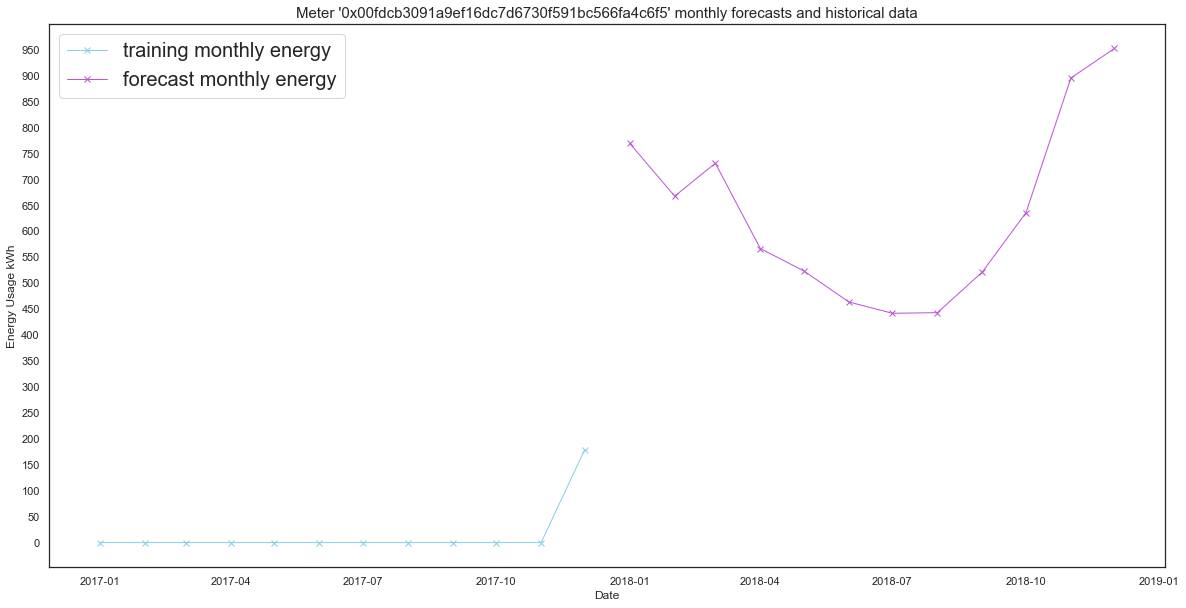

In [48]:
num_plots = 10
for pid in tqdm(range(0,3248)):
    if pid>num_plots:
        break
        
    #getting the row corresponding to this meter_id
    meter_id = df_daily_forecasts.iloc[pid,0]
    this_train_month = df_train_monthly.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    this_preds_month = df_monthly_forecasts.loc[df_train_monthly['meter_id'] == meter_id].T[1:]
    
    #converting index to datetime for ease of plots key
    this_train_month.index=pd.to_datetime(this_train_month.index)
    this_preds_month.index=pd.to_datetime(this_preds_month.index)
    
    #creating figure
    fig = plt.figure(figsize=(20,10))
    
    #plotting the monthly predictions
    plt.title("Meter '"+str(meter_id)+"' monthly forecasts and historical data", fontsize=15)
    plt.xlabel("Date")
    plt.ylabel("Energy Usage kWh")
    plt.plot(this_train_month, label="training monthly energy", lw=1,color="skyblue", marker="x")
    plt.plot(this_preds_month, label="forecast monthly energy", lw=1,color="mediumorchid", marker="x")
    
    #annotations
    plt.legend(fontsize=20)
    plt.locator_params(nbins=24)
    
    plt.show()
    fig.savefig(f"..\\Results\\Warm Firefly Algorithm\\Plots\\forecasts\\main_effects\\f{population_size}_i{number_of_iterations}_forecasts_{pid}_{meter_id}.png")

    fig.clf()
    fig.clear()
    plt.close()
    del fig, this_train_month, this_preds_month
    gc.collect()